In [213]:
import re
import time
import math
import joblib
import nltk

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('precision', 3)

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

import seaborn as sns
sns.set_style('darkgrid')

from scipy.sparse import hstack
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB

print("Libraries Loaded!")

Libraries Loaded!


### Getting the data

In [2]:
train_varient = pd.read_csv("../input/train_variants")
train_text = pd.read_csv("../input/train_text", sep="\|\|", engine="python", names=["ID", "TEXT"], skiprows=1)
data = pd.merge(train_varient, train_text, on="ID", how="left")

print("DataFrame Loaded!")
print("=================")
print(f"After Merging variants and text: {data.shape[1]} columns = {data.columns.values} and {data.shape[0]} rows")

DataFrame Loaded!
After Merging variants and text: 5 columns = ['ID' 'Gene' 'Variation' 'Class' 'TEXT'] and 3321 rows


### A Quick look at our data

In [3]:
data.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...

- ID : the id of the row used to link the mutation to the clinical evidence
- Gene : the gene where this genetic mutation is located
- Variation : the aminoacid change for this mutations
- Class : 1-9 the class this genetic mutation has been classified on
- TEXT : Research content corresponding to Gene and variance

264 unique category in Gene feature


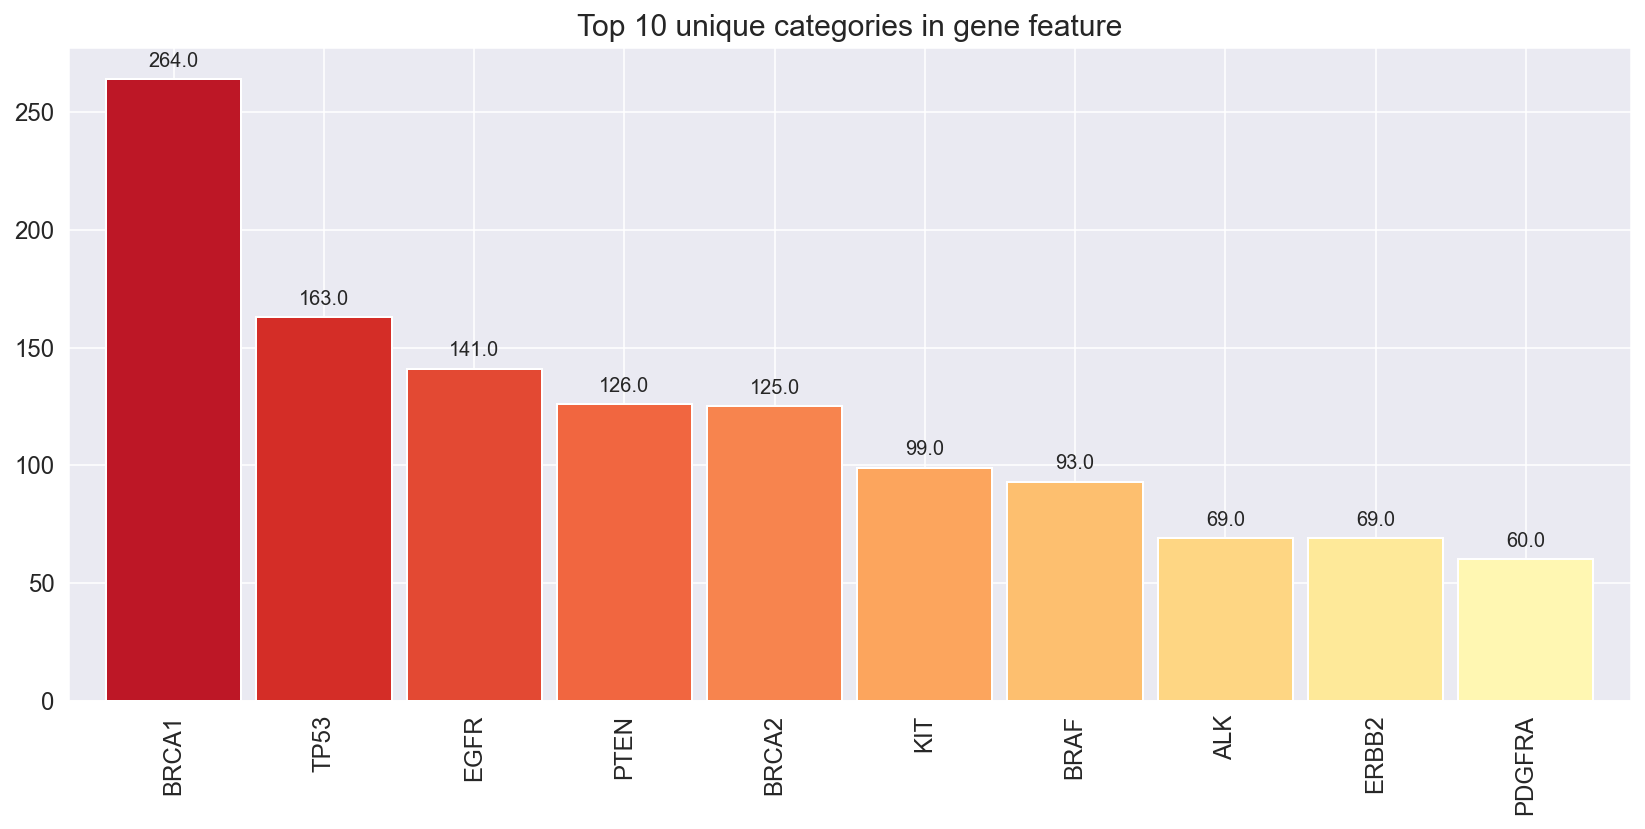

In [4]:
print(f"{len(data['Gene'].unique())} unique category in Gene feature")

plt.subplots(figsize=(14, 6))
ax = data['Gene'].value_counts().sort_values(ascending=False)[:10].plot.bar(
     width=0.9, color=sns.color_palette('RdYlGn', 20))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title("Top 10 unique categories in gene feature")
plt.show()

2996 unique category in variance feature


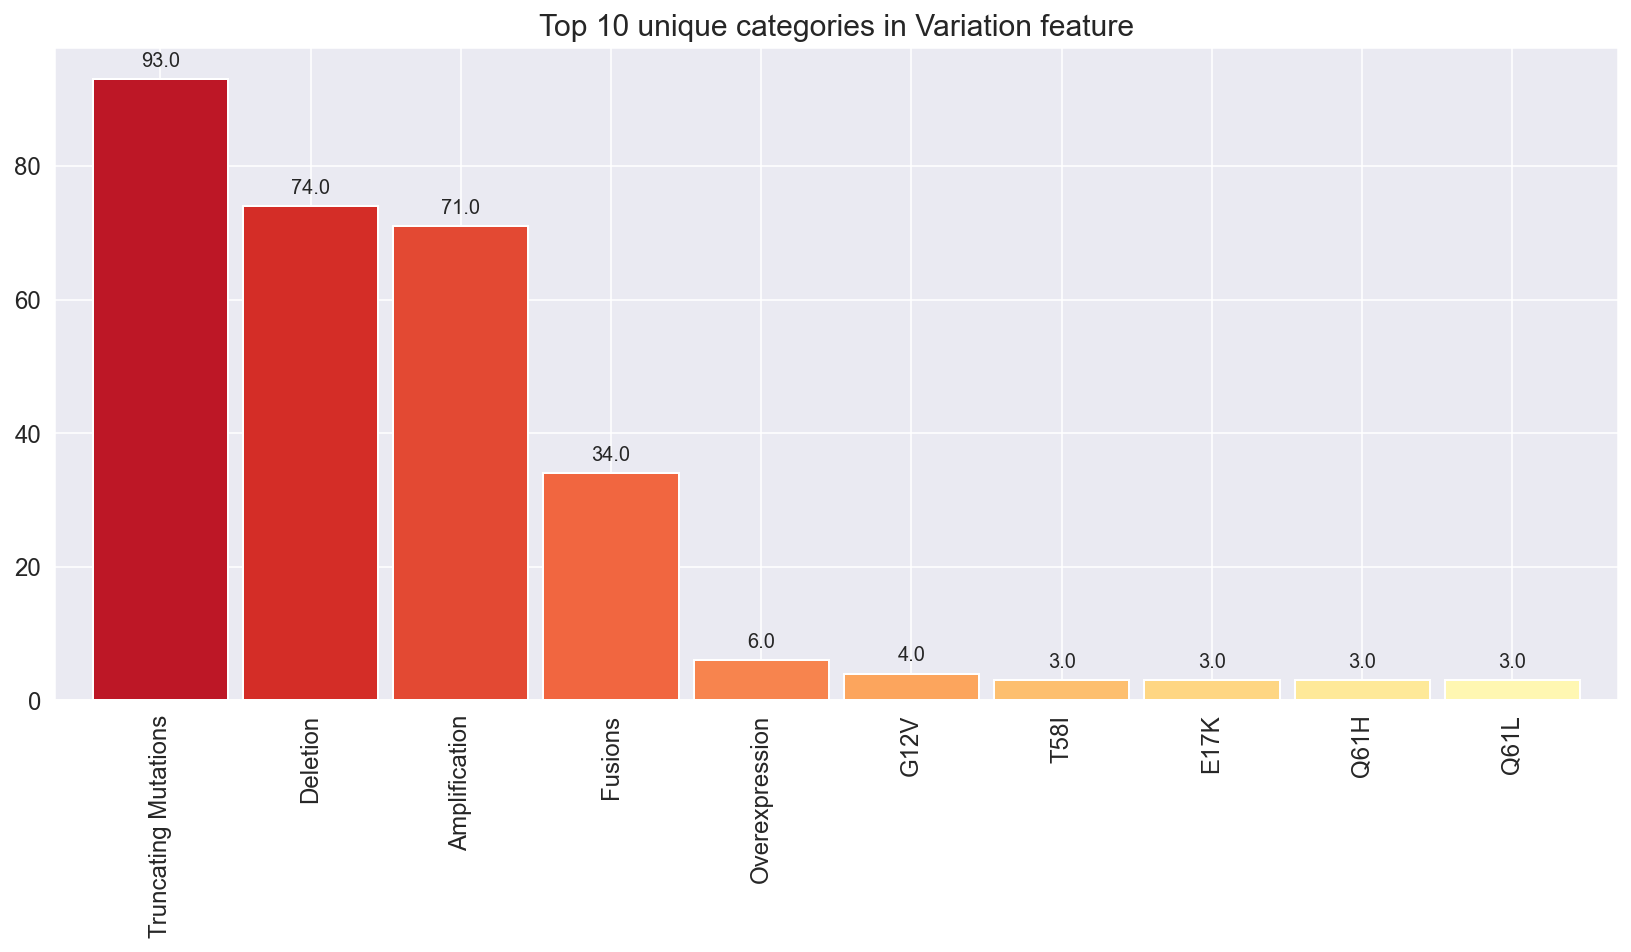

In [5]:
print(f"{len(data['Variation'].unique())} unique category in variance feature")

plt.subplots(figsize=(14, 6))
ax = data['Variation'].value_counts().sort_values(ascending=False)[:10].plot.bar(
     width=0.9, color=sns.color_palette('RdYlGn', 20))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title("Top 10 unique categories in Variation feature")
plt.show()

### Let's see null values ?

In [6]:
data[data.isnull().any(1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

In [7]:
data.loc[data['TEXT'].isnull(), 'TEXT'] = data['Gene'] + " " + data['Variation']

In [8]:
data[data.ID == 1109]

ID   Gene Variation  Class          TEXT
1109  1109  FANCA    S1088F      1  FANCA S1088F

### Clean TEXT 

In [9]:
# loading stopwords from nltk library
stop_words = set(stopwords.words('english'))

def nlp_text_preprocessing(x):
    string = ""
    # Replace every special character with space
    x = re.sub('[^a-zA-Z0-9\n]', ' ', x)
    # Replace multiple space with single space
    x = re.sub('\s+', ' ', x)
    # replace all the capital latters into smaller letters
    x = x.lower()

    # removing all the stopwords from text
    for word in x.split():
        if not word in stop_words:
            string += word + " "

    x = string
    return x

In [10]:
for i in range(len(data['TEXT'])):
    data['TEXT'][i] = nlp_text_preprocessing(data['TEXT'][i])

In [11]:
data.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

### Splitting dataset into train, cross validation and test dataset's 

### (64:16:20)

In [75]:
y = data['Class'].values
data.Gene = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.2, stratify =y_train, random_state=1)

print(f"        Number of datapoints in training data : [{X_train.shape[0]}]")
print(f"Number of datapoints of cross validation data : [{X_cv.shape[0]}]")
print(f"            Number of datapoints in test data : [{X_test.shape[0]}]")

        Number of datapoints in training data : [2124]
Number of datapoints of cross validation data : [532]
            Number of datapoints in test data : [665]


#### Distributions of 'Class' in train, cv, test dataset's

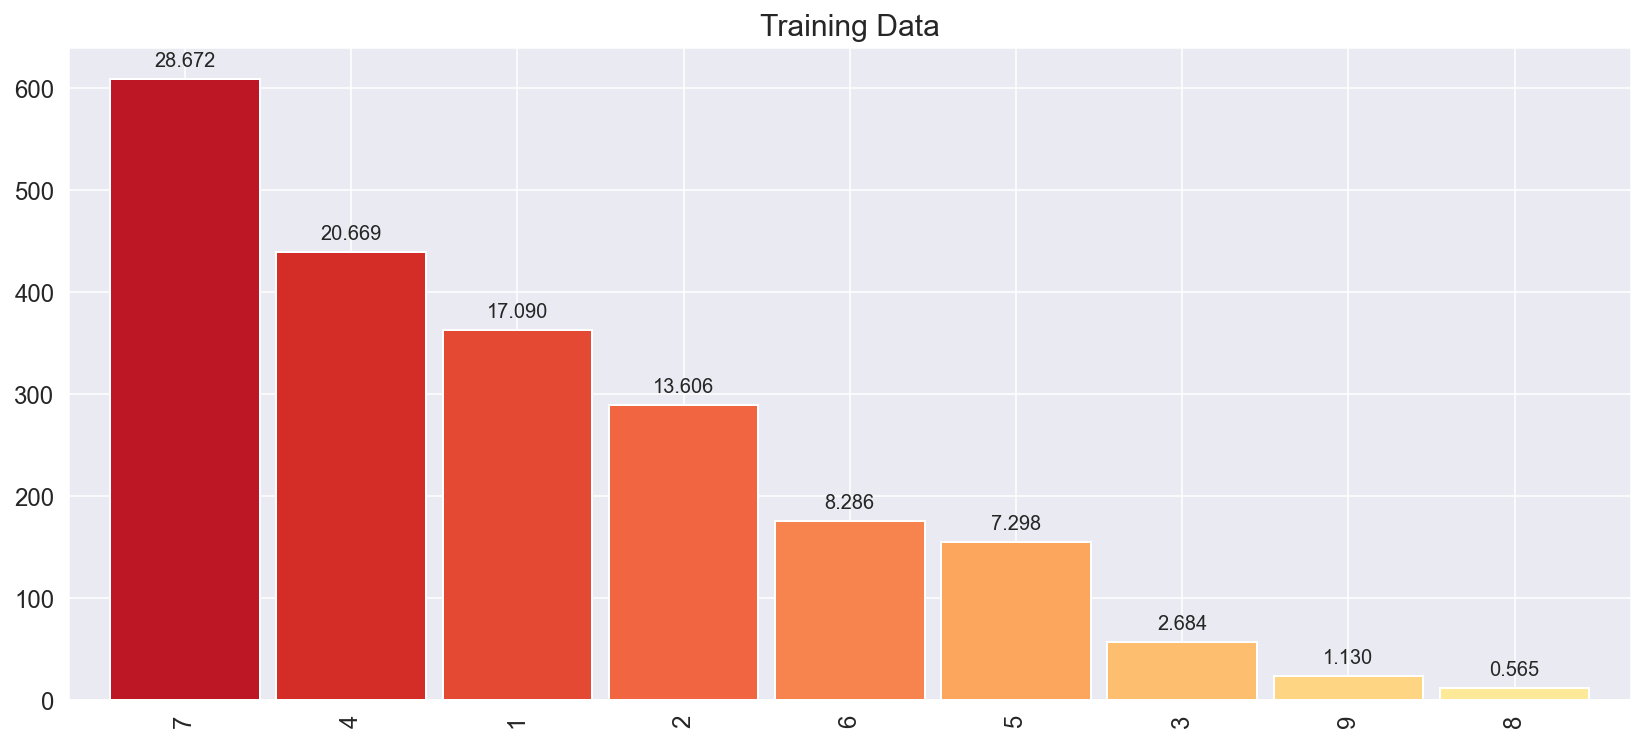

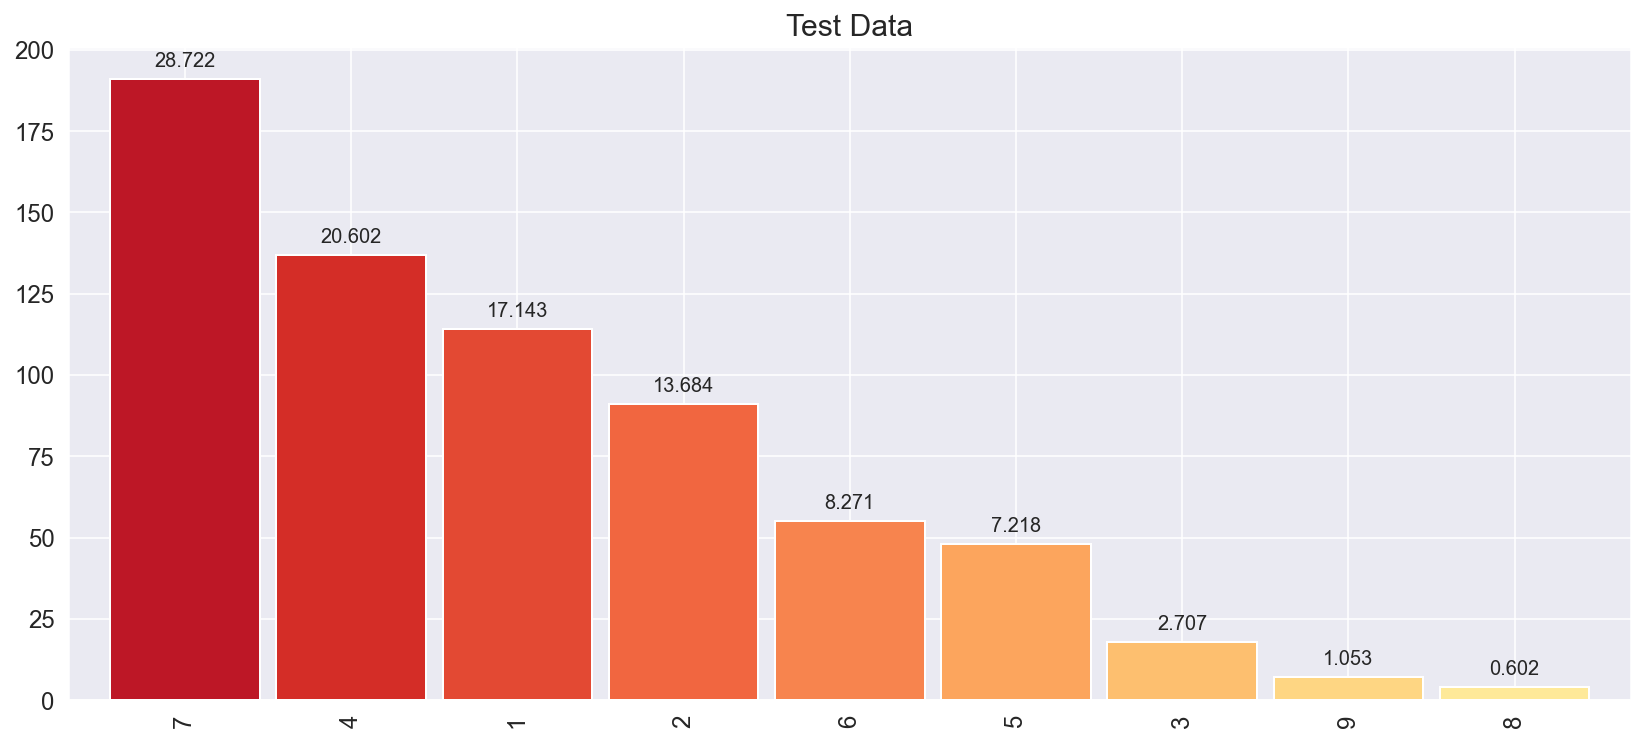

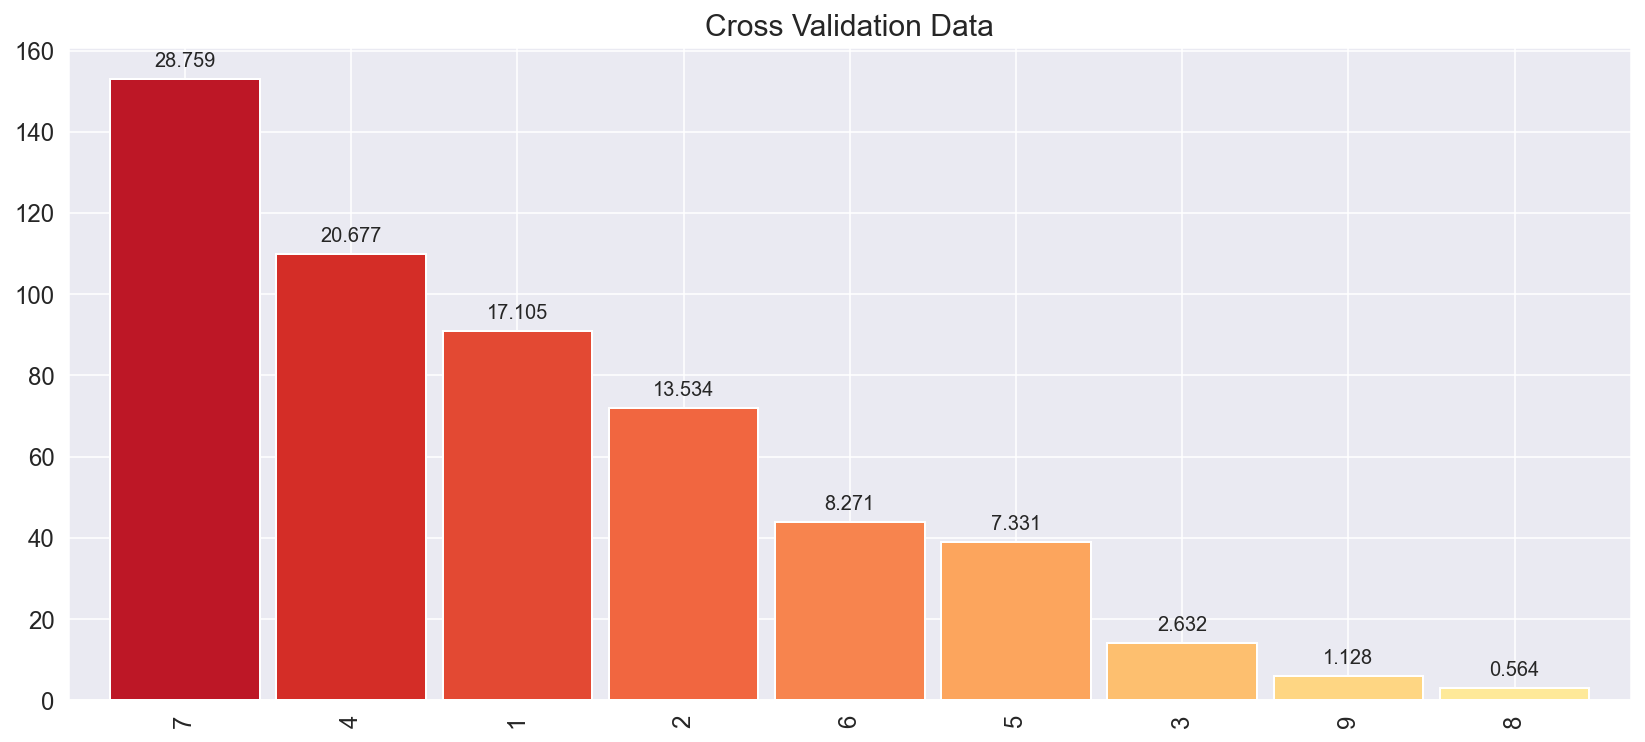

In [13]:
train_class_distribution = X_train['Class'].value_counts().sort_values(ascending=False)
test_class_distribution = X_test['Class'].value_counts().sort_values(ascending=False)
cv_class_distribution = X_cv['Class'].value_counts().sort_values(ascending=False)

plt.subplots(figsize=(14, 6))
ax = train_class_distribution.plot.bar(width=0.9, color=sns.color_palette('RdYlGn', 20))
sorted_yi = np.argsort(-train_class_distribution.values)
for p in ax.patches:
    ax.annotate(format((p.get_height()/X_train.shape[0]*100), '.3f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title("Training Data")

plt.subplots(figsize=(14, 6))
ax = test_class_distribution.plot.bar(width=0.9, color=sns.color_palette('RdYlGn', 20))
for p in ax.patches:
    ax.annotate(format((p.get_height()/X_test.shape[0]*100), '.3f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title("Test Data")

plt.subplots(figsize=(14, 6))
ax = cv_class_distribution.plot.bar(width=0.9, color=sns.color_palette('RdYlGn', 20))
for p in ax.patches:
    ax.annotate(format((p.get_height()/X_cv.shape[0]*100), '.3f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title("Cross Validation Data")
plt.show()

- It is a multi class classification problem.
- Distribution of all the classes in train, test and cross validate dataset is almost same.Which is good sign for us.
- Class 7, 4 and 1 are the majority classes.
- Class 3, 9 and have very low data points associated with them.

### Predicting using "Random Model"

In a random model we generate the NINE (9) class probability randomly such that they sum to 1

In [14]:
def plot_confusion_matrix(y_test, y_pred):
    # C will be a 9x9 matrix, each cell represents number of 
    # points of class i and predicted class j
    C = confusion_matrix(y_test, y_pred)
    
    # precision matrix : Divide each element of the confusion matrix with the sum
    # of element in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    
    # C.T = [[1, 3],
    #        [2, 4]]
    
    # C.sum(axis = 1) ; axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]
    A = ((C.T / C.sum(axis = 1)).T)
        
    # Recall Matrix : divid each element of the confusion matrix with the sum of
    # elements in that row
    
    # C = [[1, 2],
    #     [3, 4]]
    
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    B = ((C / C.sum(axis = 0)))
    
    labels = [1, 2, 3, 4, 5, 6, 7 , 8, 9]
    
    plt.figure(figsize = (20, 7))
    cmap = sns.diverging_palette(250, 15, 30, as_cmap=True)
    sns.heatmap(C, annot = True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize=18)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()
    
    plt.figure(figsize = (20, 7))
    cmap = sns.diverging_palette(250, 15, 30, as_cmap=True)
    sns.heatmap(B, annot = True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize=18)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()
    
    plt.figure(figsize = (20, 7))
    cmap = sns.diverging_palette(250, 15, 30, as_cmap=True)
    sns.heatmap(A, annot = True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize=18)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()

[Random Model] cv log loss is   (2.488922651268465
[Random Model] test log loss is (2.4357052598076807)


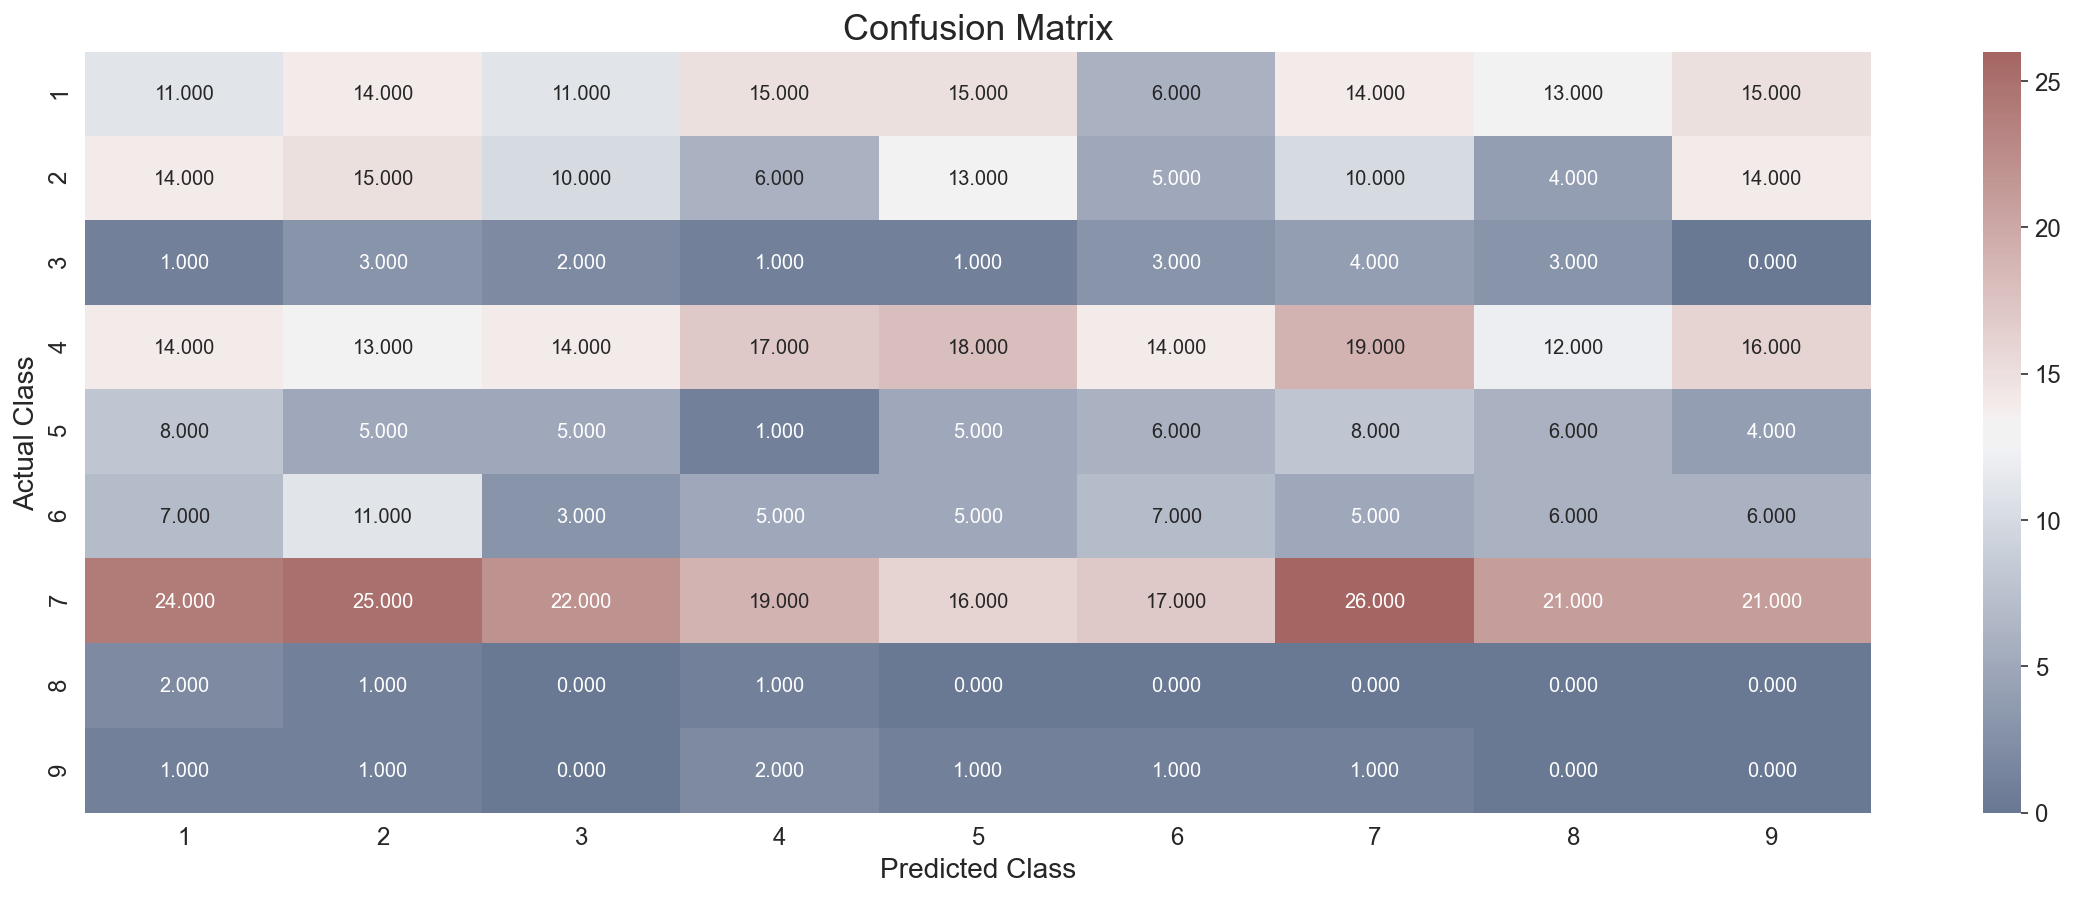

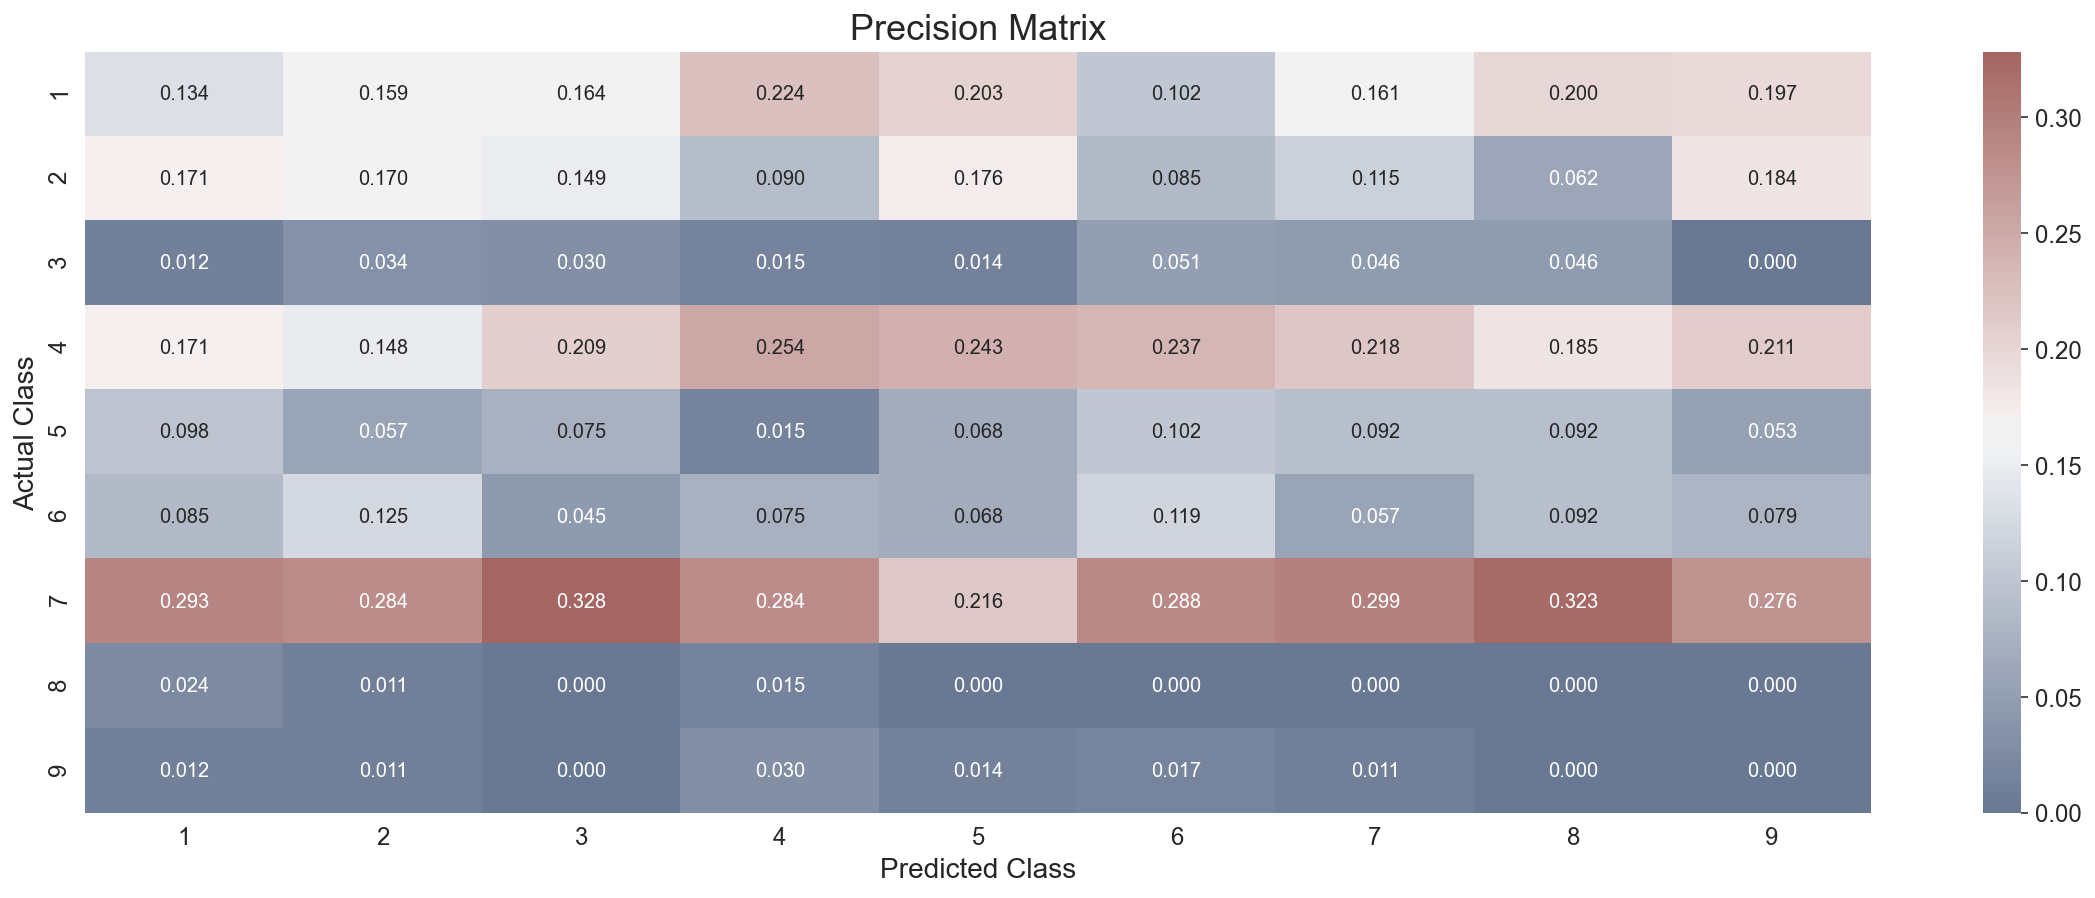

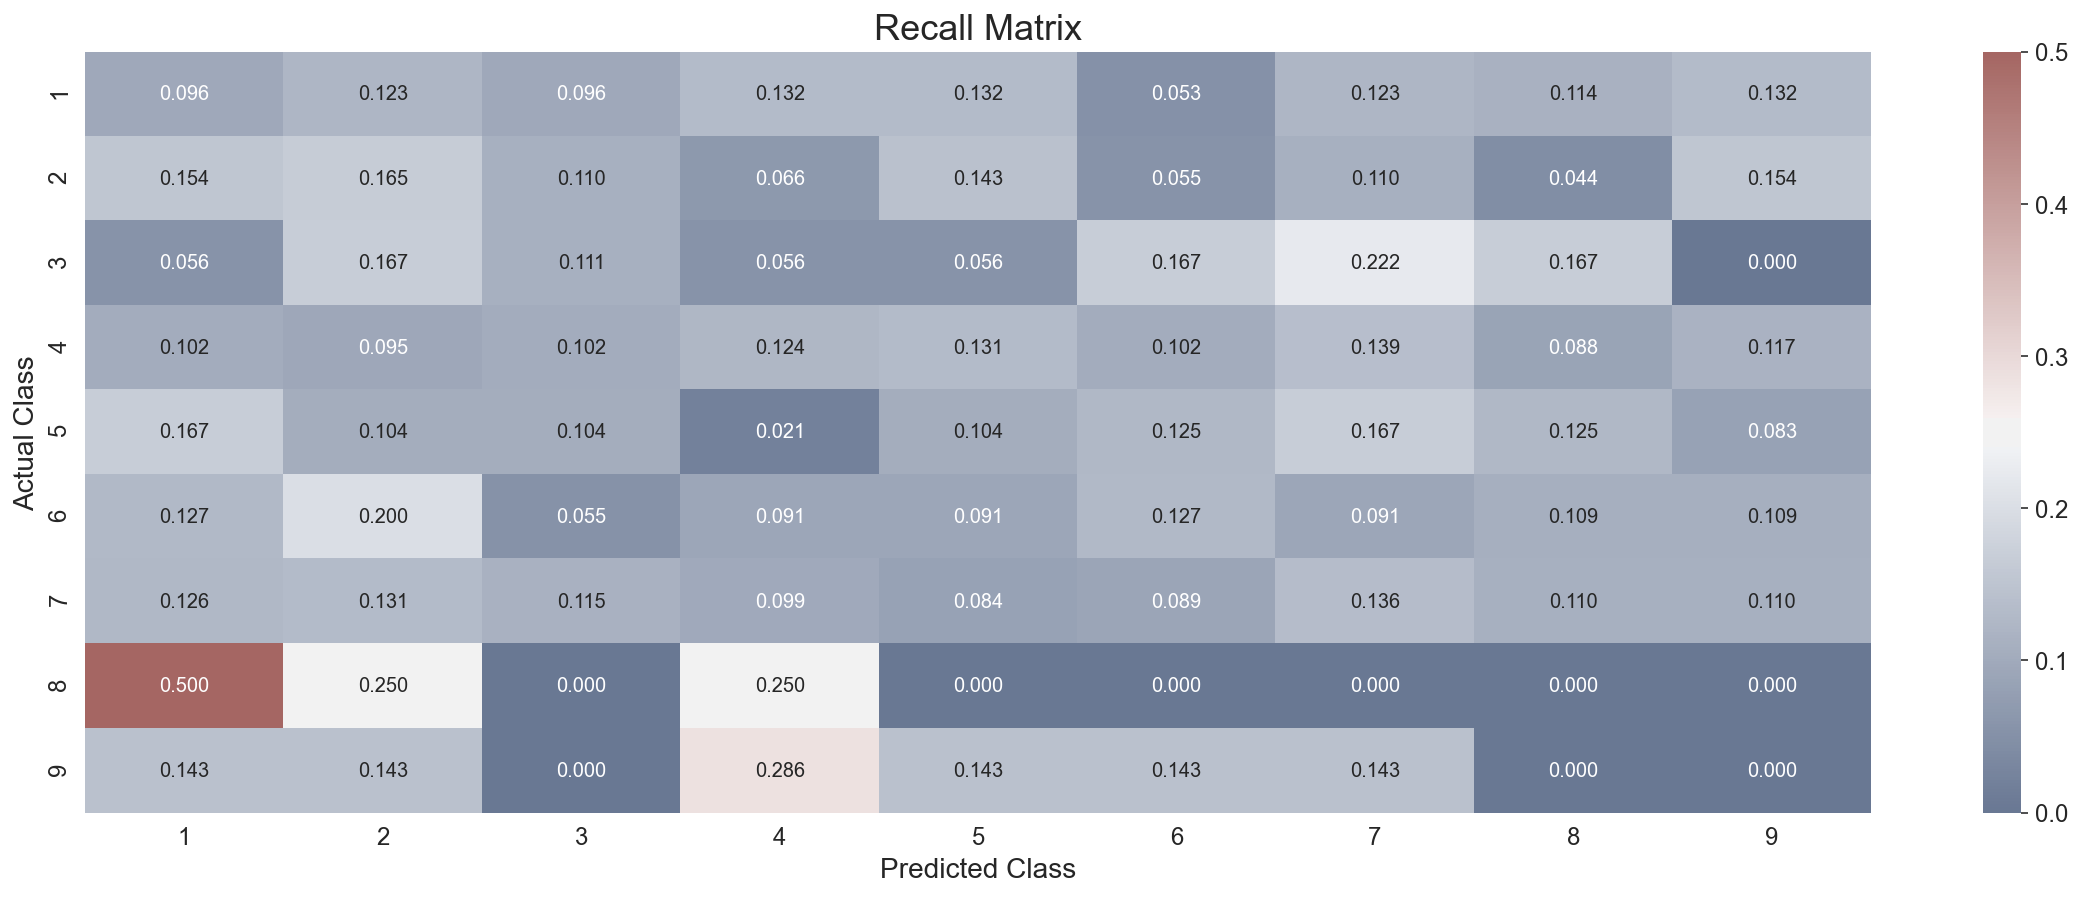

In [15]:
# we need to generate 9 numbers such that sum of all the numbe will be equals to 1..
# one solution : geenerate 9 numbers and divide each of thee number by their sum

test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# On cross validation data
# we create a output array that has exaclty same size as the CV data
y_cv_pred = np.zeros((cv_data_len, 9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1, 9)
    y_cv_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print(f"[Random Model] cv log loss is   ({log_loss(y_cv, y_cv_pred, eps=1e-15)}")

# On test data
y_test_pred = np.zeros((test_data_len, 9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1, 9)
    y_test_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print(f"[Random Model] test log loss is ({log_loss(y_test, y_test_pred, eps=1e-15)})")

y_predicted = np.argmax(y_test_pred, axis = 1)
plot_confusion_matrix(y_test, y_predicted + 1)

Log loss on cross validation and test dataset is roughly equals to 2.5 when we used random model which means this log-loss can be the worst case.
we know minimum value of log-loss is 0 and maximum can be tends to infinity, means log-loss value on cv and test data on a reasonable model will be in between the range of 0 and 2.5 or in other words we can say that log-loss should be less than 2.5 for a reasonable model.

### Categorical Feature Encoding 

In [16]:
data[["Gene", "Variation"]].head()

Gene             Variation
0  FAM58A  Truncating_Mutations
1     CBL                 W802*
2     CBL                 Q249E
3     CBL                 N454D
4     CBL                 L399V

Feature **Gene**:
    
    - Gene feature contains [264] unique categories.
    
Feature **Variation**:
    
    - Variation Feature contain [2996] unique categories.


In [206]:
# Response Encoding
def get_gv_feat_dict(alpha, feature, data):
    """
    1. Consider all unique values of a feature and occurance of every value
    2. Build a vector (1*9), ith element = (# occurance of value in class i + alpha*10) / (# ocurance of value in whole data + 90*alpha)
    3. gv_dict : Is like a look up table contains, for every category it store (1*9) vector representation 
    return : gv_dict
    """
    value_count = X_train[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1, 10):
            cls_cnt = X_train.loc[(data['Class'] == k) & (X_train[feature] == i)]
            vec.append((cls_cnt.shape[0] + alpha*10) / (denominator + 90*alpha))
        gv_dict[i] = vec
    return gv_dict

def get_gv_feature(alpha, feature, data):
    """
    For a value of feature in df
    if it is in train data:
    we add the vector that was stored in gv_dict to gv_feat
    else we add 1/9 to every cell of (1*9) vector
    return : gv_feat
    """
    gv_dict = get_gv_feat_dict(alpha, feature, data)
    value_count = X_train[feature].value_counts()
    gv_feat = []
    
    for index, row in data.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_feat.append(gv_dict[row[feature]])
        else:
            gv_feat.append([[1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9]])
    return gv_feat

#https://stackoverflow.com/a/1602964
def get_text_responsecoding(data):
    text_feature_responsecoding = np.zeros((data.shape[0], 9))
    for i in range(0, 9):
        row_index = 0
        for index, row in data.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responsecoding

In [203]:
alpha = 1

train_gene_responsecoding = np.array(get_gv_feature(alpha, 'Gene', X_train))
test_gene_responsecoding = np.array(get_gv_feature(alpha, 'Gene', X_test))
cv_gene_responsecoding = np.array(get_gv_feature(alpha, 'Gene', X_cv))
print("OK")

OK


In [204]:
train_var_responsecoding = np.array(get_gv_feature(alpha, 'Variation', X_train))
test_var_responsecoding = np.array(get_gv_feature(alpha, 'Variation', X_test))
cv_var_responsecoding = np.array(get_gv_feature(alpha, 'Variation', X_cv))
print("OK")

OK


In [179]:
# one hot encode
gene_vectorizer = CountVectorizer()
train_gene_one_hot_encode = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_one_hot_encode = gene_vectorizer.transform(X_test['Gene'])
cv_gene_one_hot_encode = gene_vectorizer.transform(X_cv['Gene'])

variation_vectorizer = CountVectorizer()
train_variation_one_hot_encode = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_one_hot_encode = variation_vectorizer.transform(X_test['Variation'])
cv_variation_one_hot_encode = variation_vectorizer.transform(X_cv['Variation'])


# KDD orange (a simple extention of one hot encoding)
def kdd_ohe_ok(data, feature):
    kdd_one_hot_encode = pd.DataFrame()  
    top_labels = [x for x in data[feature].value_counts().sort_values(ascending=False).head(10).index]
    for label in top_labels:
        kdd_one_hot_encode[feature+'_'+label] = np.where(data[feature] == label, 1, 0)
    return kdd_one_hot_encode

train_kdd_gene_one_hot_encode = kdd_ohe_ok(X_train, 'Gene')
test_kdd_gene_one_hot_encode = kdd_ohe_ok(X_test, 'Gene')
cv_kdd_gene_one_hot_encode = kdd_ohe_ok(X_cv, 'Gene')

train_kdd_variation_one_hot_encode = kdd_ohe_ok(X_train, 'Variation')
test_kdd_variation_one_hot_encode = kdd_ohe_ok(X_test, 'Variation')
tcv_kdd_variation_one_hot_encode = kdd_ohe_ok(X_cv, 'Variation')


# Mean Encoding
train_gene_mean_encode = pd.DataFrame()
test_gene_mean_encode = pd.DataFrame()
cv_gene_mean_encode = pd.DataFrame()
train_variation_mean_encode = pd.DataFrame()
test_variation_mean_encode = pd.DataFrame()
cv_variation_mean_encode = pd.DataFrame()

train_gene_dict_values = X_train.groupby(['Gene'])['Class'].mean().to_dict()
test_gene_dict_values = X_test.groupby(['Gene'])['Class'].mean().to_dict()
cv_gene_dict_values = X_cv.groupby(['Gene'])['Class'].mean().to_dict()

train_gene_mean_encode['Gene'] = X_train['Gene'].map(train_gene_dict_values)
test_gene_mean_encode['Gene'] = X_test['Gene'].map(test_gene_dict_values)
cv_gene_mean_encode['Gene'] = X_cv['Gene'].map(cv_gene_dict_values)

train_variation_dict_values = X_train.groupby(['Variation'])['Class'].mean().to_dict()
test_variation_dict_values = X_test.groupby(['Variation'])['Class'].mean().to_dict()
cv_variation_dict_values = X_cv.groupby(['Variation'])['Class'].mean().to_dict()

train_variation_mean_encode['Variation'] = X_train['Variation'].map(train_variation_dict_values)
test_variation_mean_encode['Variation'] = X_test['Variation'].map(test_variation_dict_values)
cv_variation_mean_encode['Variation'] = X_cv['Variation'].map(cv_variation_dict_values)

# Count / Frequency encoding
train_gene_freq_encode = pd.DataFrame()
test_gene_freq_encode = pd.DataFrame()
cv_gene_freq_encode = pd.DataFrame()
train_variation_freq_encode = pd.DataFrame()
test_variation_freq_encode = pd.DataFrame()
cv_variation_freq_encode = pd.DataFrame()

train_gene_freq_count = X_train['Gene'].value_counts().to_dict()
test_gene_freq_count = X_test['Gene'].value_counts().to_dict()
cv_gene_freq_count = X_cv['Gene'].value_counts().to_dict()

train_gene_freq_encode['Gene'] = X_train['Gene'].map(gene_freq_count)
test_gene_freq_encode['Gene'] = X_test['Gene'].map(gene_freq_count)
cv_gene_freq_encode['Gene'] = X_cv['Gene'].map(gene_freq_count)

train_var_freq_count = X_train['Variation'].value_counts().to_dict()
test_var_freq_count = X_test['Variation'].value_counts().to_dict()
cv_var_freq_count = X_cv['Variation'].value_counts().to_dict()

train_variation_freq_encode['Variation'] = X_train['Variation'].map(var_freq_count)
test_variation_freq_encode['Variation'] = X_test['Variation'].map(var_freq_count)
cv_variation_freq_encode['Variation'] = X_cv['Variation'].map(var_freq_count)


    
Feature **TEXT**:

    - Text feature is a set of sequential words.

In [154]:
# Bag of words
text_vect_bow = CountVectorizer(min_df = 3)

train_text_bow = text_vect_bow.fit_transform(X_train['TEXT'])
test_text_bow = text_vect_bow.transform(X_test['TEXT'])
cv_text_bow = text_vect_bow.transform(X_cv['TEXT'])
print("BOW Done!")

train_text_bow = normalize(train_text_bow, axis=0)
test_text_bow = normalize(test_text_bow, axis=0)
cv_text_bow = normalize(cv_text_bow, axis=0)
print("Bag of words features for each dataset normalized!")

# getting all the feature names
train_text_bow_features = text_vect_bow.get_feature_names()
# this will sum every row and returns (1*number of features vector)
train_text_bow_count = train_text_bow.sum(axis=0).A1
print("Total Number of unique words in text data", len(train_text_bow_features))
print("="*40)

# bi-grmas bow
text_vect_bi = CountVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 3)

train_bi_text_bow = text_vect_bi.fit_transform(X_train['TEXT'])
test_bi_text_bow = text_vect_bi.transform(X_test['TEXT'])
cv_bi_text_bow = text_vect_bi.transform(X_cv['TEXT'])
print("Bi gram based BOW Done!")

train_text_bi_bow = normalize(train_bi_text_bow, axis=0)
test_text_bi_bow = normalize(test_bi_text_bow, axis=0)
cv_text_bi_bow = normalize(cv_bi_text_bow, axis=0)
print("Bi grams based BOW features for each dataset normalized!")
print("="*40)

# uni + bi grams bow
text_vect_uni_bi = CountVectorizer(ngram_range=(1, 2), min_df = 3)

train_uni_bi_text_bow = text_vect_uni_bi.fit_transform(X_train['TEXT'])
test_uni_bi_text_bow = text_vect_uni_bi.transform(X_test['TEXT'])
cv_uni_bi_text_bow = text_vect_uni_bi.transform(X_cv['TEXT'])
print("Unigrams + Bi grams based BOW Done!")

train_uni_bi_text_bow = normalize(train_uni_bi_text_bow, axis=0)
test_uni_bi_text_bow = normalize(test_uni_bi_text_bow, axis=0)
cv_uni_bi_text_bow = normalize(cv_uni_bi_text_bow, axis=0)
print("Uni+Bi grams based BOW features for each dataset normalized!")
print("="*40)

# tf-idf 
text_vect_tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=5)

train_text_tfidf = text_vect_tfidf.fit_transform(X_train['TEXT'])
test_text_tfidf = text_vect_tfidf.transform(X_test['TEXT'])
cv_text_tfidf = text_vect_tfidf.transform(X_cv['TEXT'])
print("Tf-idf Done!")

train_text_tfidf = normalize(train_text_tfidf, axis=0)
test_text_tfidf = normalize(test_text_tfidf, axis=0)
cv_text_tfidf = normalize(cv_text_tfidf, axis=0)
print("tf-idf features for each dataset normalized!")
print("="*40)

BOW Done!
Bag of words features for each dataset normalized!
Total Number of unique words in text data 53778
Bi gram based BOW Done!
Bi grams based BOW features for each dataset normalized!
Unigrams + Bi grams based BOW Done!
Uni+Bi grams based BOW features for each dataset normalized!
Tf-idf Done!
tf-idf features for each dataset normalized!


In [184]:
# Response Encoding

a = np.zeros((2222, 9))
a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Gene

Gene is a categorical feature having 229 unique categories.
I have used simple one hot encoding using countvectorizer for this instance, but i will try multiple vectorizer technique and 'll see how my model improves or not.

### How good ( gene ) feature predicting output class?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i

In [113]:
print("Simple Bag of Words!")
print("====================")
print(f"Shape of gene feature in [X_Train] {train_gene_one_hot_encode.shape}")
print(f"Shape of gene feature in [y_Train] {y_train.shape}")
print(f"Shape of gene feature in [Test]    {test_gene_one_hot_encode.shape}")
print(f"Shape of gene feature in [X_test]  {y_test.shape}")
print(f"Shape of gene feature in [CV]      {cv_gene_one_hot_encode.shape}")
print(f"Shape of gene feature in [X_cv]    {y_cv.shape}")

Simple Bag of Words!
Shape of gene feature in [X_Train] (2124, 235)
Shape of gene feature in [y_Train] (2124,)
Shape of gene feature in [Test]    (665, 235)
Shape of gene feature in [X_test]  (665,)
Shape of gene feature in [CV]      (532, 235)
Shape of gene feature in [X_cv]    (532,)


log_loss (1.2256266149214154) alpha [1e-05]
log_loss (1.1973138591188046) alpha [0.0001]
log_loss (1.2422405245032675) alpha [0.001]
log_loss (1.3438359137594669) alpha [0.01]
log_loss (1.4134270178790524) alpha [0.1]
log_loss (1.4523580339224043) alpha [1]


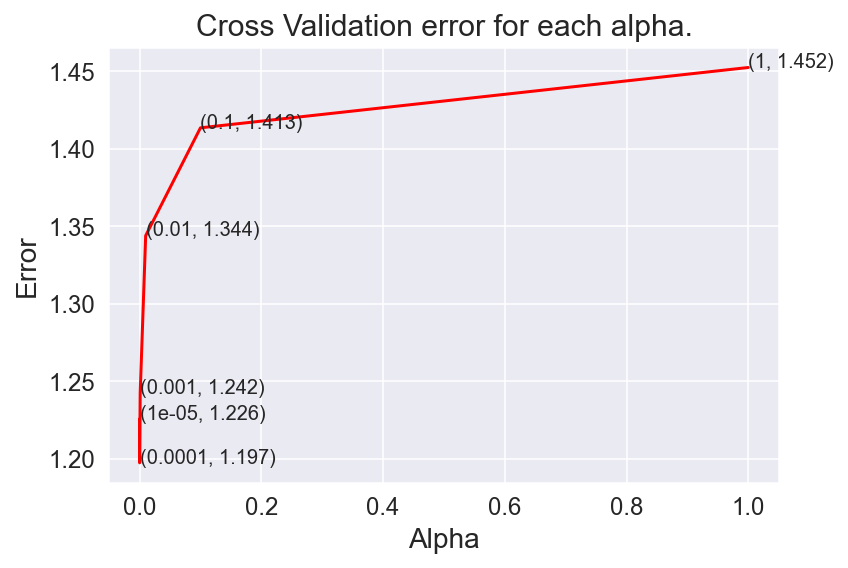

Best alpha is (0.0001)
[Train log_loss] 0.9832046778755618
[CV log_loss] 1.1973138591188046
[Test log_loss] 1.1894413460381446


In [116]:
# tunnning logistic regression on gene feature
alpha = [10**x for x in range(-5, 1)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, loss='log', penalty='l2', random_state=1)
    clf.fit(train_gene_one_hot_encode, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_gene_one_hot_encode, y_train)
    y_pred = sig_clf.predict_proba(cv_gene_one_hot_encode)
    cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print(f"log_loss ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{i}]")
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='r')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)),
                (alpha[i], cv_log_error[i]))
plt.title("Cross Validation error for each alpha.")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

best_alpha = np.argmin(cv_log_error)
print(f"Best alpha is ({alpha[best_alpha]})")
print("======================")
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1)
clf.fit(train_gene_one_hot_encode, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_gene_one_hot_encode, y_train)
y_pred = sig_clf.predict_proba(train_gene_one_hot_encode)
print(f"[Train log_loss] {log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(cv_gene_one_hot_encode)
print(f"[CV log_loss]    {log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(test_gene_one_hot_encode)
print(f"[Test log_loss]  {log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)}")

As we can see that cross validation and test log loss is better than my random model. that means this model can be useful for us.

### Is the gene feature is stable across all the dataset's?

In [134]:
print("How many data points in test and cv dataset's are covered by 229 genes in train dataset?")
print("")
test_coverage = X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage = X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print("In test data", test_coverage, 'out of', X_test.shape[0], "covered :", np.round((test_coverage/X_test.shape[0]),2)*100,"%")
print("In CV data", cv_coverage, 'out of', X_cv.shape[0], "covered :", np.round((cv_coverage/X_cv.shape[0]), 2)*100, "%")

How many data points in test and cv dataset's are covered by 229 genes in train dataset?

In test data 644 out of 665 covered : 97.0 %
In CV data 511 out of 532 covered : 96.0 %


## Variation

Variation is categorical features having 2996 unique categories.
I have used simple one hot encoding using countvectorizer for this instance, but i will try multiple vectorizer technique and 'll see how my model improves or not.

log_loss (1.726297993897468) alpha [1e-05]
log_loss (1.7187671494219425) alpha [0.0001]
log_loss (1.717418917719875) alpha [0.001]
log_loss (1.724747823872629) alpha [0.01]
log_loss (1.7361076613479218) alpha [0.1]
log_loss (1.7375757257020386) alpha [1]


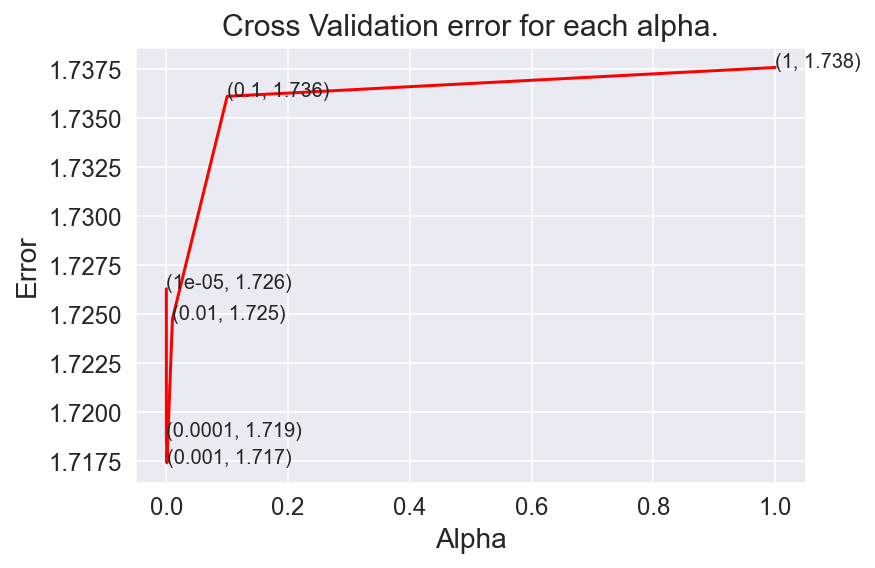

Best alpha is (0.001)
[Train log_loss] 1.0658028876470493
[CV log_loss]    1.717418917719875
[Test log_loss]  1.7060680299494018


In [139]:
# tunnning logistic regression on gene feature
alpha = [10**x for x in range(-5, 1)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, loss='log', penalty='l2', random_state=1)
    clf.fit(train_variation_one_hot_encode, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_variation_one_hot_encode, y_train)
    y_pred = sig_clf.predict_proba(cv_variation_one_hot_encode)
    cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print(f"log_loss ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{i}]")
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='r')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)),
                (alpha[i], cv_log_error[i]))
plt.title("Cross Validation error for each alpha.")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

best_alpha = np.argmin(cv_log_error)
print(f"Best alpha is ({alpha[best_alpha]})")
print("======================")
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1)
clf.fit(train_variation_one_hot_encode, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_variation_one_hot_encode, y_train)
y_pred = sig_clf.predict_proba(train_variation_one_hot_encode)
print(f"[Train log_loss] {log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(cv_variation_one_hot_encode)
print(f"[CV log_loss]    {log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(test_variation_one_hot_encode)
print(f"[Test log_loss]  {log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)}")

### Is the gene feature is stable across all the dataset's?

In [148]:
print("How many data points in test and cv dataset's are covered by 2996 varaince in train dataset?")
print("")
test_coverage = X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage = X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]

print("In test data", test_coverage, 'out of', X_test.shape[0], "covered :", np.round((test_coverage/X_test.shape[0]),2)*100,"%")
print("In CV data", cv_coverage, 'out of', X_cv.shape[0], "covered :", np.round((cv_coverage/X_cv.shape[0]), 2)*100, "%")

How many data points in test and cv dataset's are covered by 2996 varaince in train dataset?

In test data 61 out of 665 covered : 9.0 %
In CV data 58 out of 532 covered : 11.0 %


As we can clearly see that the difference between train and cross validation loss is more than gene feature. and it seem's that model is overfitting but
we can't say this directly.

log loss of train and cv better than my random model that means this feature 
is also useful for us to build the model.

## TEXT

Sequence of words, simple using bag of words for now, will try different vectorizer in future to test.

Number of unique words in training dataset is [53778]

log_loss (1.345083589319785) alpha [1e-05]
log_loss (1.1867828828111076) alpha [0.0001]
log_loss (1.1913393708905893) alpha [0.001]
log_loss (1.3451999722557444) alpha [0.01]
log_loss (1.4551230755718734) alpha [0.1]
log_loss (1.6345128083817566) alpha [1]


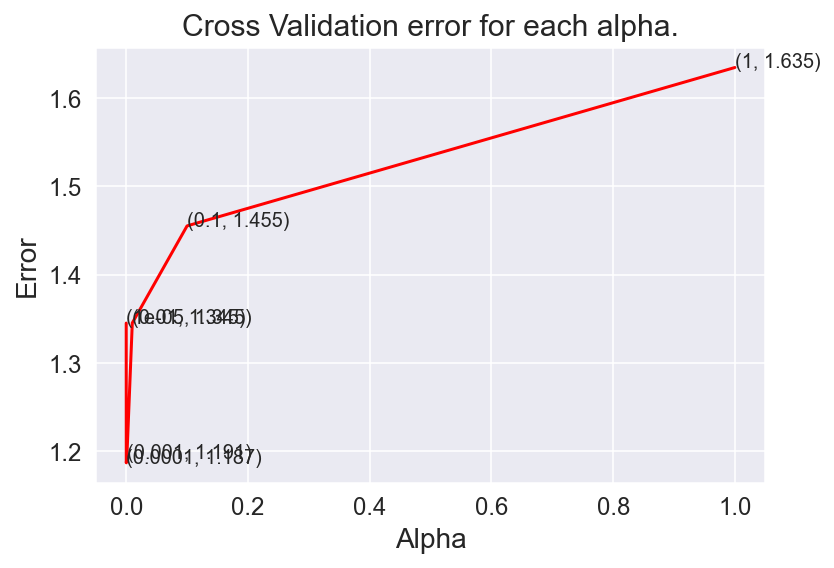

Best alpha is (0.0001)
[Train log_loss] 0.6692143813793385
[CV log_loss]    1.1867828828111076
[Test log_loss]  1.2085131844192978


In [160]:
# tunnning logistic regression on gene feature
alpha = [10**x for x in range(-5, 1)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, loss='log', penalty='l2', random_state=1)
    clf.fit(train_text_bow, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_text_bow, y_train)
    y_pred = sig_clf.predict_proba(cv_text_bow)
    cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print(f"log_loss ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{i}]")
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='r')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)),
                (alpha[i], cv_log_error[i]))
plt.title("Cross Validation error for each alpha.")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

best_alpha = np.argmin(cv_log_error)
print(f"Best alpha is ({alpha[best_alpha]})")
print("======================")
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1)
clf.fit(train_text_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_text_bow, y_train)
y_pred = sig_clf.predict_proba(train_text_bow)
print(f"[Train log_loss] {log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(cv_text_bow)
print(f"[CV log_loss]    {log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(test_text_bow)
print(f"[Test log_loss]  {log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)}")

By the common sense, that feature [TEXT] should be most useful feature in our dataset and that is.By seeing the score it is better than both gene and variation as well as very better than random model.

log_loss [1.7353409695009387] alpha [1e-05]
log_loss [1.7274886012514088] alpha [0.0001]
log_loss [1.7468827087352896] alpha [0.001]
log_loss [1.7818856399713965] alpha [0.01]
log_loss [1.8303536180980648] alpha [0.1]
log_loss [1.8303536157958085] alpha [1]
log_loss [1.830353615786093] alpha [10]
log_loss [1.830353615785909] alpha [100]
log_loss [1.8303536157858975] alpha [1000]


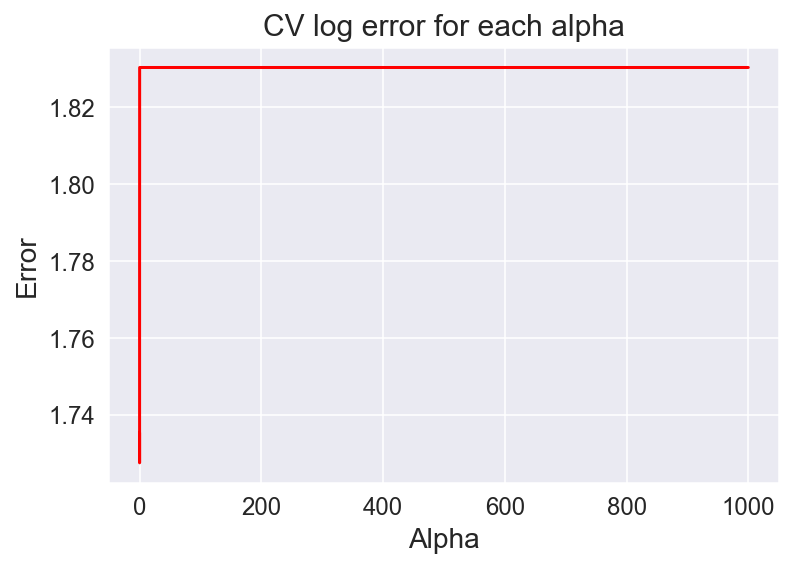

[Train log_loss] (0.5842907503256072)
[CV log_loss] (1.7296922265267307)
[TEst log_loss] (1.7166805021270048)


In [167]:
alpha = [10**x for x in range(-5, 4)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=1)
    clf.fit(train_variation_one_hot_encode, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_variation_one_hot_encode, y_train)
    y_pred = sig_clf.predict_proba(cv_variation_one_hot_encode)
    cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print(f"log_loss [{log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}] alpha [{i}]")
          
          
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='r')
plt.title("CV log error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()
          
best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='hinge', random_state=1)
clf.fit(train_variation_one_hot_encode, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_variation_one_hot_encode, y_train)
y_pred = sig_clf.predict_proba(train_variation_one_hot_encode)
print(f'[Train log_loss] ({log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)})')
y_pred = sig_clf.predict_proba(cv_variation_one_hot_encode)
print(f'[CV log_loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)})')
y_pred = sig_clf.predict_proba(test_variation_one_hot_encode)
print(f"[TEst log_loss] ({log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)})")

### Helper Functions for ML models

In [219]:
def predict_and_plot_confusion_matrix(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict(X_test)
    print(f"[Test Log loss] ({log_loss(y_test, sig_clf.predict_proba(X_test))})")
    print(f"Number of missclassified points : {np.count_nonzero((y_pred - y_test))/y_test.shape[0]}")
    plot_confusion_matrix(y_test, y_pred)
    
def report_log_loss(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifier(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_test)
    return log_loss(y_test, y_pred, eps=1e-15)

In [188]:
# this function will be used only for naive bayes
# for the given indices, we will print the name of feature
# and 'll check whether the feature present in text or not

def get_imp_feature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer()
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_vec.get_feature_names())
    
    word_present = 0
    for i, v in enumerate(indices):
        if v < feat1_len:
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "gene feature [{}] ppresent in test data point [{}]".format(word, yes_no))
        elif v < (fea1_len + fea2_len):
            word = var_vec.get_feature_names()[v - fea1_len]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word, yes_no))
        else:
            word = text_vec.get_feature_names()[v - (fea1_len + fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word, yes_no))
    print("Out of the top ", no_features, " features ", word_present, "are present in query point")    

## Stacking up three type of features

     TEXT      : BOW
     ===============
     Gene      : one hot encode, Responsecoing, kdd, mean, frequency
     variation : one hot encode, Responsecoing, kdd, mean, frequency
     

In [259]:
X_train_ohe_bow = hstack((train_gene_one_hot_encode, train_variation_one_hot_encode, train_text_bow)).tocsr()
X_test_ohe_bow = hstack((test_gene_one_hot_encode, test_variation_one_hot_encode, test_text_bow)).tocsr()
X_cv_ohe_bow = hstack((cv_gene_one_hot_encode, cv_variation_one_hot_encode, cv_text_bow)).tocsr()

X_train_kdd_bow = hstack((train_kdd_gene_one_hot_encode, train_kdd_variation_one_hot_encode, train_text_bow)).tocsr()
X_test_kdd_bow = hstack((test_kdd_gene_one_hot_encode, test_kdd_variation_one_hot_encode, test_text_bow)).tocsr()
X_cv_kdd_bow = hstack((cv_kdd_gene_one_hot_encode, tcv_kdd_variation_one_hot_encode, cv_text_bow)).tocsr()

X_train_mean_bow = hstack((train_gene_mean_encode, train_variation_mean_encode, train_text_bow)).tocsr()
X_test_mean_bow = hstack((test_gene_mean_encode, test_variation_mean_encode, test_text_bow)).tocsr()
X_cv_mean_bow = hstack((cv_gene_mean_encode, cv_variation_mean_encode, cv_text_bow)).tocsr()

X_train_freq_bow = hstack((train_gene_freq_encode, train_variation_freq_encode, train_text_bow)).tocsr()
X_test_freq_bow = hstack((test_gene_freq_encode, test_variation_freq_encode, test_text_bow)).tocsr()
X_cv_freq_bow = hstack((cv_gene_freq_encode, cv_variation_freq_encode, cv_text_bow)).tocsr()

     TEXT      : 2-gram based BOW
     ===============
     Gene      : one hot encode, Responsecoing, kdd, mean, frequency
     variation : one hot encode, Responsecoing, kdd, mean, frequency
     

In [260]:
X_train_ohe_bi = hstack((train_gene_one_hot_encode, train_variation_one_hot_encode, train_text_bi_bow)).tocsr()
X_test_ohe_bi = hstack((test_gene_one_hot_encode, test_variation_one_hot_encode, test_text_bi_bow)).tocsr()
X_cv_ohe_bi = hstack((cv_gene_one_hot_encode, cv_variation_one_hot_encode, cv_text_bi_bow)).tocsr()

X_train_kdd_bi = hstack((train_kdd_gene_one_hot_encode, train_kdd_variation_one_hot_encode, train_text_bi_bow)).tocsr()
X_test_kdd_bi = hstack((test_kdd_gene_one_hot_encode, test_kdd_variation_one_hot_encode, test_text_bi_bow)).tocsr()
X_cv_kdd_bi = hstack((cv_kdd_gene_one_hot_encode, tcv_kdd_variation_one_hot_encode, cv_text_bi_bow)).tocsr()

X_train_mean_bi = hstack((train_gene_mean_encode, train_variation_mean_encode, train_text_bi_bow)).tocsr()
X_test_mean_bi = hstack((test_gene_mean_encode, test_variation_mean_encode, test_text_bi_bow)).tocsr()
X_cv_mean_bi = hstack((cv_gene_mean_encode, cv_variation_mean_encode, cv_text_bi_bow)).tocsr()

X_train_freq_bi = hstack((train_gene_freq_encode, train_variation_freq_encode, train_text_bi_bow)).tocsr()
X_test_freq_bi = hstack((test_gene_freq_encode, test_variation_freq_encode, test_text_bi_bow)).tocsr()
X_cv_freq_bi = hstack((cv_gene_freq_encode, cv_variation_freq_encode, cv_text_bi_bow)).tocsr()

     TEXT      : uni+bi gram based BOW
     ===============
     Gene      : one hot encode, Responsecoing, kdd, mean, frequency
     variation : one hot encode, Responsecoing, kdd, mean, frequency
     

In [191]:
X_train_ohe_uni_bi = hstack((train_gene_one_hot_encode, train_variation_one_hot_encode, train_uni_bi_text_bow)).tocsr()
X_test_ohe_uni_bi = hstack((test_gene_one_hot_encode, test_variation_one_hot_encode, test_uni_bi_text_bow)).tocsr()
X_cv_ohe_uni_bi = hstack((cv_gene_one_hot_encode, cv_variation_one_hot_encode, cv_uni_bi_text_bow)).tocsr()

X_train_kdd_uni_bi = hstack((train_kdd_gene_one_hot_encode, train_kdd_variation_one_hot_encode, train_uni_bi_text_bow)).tocsr()
X_test_kdd_uni_bi = hstack((test_kdd_gene_one_hot_encode, test_kdd_variation_one_hot_encode, test_uni_bi_text_bow)).tocsr()
X_cv_kdd_uni_bi = hstack((cv_kdd_gene_one_hot_encode, tcv_kdd_variation_one_hot_encode, cv_uni_bi_text_bow)).tocsr()

X_train_mean_uni_bi = hstack((train_gene_mean_encode, train_variation_mean_encode, train_uni_bi_text_bow)).tocsr()
X_test_mean_uni_bi = hstack((test_gene_mean_encode, test_variation_mean_encode, test_uni_bi_text_bow)).tocsr()
X_cv_mean_uni_bi = hstack((cv_gene_mean_encode, cv_variation_mean_encode, cv_uni_bi_text_bow)).tocsr()

X_train_freq_uni_bi = hstack((train_gene_freq_encode, train_variation_freq_encode, train_uni_bi_text_bow)).tocsr()
X_test_freq_uni_bi = hstack((test_gene_freq_encode, test_variation_freq_encode, test_uni_bi_text_bow)).tocsr()
X_cv_freq_uni_bi = hstack((cv_gene_freq_encode, cv_variation_freq_encode, cv_uni_bi_text_bow)).tocsr()

     TEXT      : Tf-idf
     ==================
     Gene      : one hot encode, Responsecoing, kdd, mean, frequency
     variation : one hot encode, Responsecoing, kdd, mean, frequency
     

In [192]:
X_train_ohe_tfidf = hstack((train_gene_one_hot_encode, train_variation_one_hot_encode, train_text_tfidf)).tocsr()
X_test_ohe_tfidf = hstack((test_gene_one_hot_encode, test_variation_one_hot_encode, test_text_tfidf)).tocsr()
X_cv_ohe_tfidf = hstack((cv_gene_one_hot_encode, cv_variation_one_hot_encode, cv_text_tfidf)).tocsr()

X_train_kdd_tfidf = hstack((train_kdd_gene_one_hot_encode, train_kdd_variation_one_hot_encode, train_text_tfidf)).tocsr()
X_test_kdd_tfidf = hstack((test_kdd_gene_one_hot_encode, test_kdd_variation_one_hot_encode, test_text_tfidf)).tocsr()
X_cv_kdd_tfidf = hstack((cv_kdd_gene_one_hot_encode, tcv_kdd_variation_one_hot_encode, cv_text_tfidf)).tocsr()

X_train_mean_tfidf = hstack((train_gene_mean_encode, train_variation_mean_encode, train_text_tfidf)).tocsr()
X_test_mean_tfidf = hstack((test_gene_mean_encode, test_variation_mean_encode, test_text_tfidf)).tocsr()
X_cv_mean_tfidf = hstack((cv_gene_mean_encode, cv_variation_mean_encode, cv_text_tfidf)).tocsr()

X_train_freq_tfidf = hstack((train_gene_freq_encode, train_variation_freq_encode, train_text_tfidf)).tocsr()
X_test_freq_tfidf = hstack((test_gene_freq_encode, test_variation_freq_encode, test_text_tfidf)).tocsr()
X_cv_freq_tfidf = hstack((cv_gene_freq_encode, cv_variation_freq_encode, cv_text_tfidf)).tocsr()

## Model Building

### Baseline model : Naive Bayes

Gene : One hot encode
Variation : One hot encode
TEXT : BOW
[log_loss] (1.3308057554641957) alpha [1e-05]
[log_loss] (1.3300263984311003) alpha [0.0001]
[log_loss] (1.3230310017110363) alpha [0.001]
[log_loss] (1.320949816499768) alpha [0.01]
[log_loss] (1.3159897881356832) alpha [0.1]
[log_loss] (1.3298964895321972) alpha [1]
[log_loss] (1.4195560235282285) alpha [10]
[log_loss] (1.4243064663167042) alpha [100]
[log_loss] (1.3587559323469047) alpha [1000]


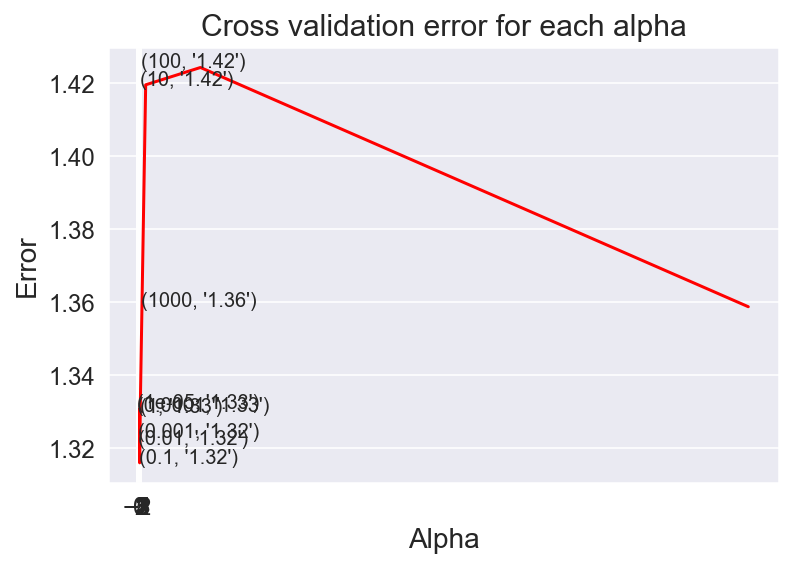

0
[ Best alpha : 0.1 ]
[Train loss] (0.8514224206640228)
[CV loss] (1.3159897881356832)
[Test loss] (1.3274722521687765)
[Test Log loss] (1.3274722521687765)
Number of missclassified points : 0.41353383458646614


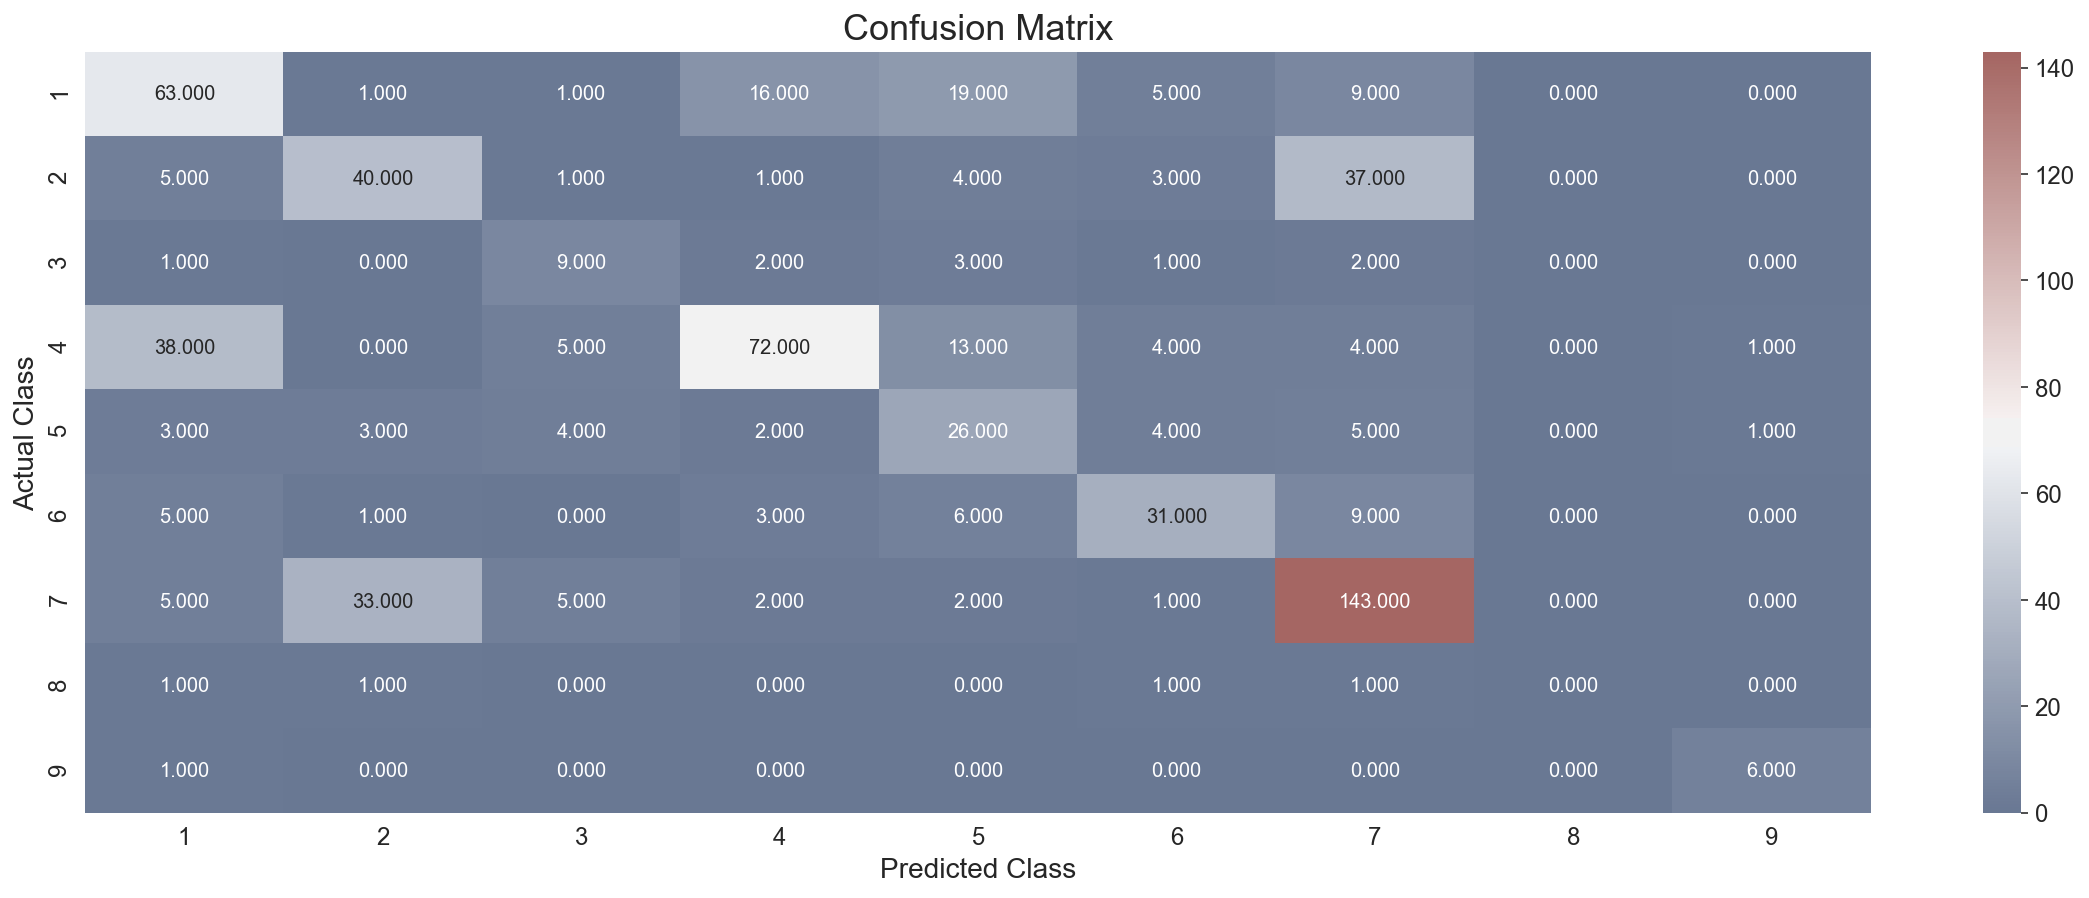

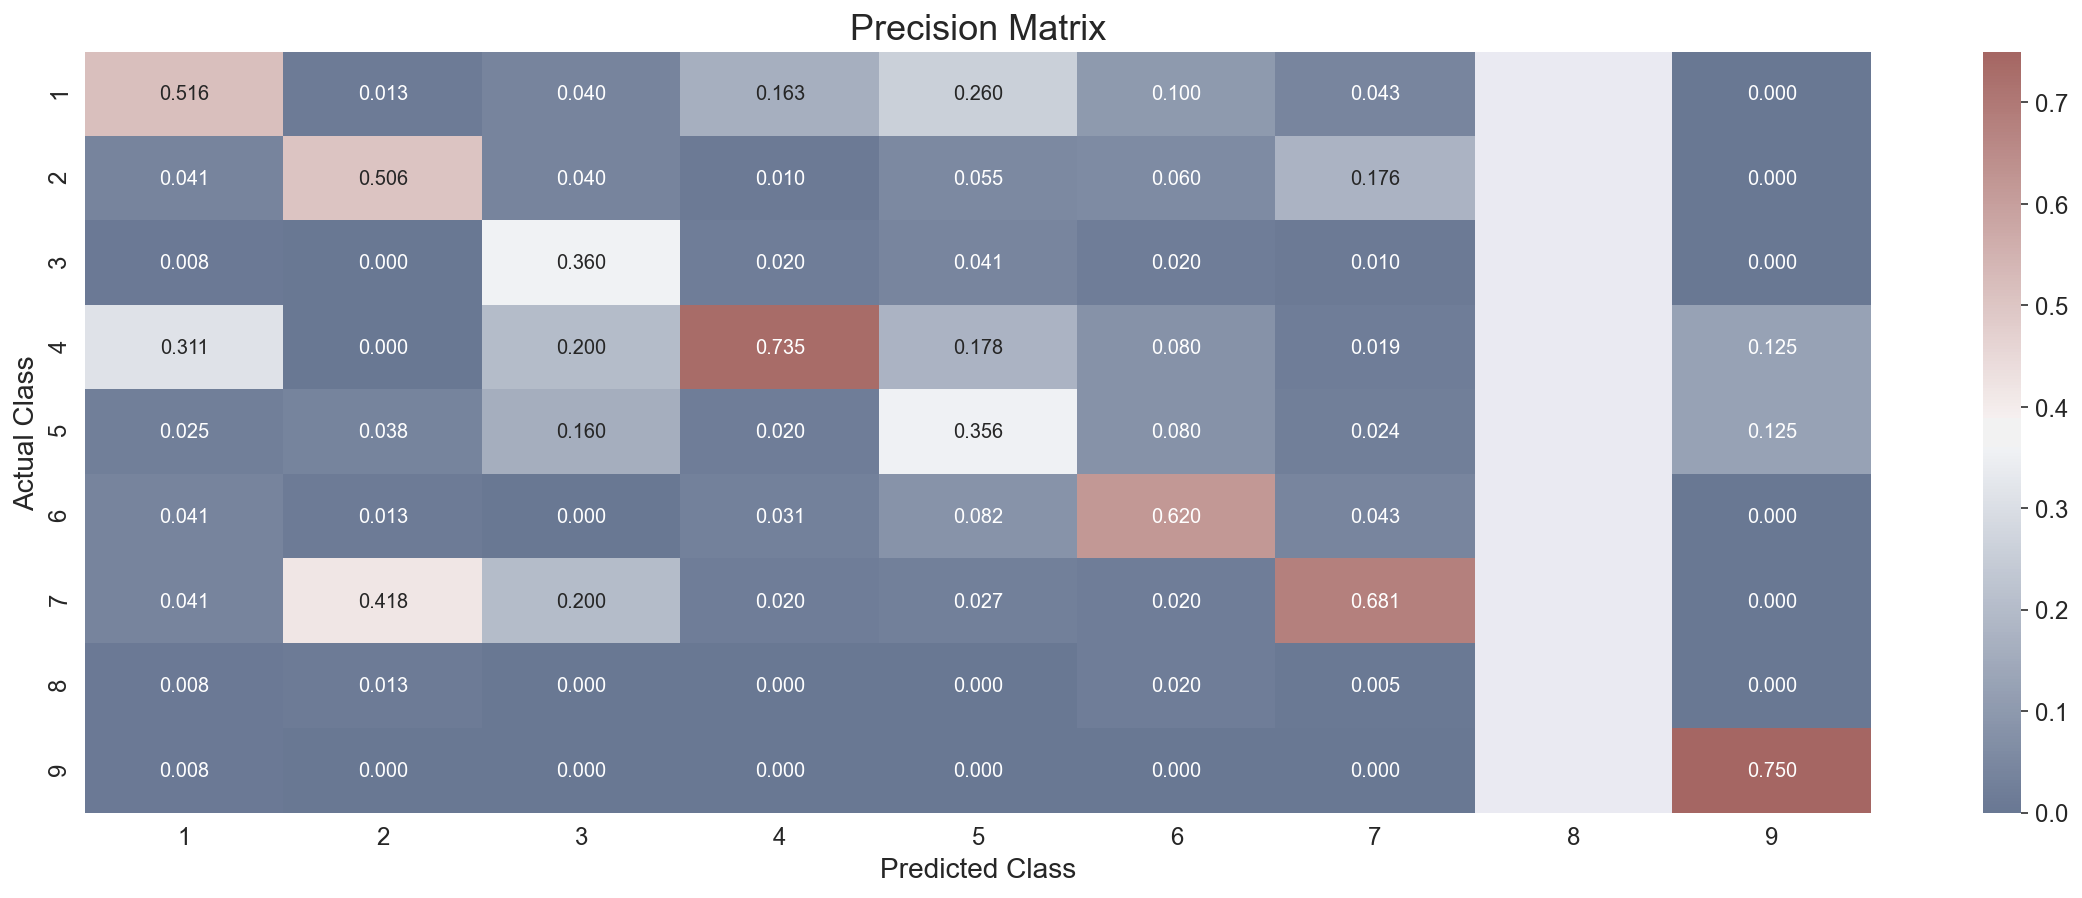

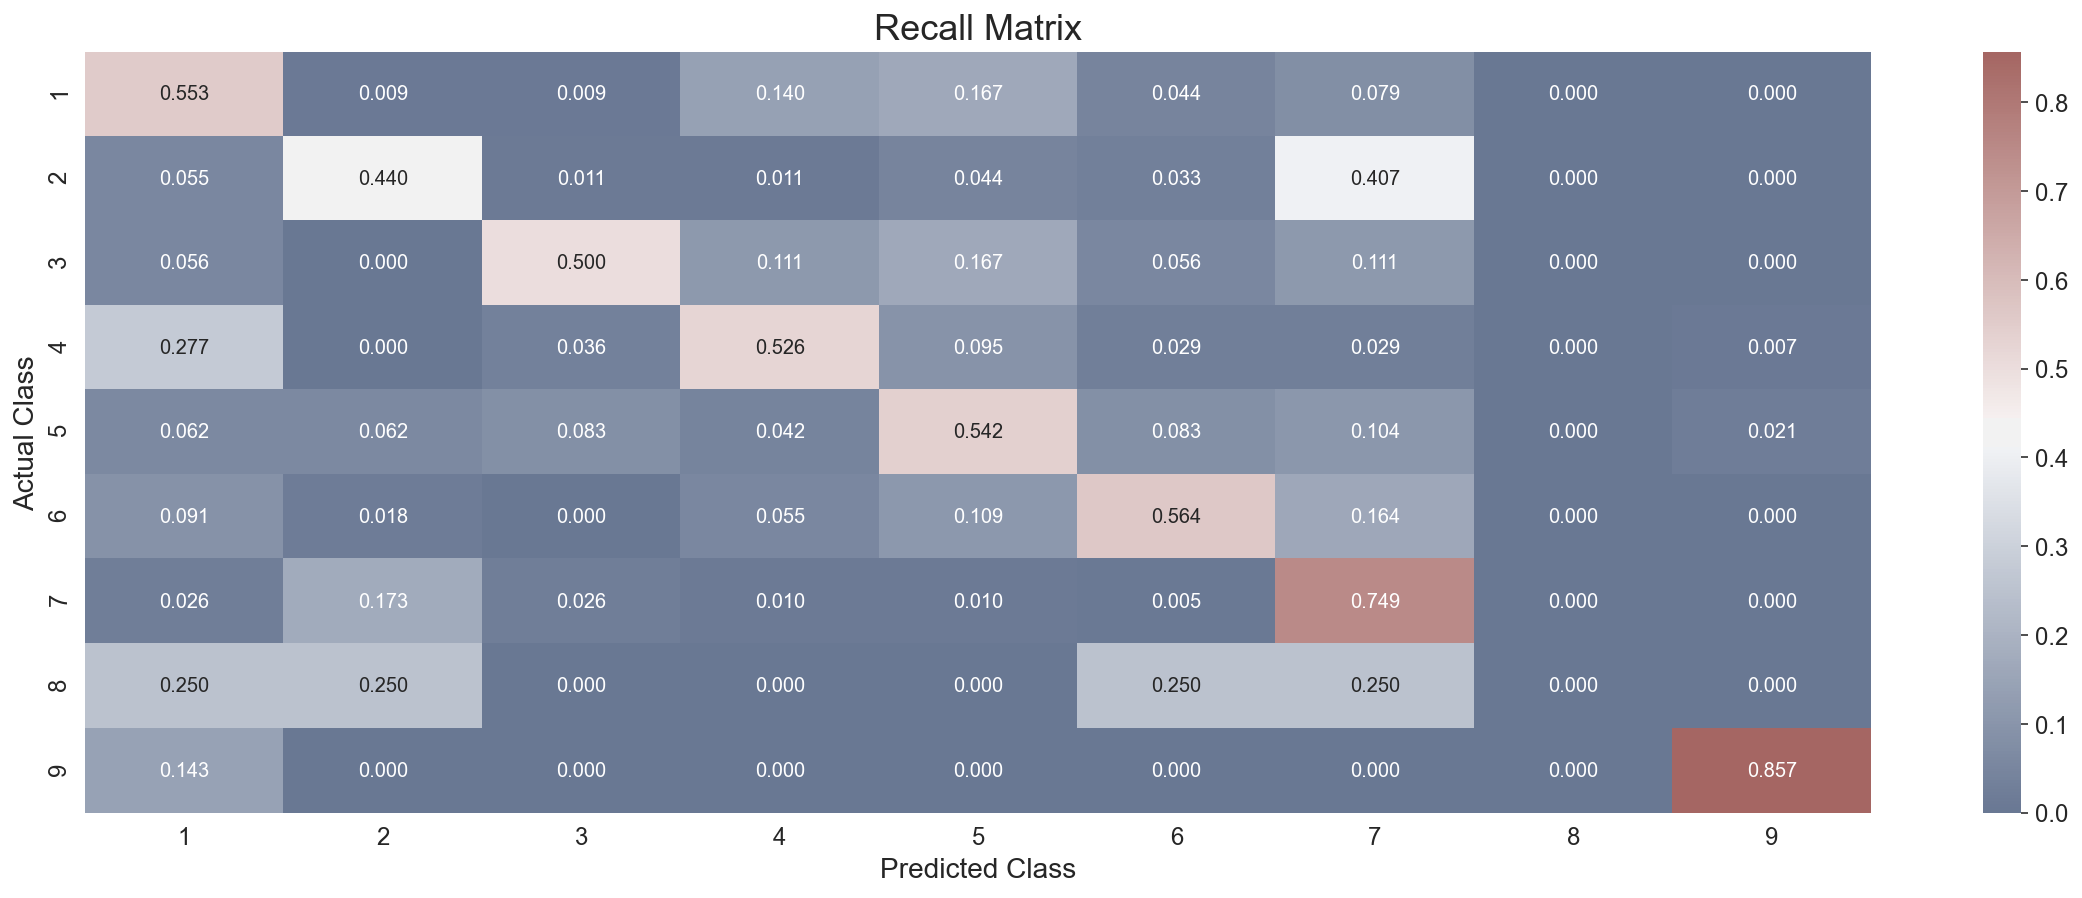

Gene : One hot encode
Variation : One hot encode
TEXT : Bi-gram
[log_loss] (1.3620054904580179) alpha [1e-05]
[log_loss] (1.3546375072985044) alpha [0.0001]
[log_loss] (1.3411575083070386) alpha [0.001]
[log_loss] (1.329604372209196) alpha [0.01]
[log_loss] (1.3263188277187088) alpha [0.1]
[log_loss] (1.3263809484313493) alpha [1]
[log_loss] (1.3404493103595583) alpha [10]
[log_loss] (1.319217055082986) alpha [100]
[log_loss] (1.2658883978986166) alpha [1000]


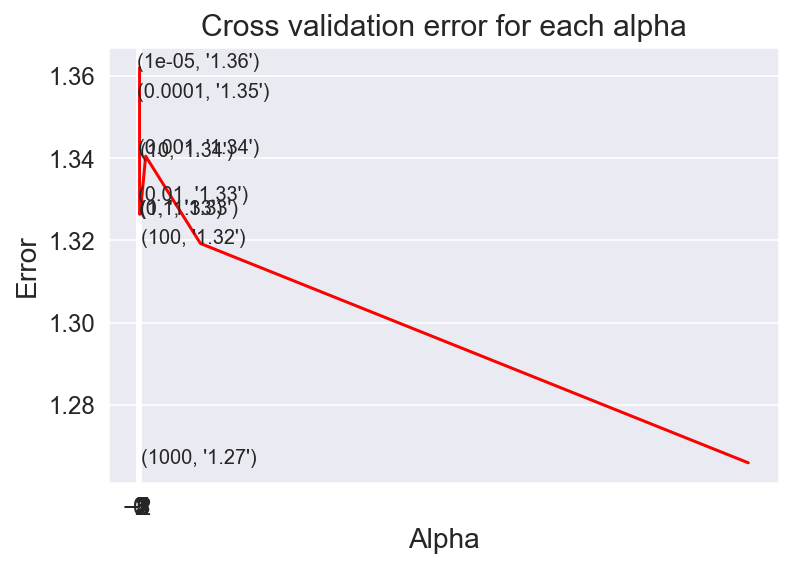

1
[ Best alpha : 1000 ]
[Train loss] (1.098475645657814)
[CV loss] (1.2658883978986166)
[Test loss] (1.2811719581821692)
[Test Log loss] (1.2811719581821692)
Number of missclassified points : 0.43007518796992483


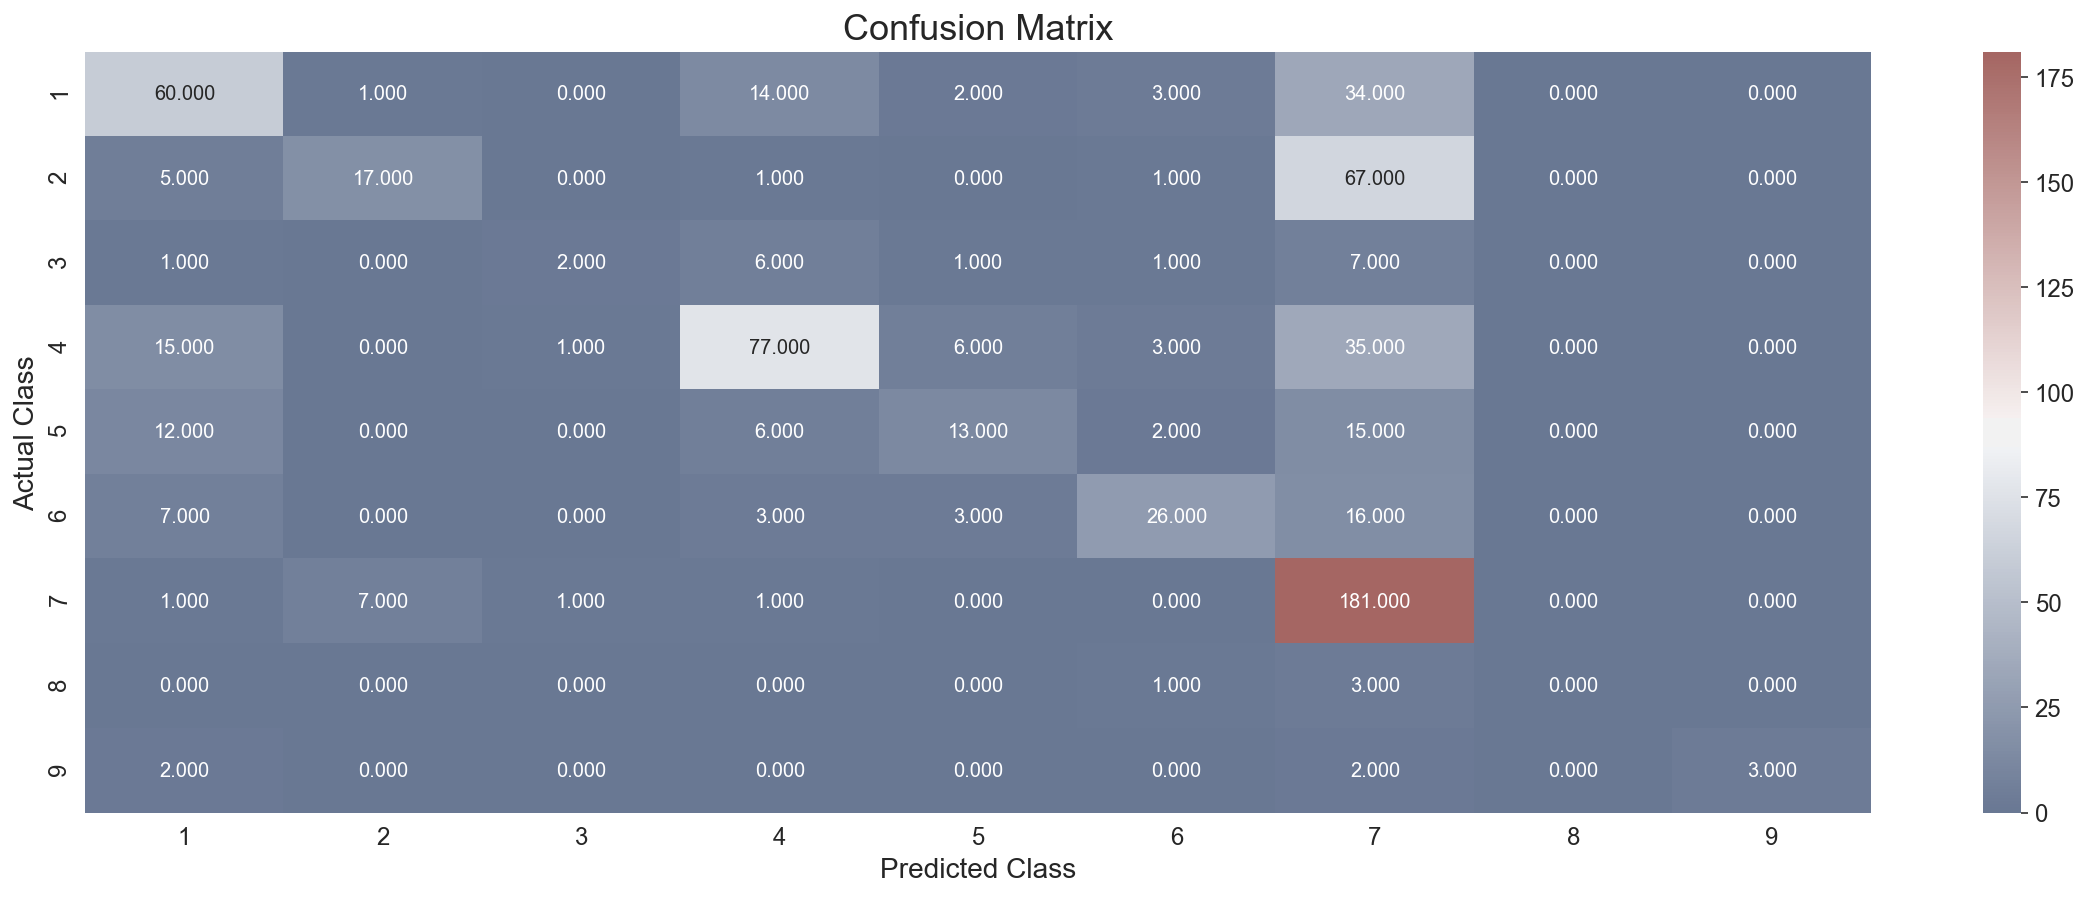

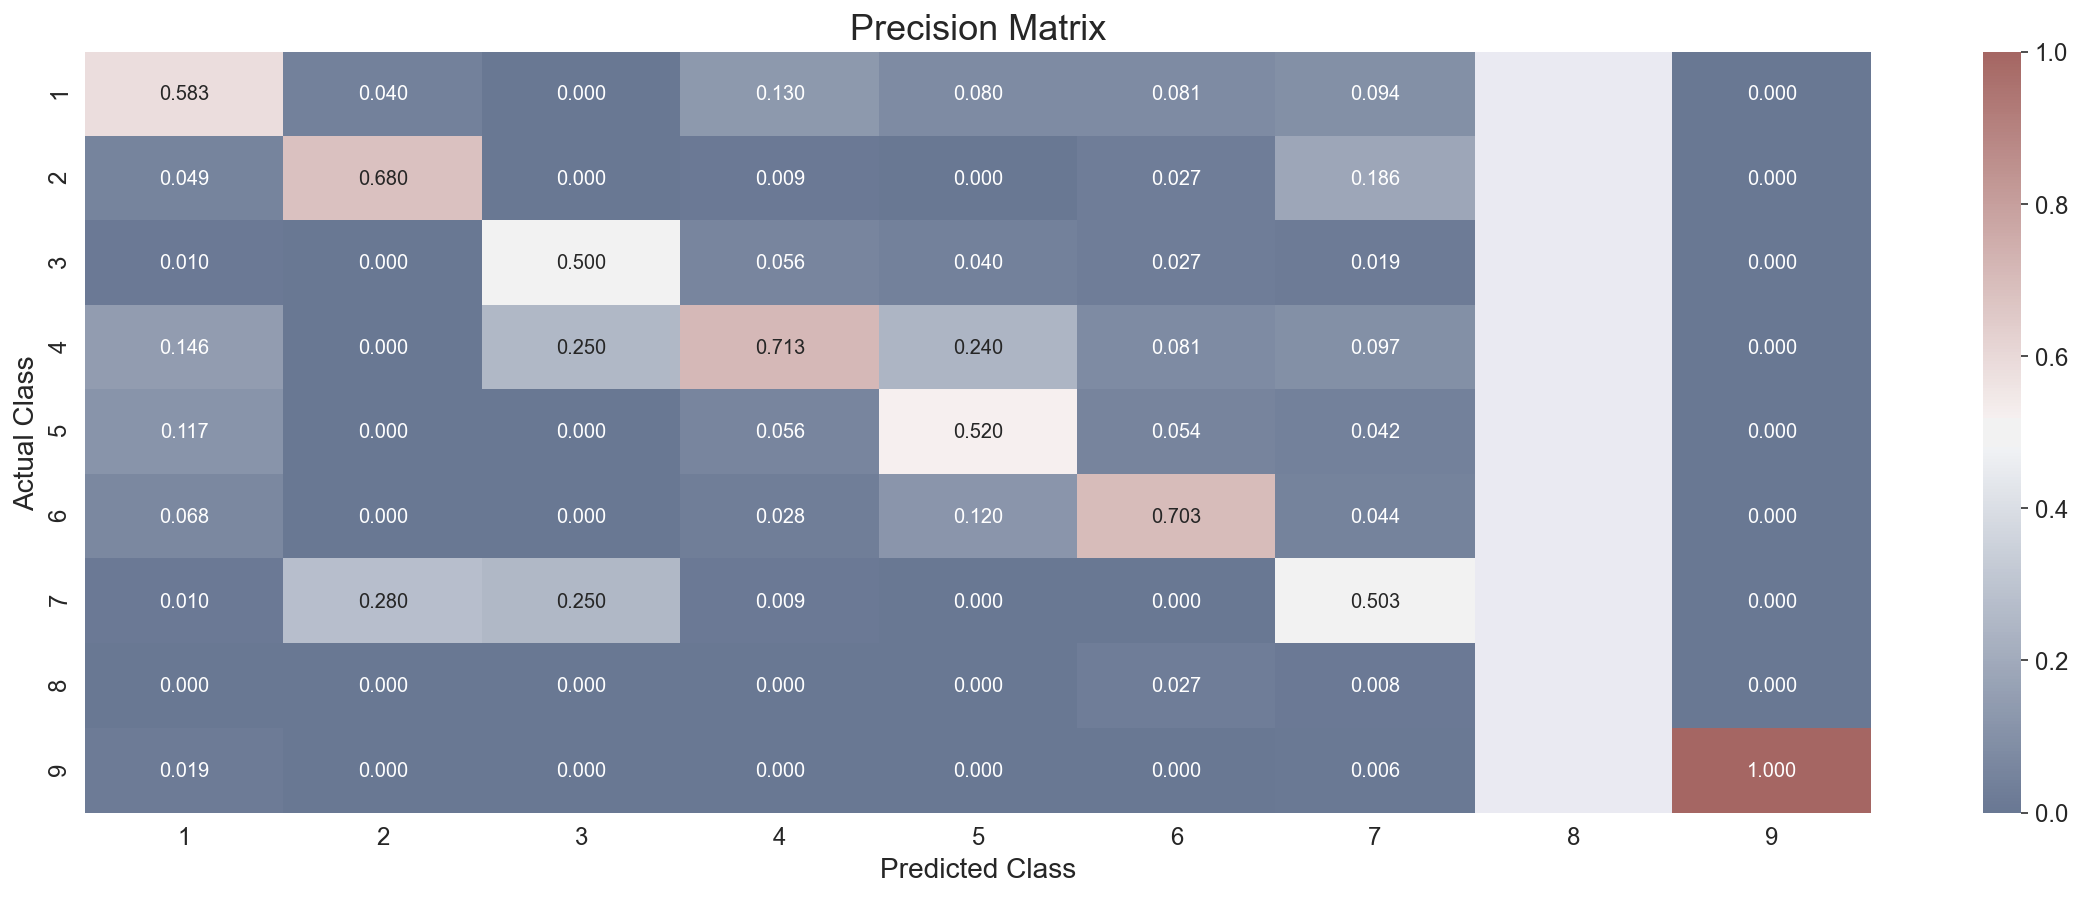

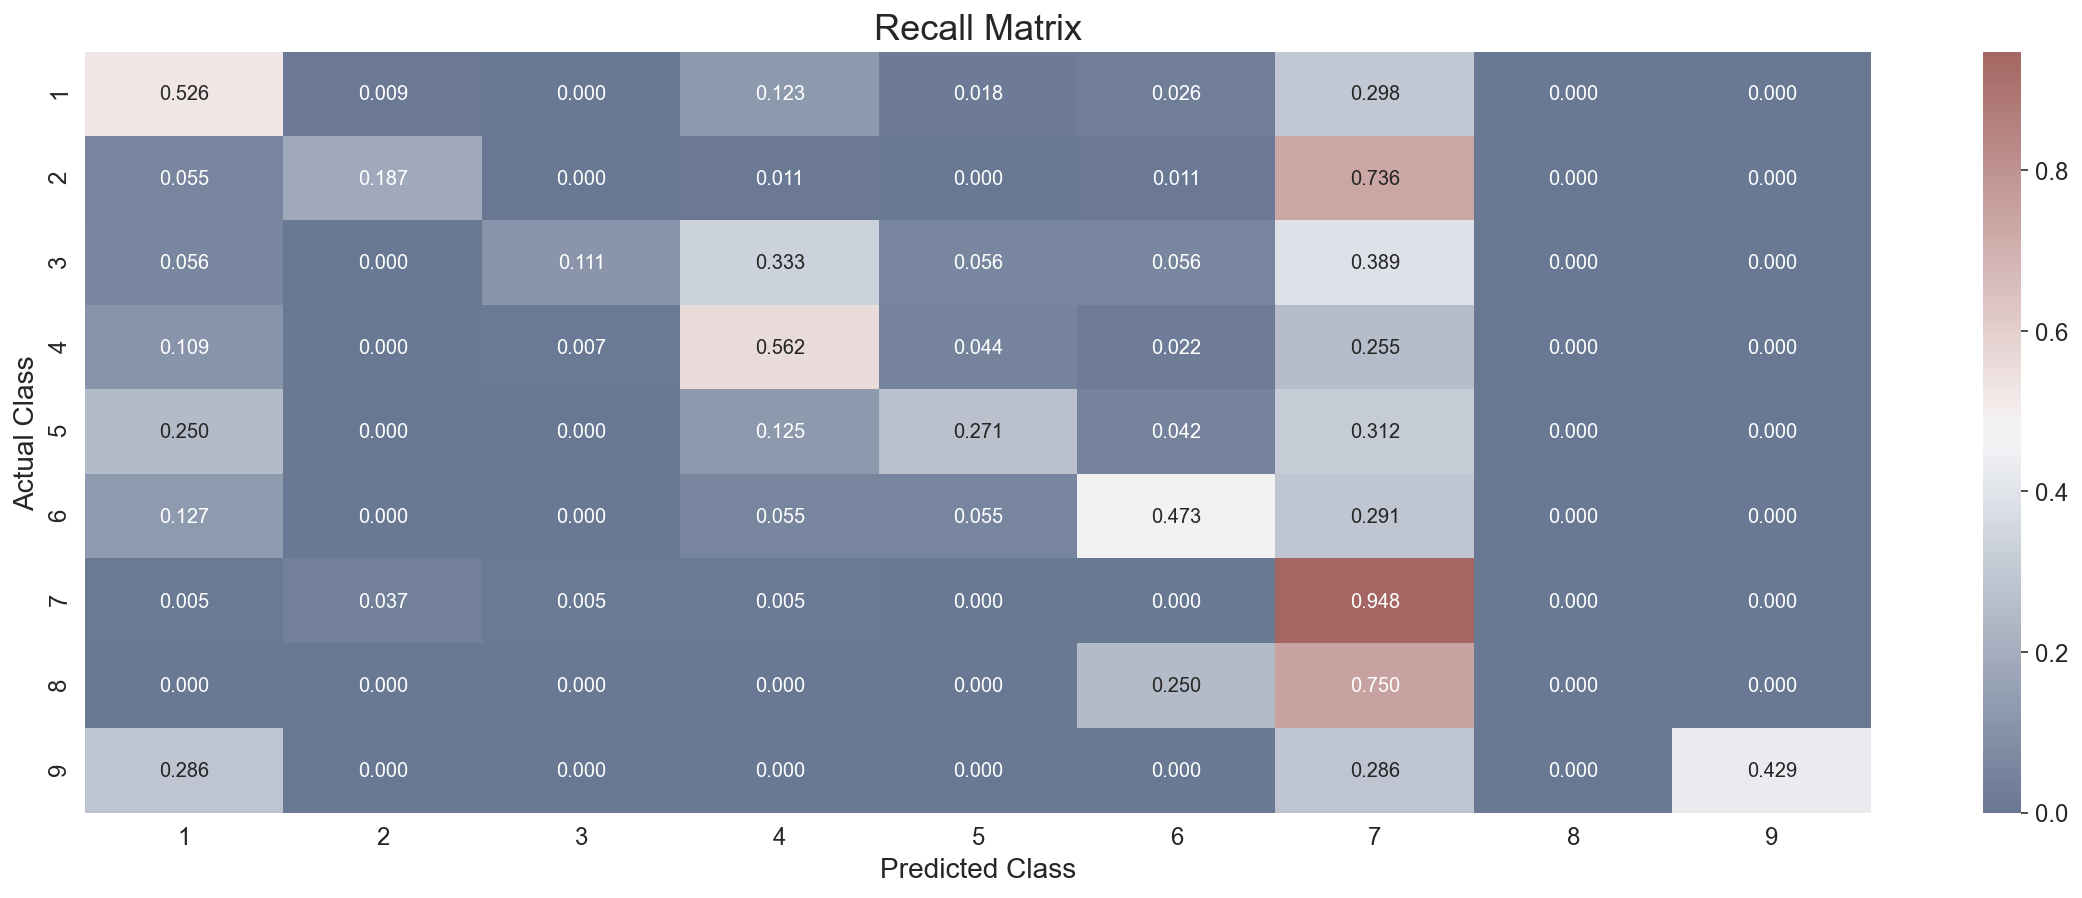

Gene : One hot encode
Variation : One hot encode
TEXT : Uni + bi gram
[log_loss] (1.360563007996444) alpha [1e-05]
[log_loss] (1.3555545541624583) alpha [0.0001]
[log_loss] (1.3407505645160396) alpha [0.001]
[log_loss] (1.3261437342649542) alpha [0.01]
[log_loss] (1.3245961623871376) alpha [0.1]
[log_loss] (1.3313161560439761) alpha [1]
[log_loss] (1.3658817412853863) alpha [10]
[log_loss] (1.346453553329073) alpha [100]
[log_loss] (1.276799806153155) alpha [1000]


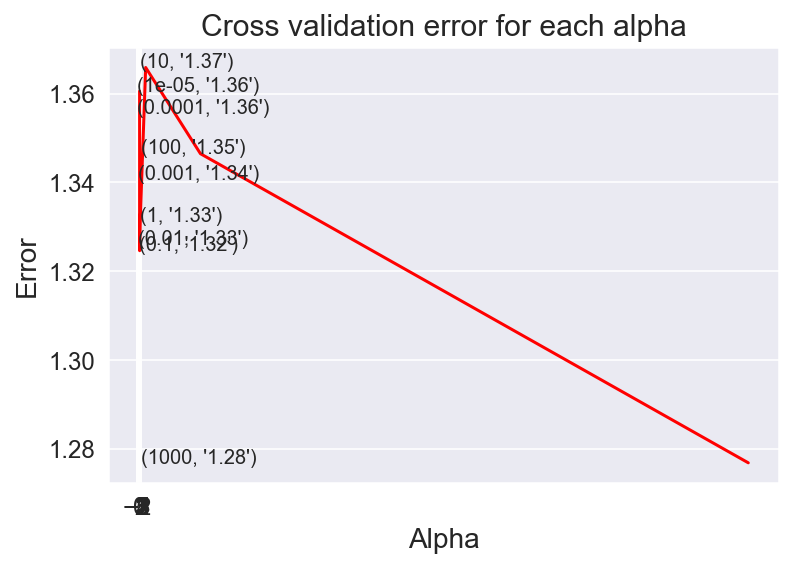

2
[ Best alpha : 1000 ]
[Train loss] (1.094260092706263)
[CV loss] (1.276799806153155)
[Test loss] (1.285009060728366)
[Test Log loss] (1.285009060728366)
Number of missclassified points : 0.4406015037593985


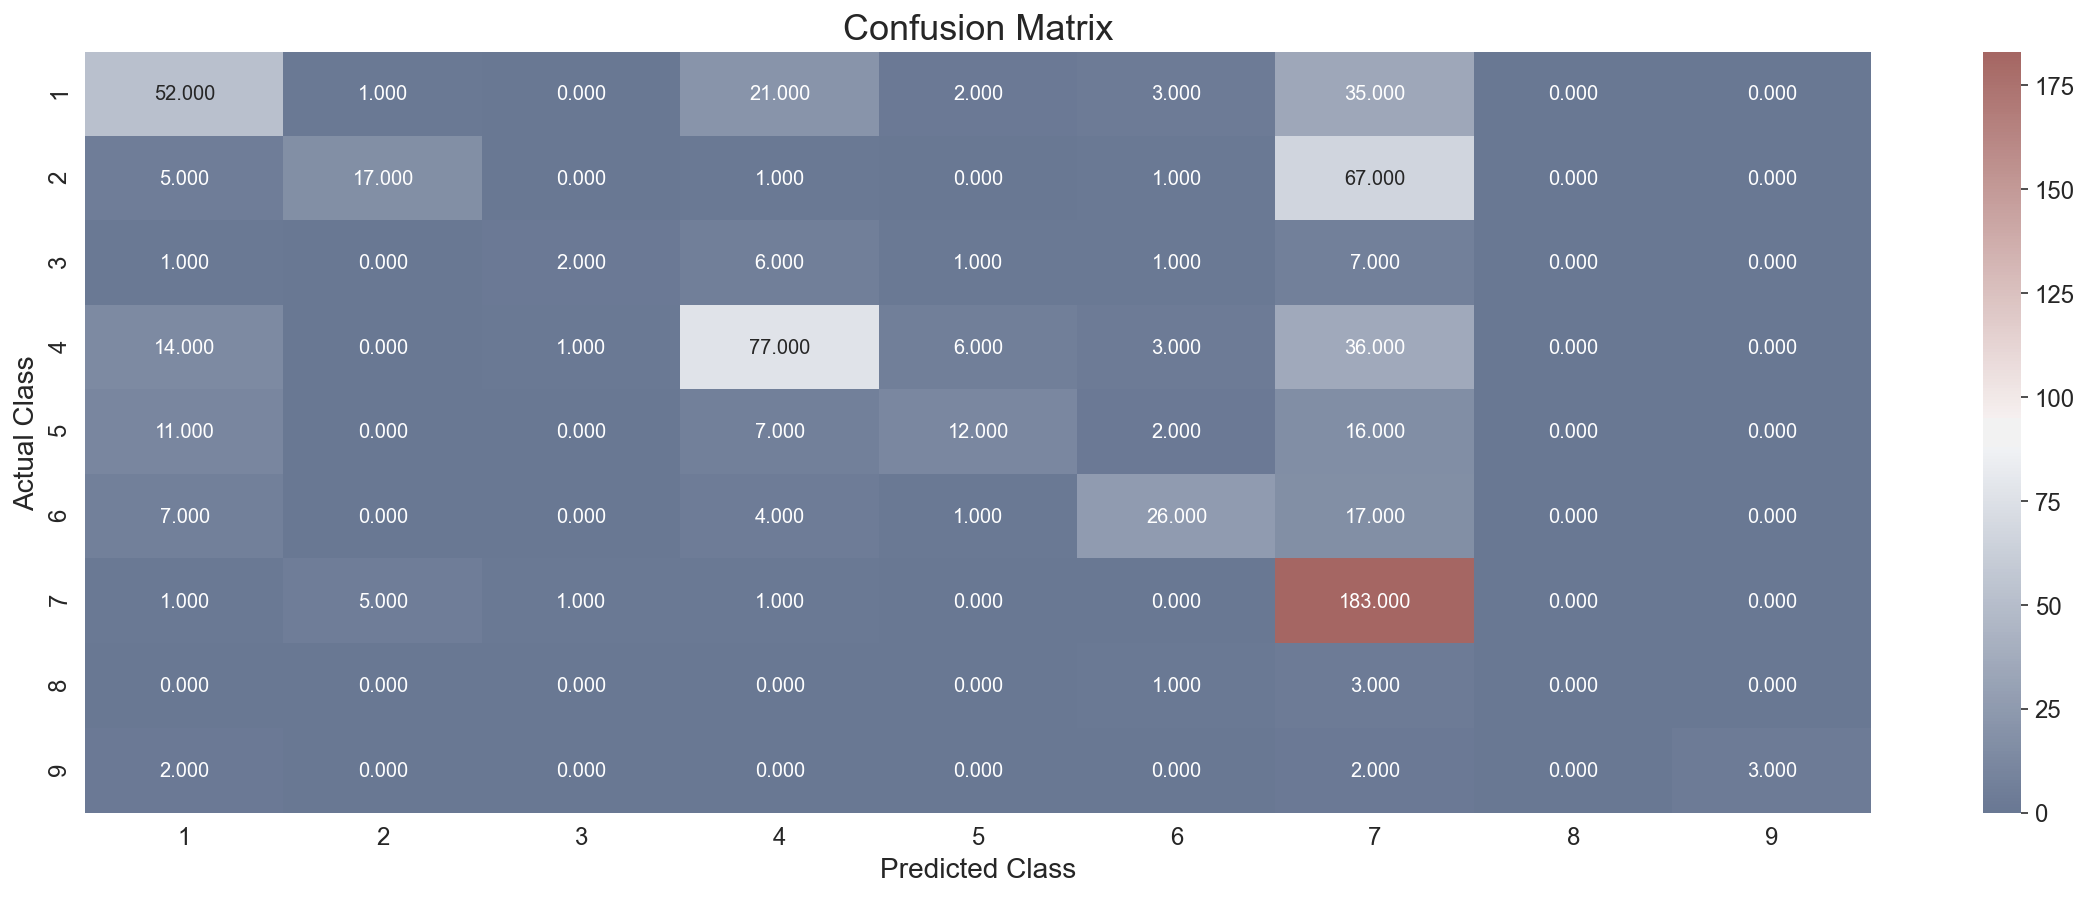

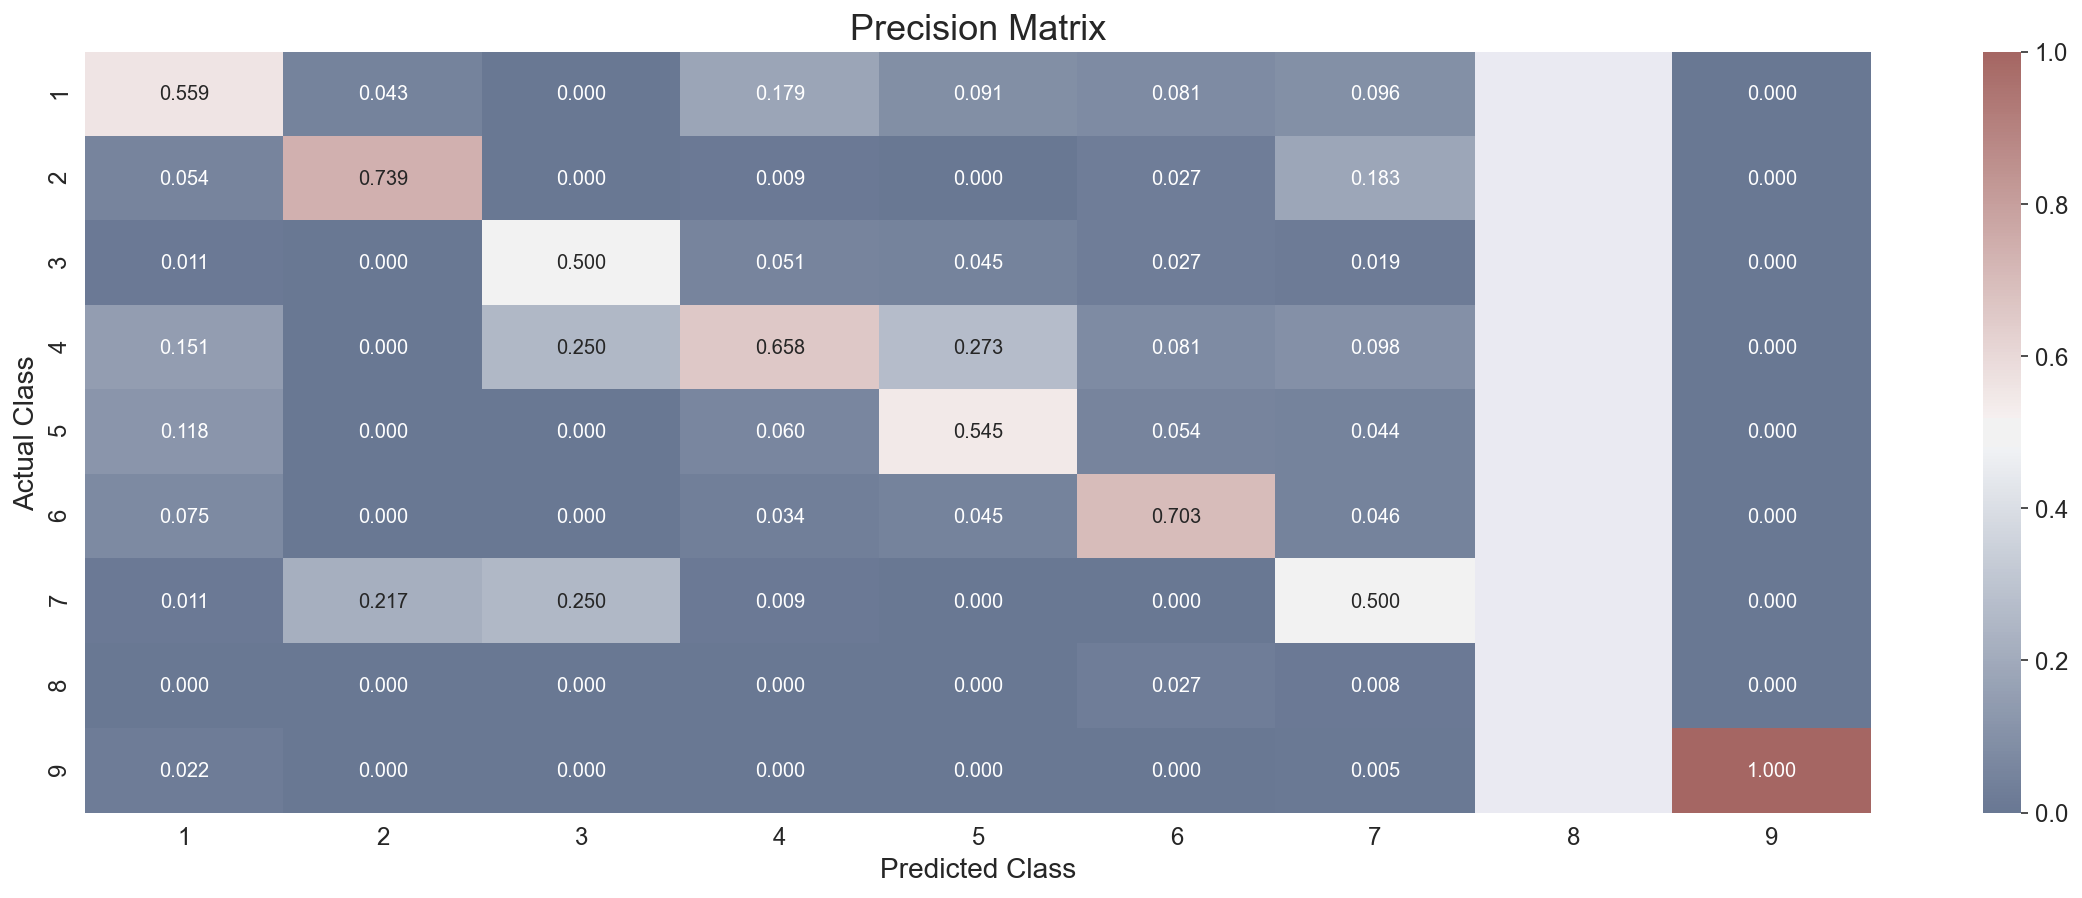

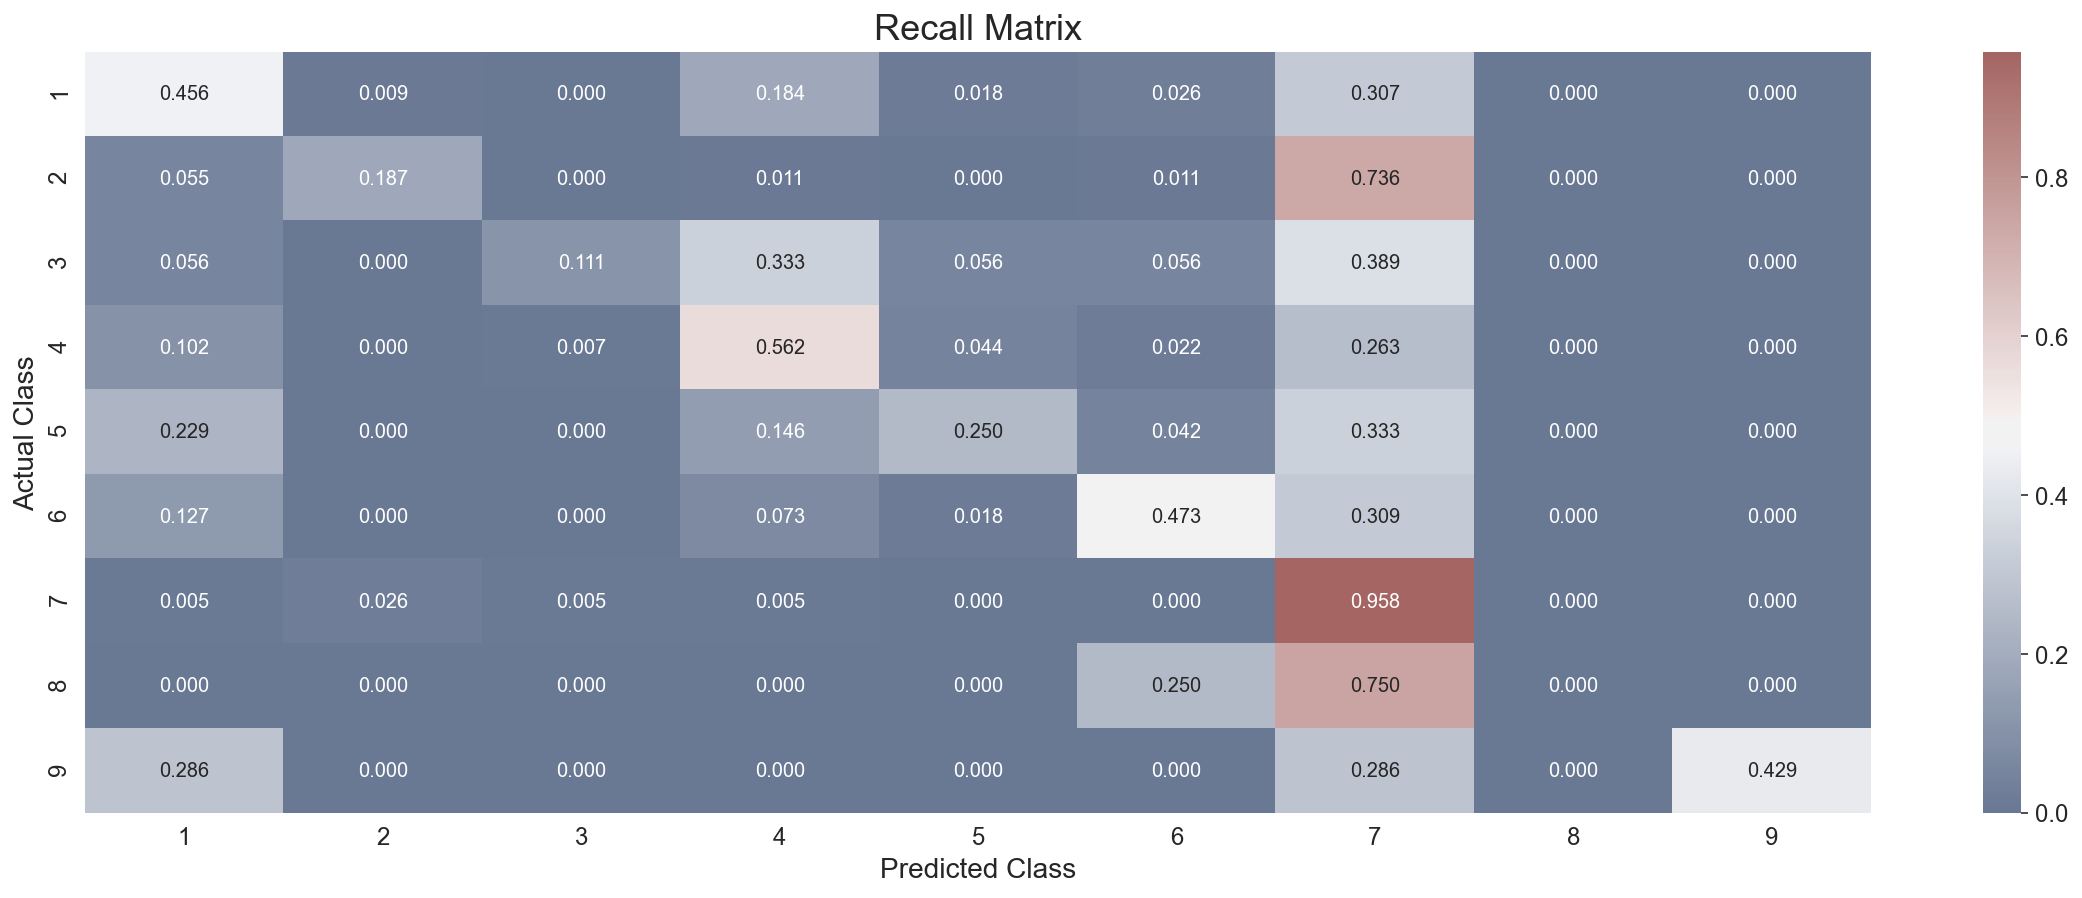

Gene : One hot encode
Variation : One hot encode
TEXT : Tf-idf
[log_loss] (1.3575196566675218) alpha [1e-05]
[log_loss] (1.3505671827775112) alpha [0.0001]
[log_loss] (1.348934211832293) alpha [0.001]
[log_loss] (1.3346973621858882) alpha [0.01]
[log_loss] (1.3392083593200281) alpha [0.1]
[log_loss] (1.347156259169142) alpha [1]
[log_loss] (1.341806458663816) alpha [10]
[log_loss] (1.3093235827791458) alpha [100]
[log_loss] (1.251835471477842) alpha [1000]


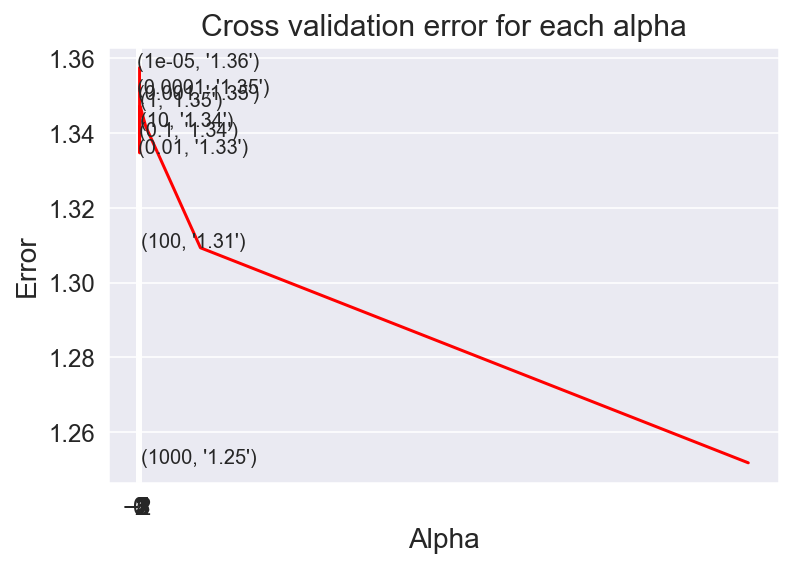

3
[ Best alpha : 1000 ]
[Train loss] (1.0907417164199429)
[CV loss] (1.251835471477842)
[Test loss] (1.2551028235566613)
[Test Log loss] (1.2551028235566613)
Number of missclassified points : 0.42406015037593986


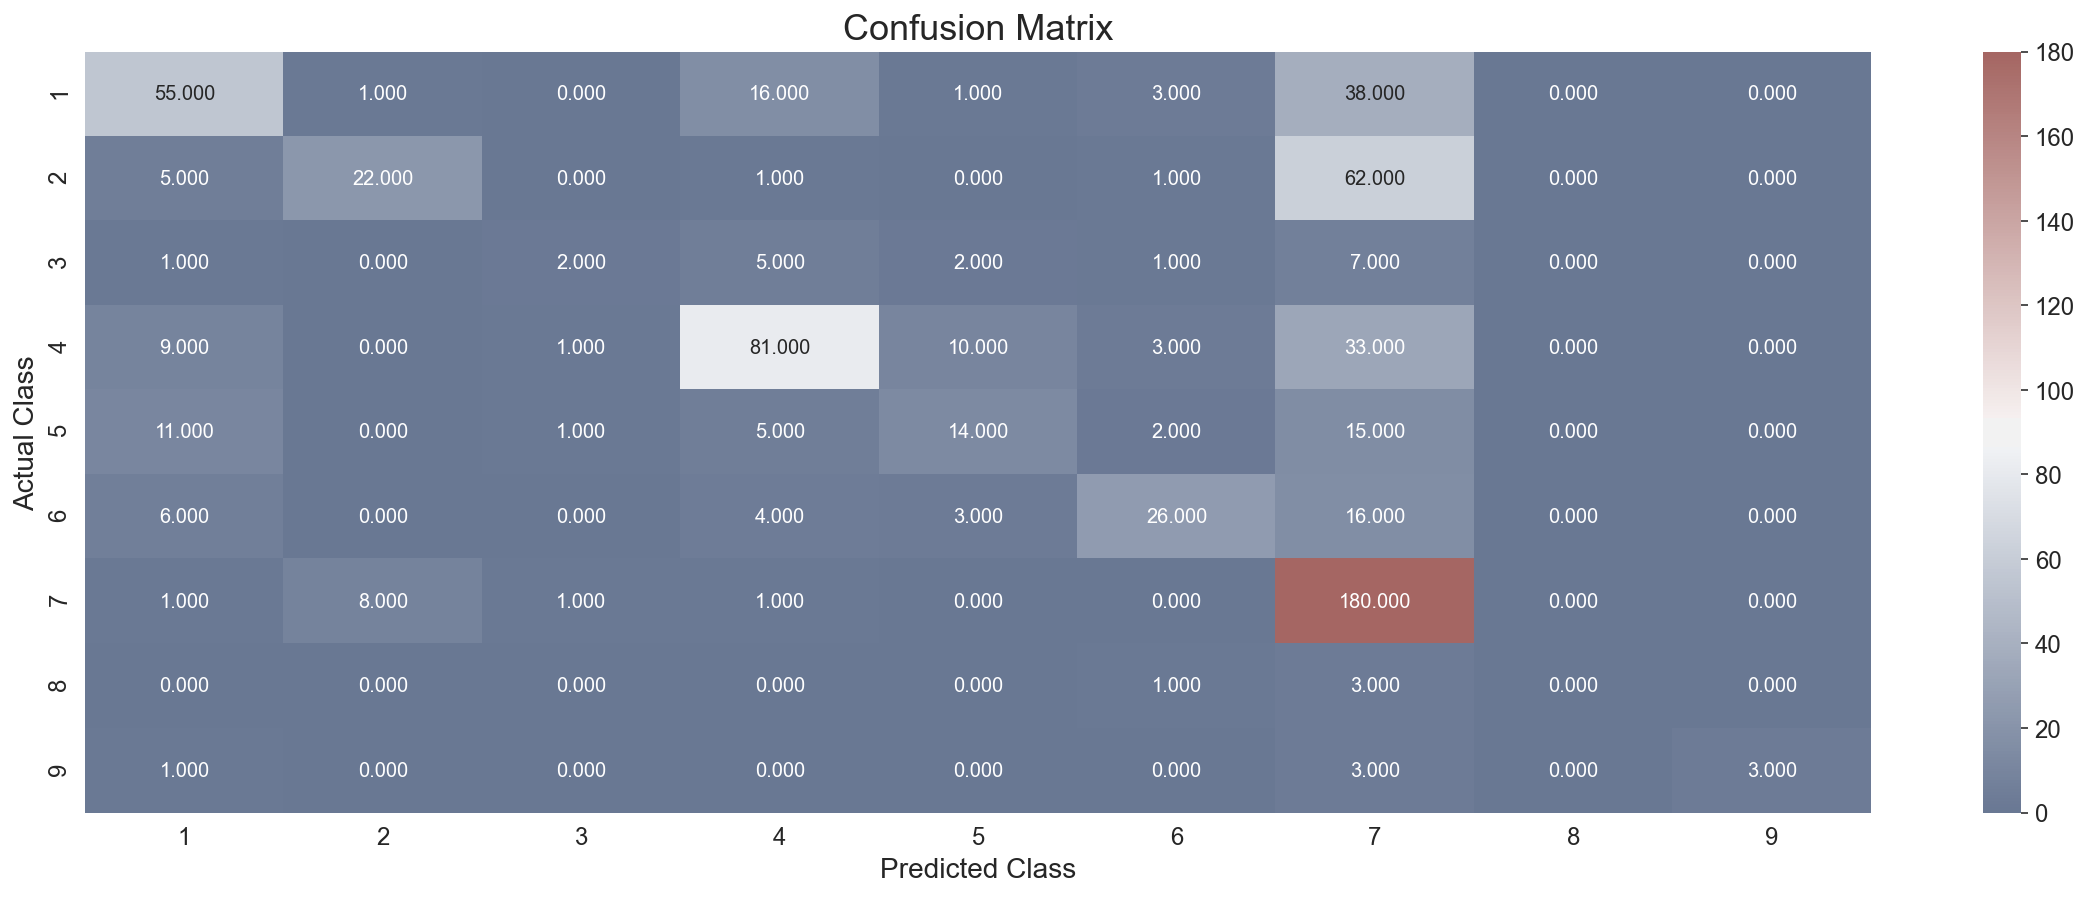

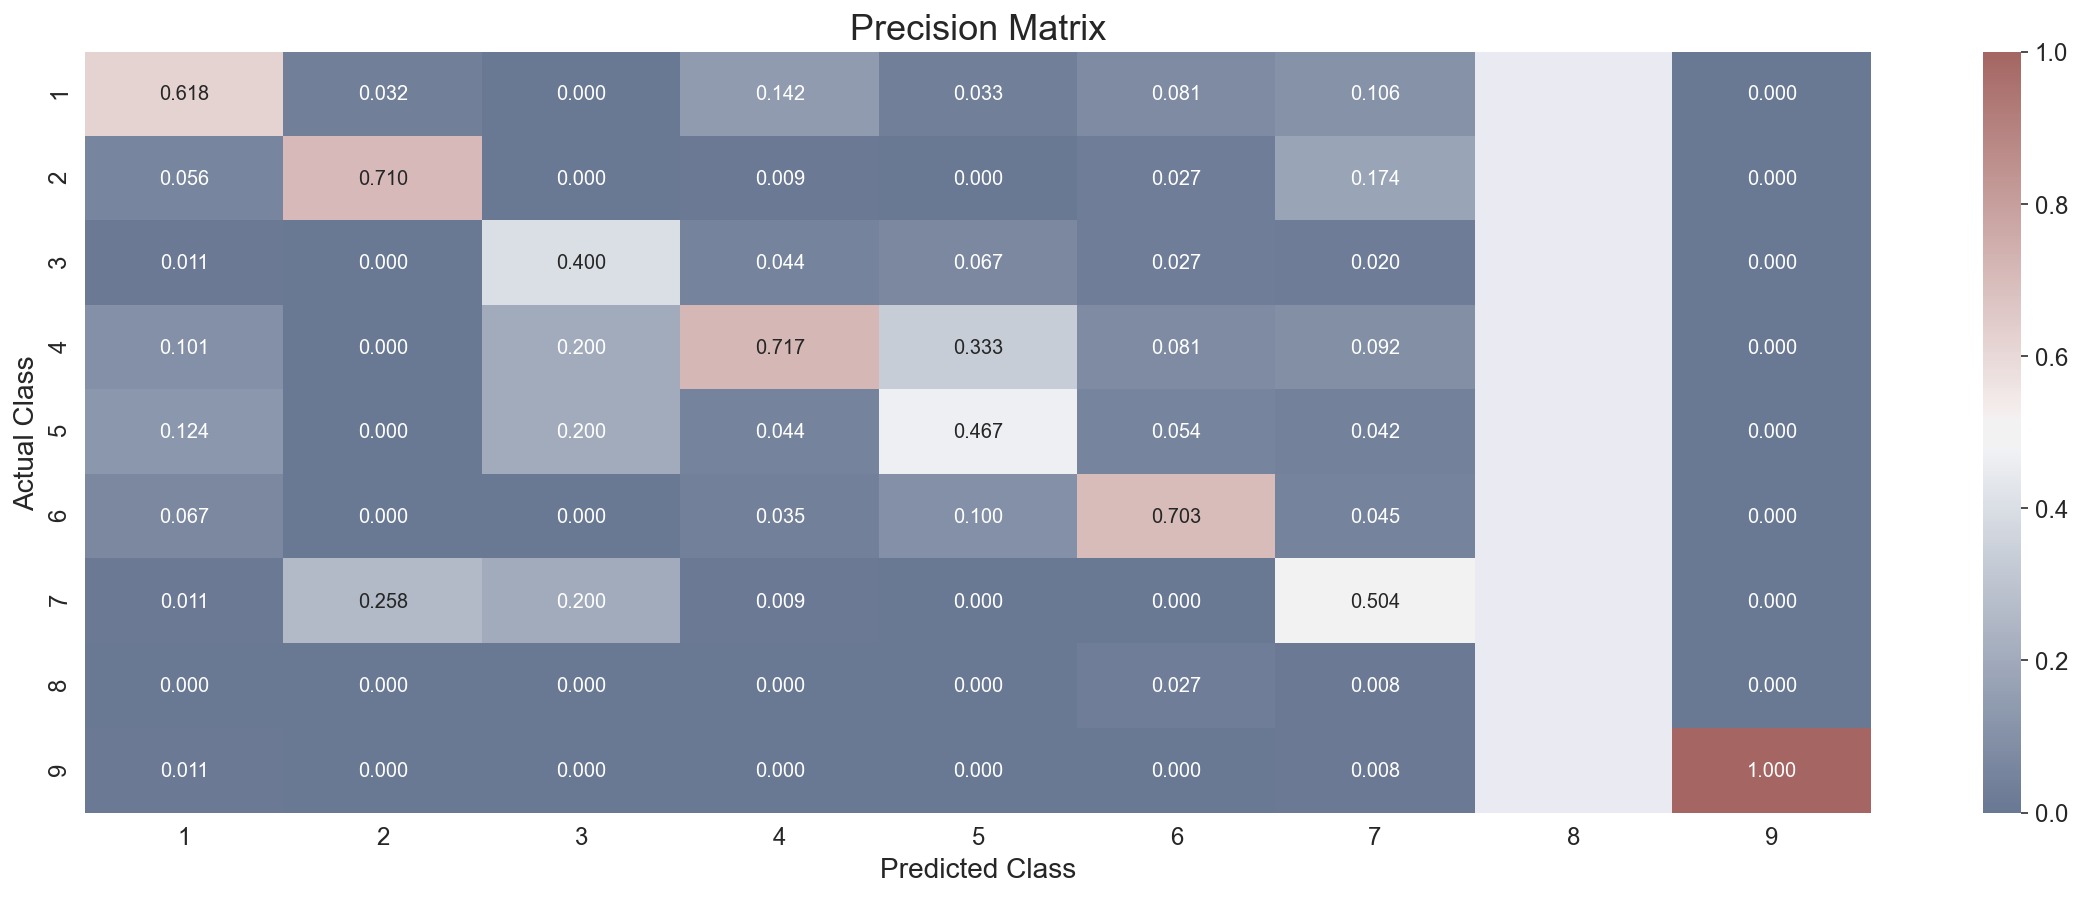

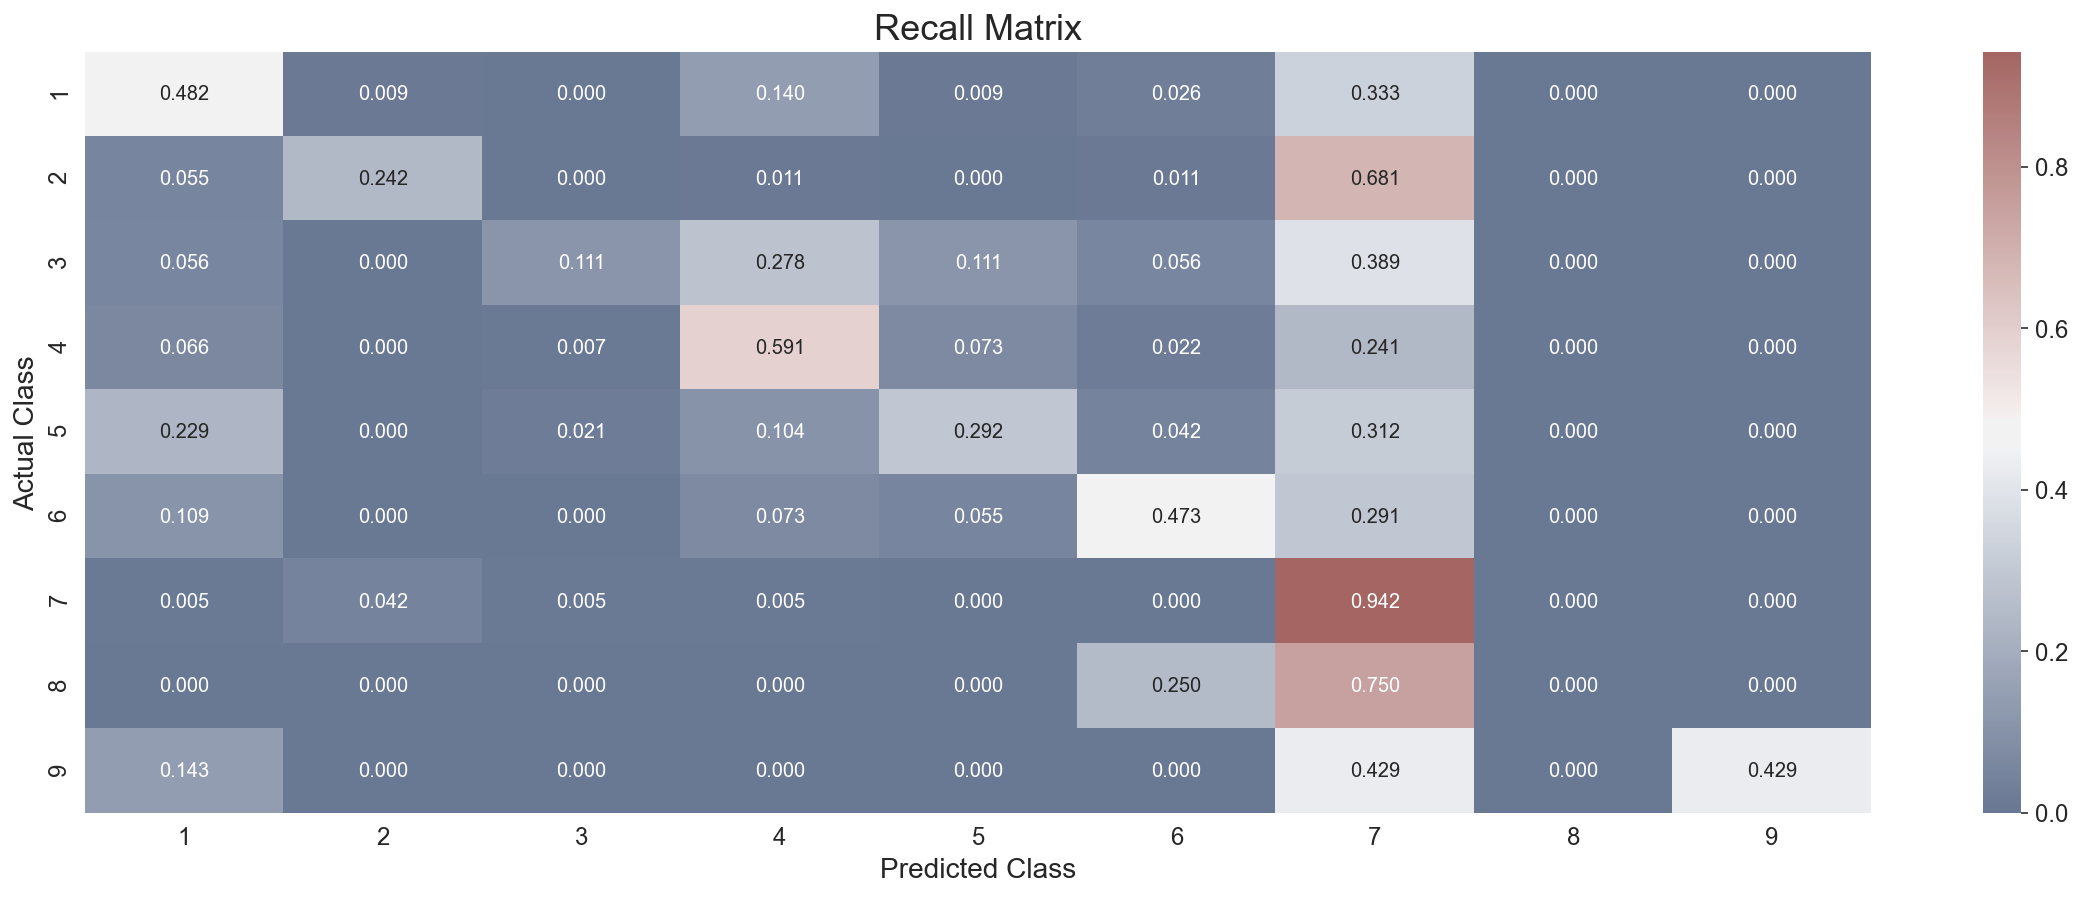

In [256]:
method_vect = ['BOW', 'Bi-gram', 'Uni + bi gram', 'Tf-idf']
ohe_data = [[X_train_ohe_bow, X_cv_ohe_bow, X_test_ohe_bow],
            [X_train_ohe_bi, X_cv_ohe_bi, X_test_ohe_bi],
            [X_train_ohe_uni_bi, X_cv_ohe_uni_bi, X_test_ohe_uni_bi],
            [X_train_ohe_tfidf, X_cv_ohe_tfidf, X_test_ohe_tfidf]]

for a, b in enumerate(method_vect):
    print("=======")
    print("Gene : One hot encode")
    print("Variation : One hot encode")
    print(f"TEXT : {b}")
    print("=======")
    alpha = [10**x for x in range(-5, 4)]
    cv_log_error = []
    for k in alpha:
        clf = MultinomialNB(alpha=k)
        clf.fit(ohe_data[a][0], y_train)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(ohe_data[a][0], y_train)
        y_pred = sig_clf.predict_proba(ohe_data[a][1])
        cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
        print(f"[log_loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{k}]")

    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error, c='r')
    for i, txt in enumerate(np.round(cv_log_error,2)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
    plt.xticks(np.log10(alpha))
    plt.title("Cross validation error for each alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Error")
    plt.show()

    print(a)

    best_alpha = np.argmin(cv_log_error)
    print("=====================")
    print(f"[ Best alpha : {alpha[best_alpha]} ]")
    print("=====================")
    clf = MultinomialNB(alpha=alpha[best_alpha])
    clf.fit(ohe_data[a][0], y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(ohe_data[a][0], y_train)
    y_pred = sig_clf.predict_proba(ohe_data[a][0])
    print(f"[Train loss] ({log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)})")
    y_pred = sig_clf.predict_proba(ohe_data[a][1])
    print(f"[CV loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)})")
    y_pred = sig_clf.predict_proba(ohe_data[a][2])
    print(f"[Test loss] ({log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)})")
    print("="*53)
    predict_and_plot_confusion_matrix(ohe_data[a][0], ohe_data[a][2], y_train, y_test, clf=MultinomialNB(alpha=alpha[best_alpha]))

    cv_log_error.clear()
    print("="*70)

Gene : Response Coding
Variation : REsponse Coding
TEXT : BOW
[log_loss] (1.3391624002814904) alpha [1e-05]
[log_loss] (1.3384766122808818) alpha [0.0001]
[log_loss] (1.3310659055039107) alpha [0.001]
[log_loss] (1.3248009649762582) alpha [0.01]
[log_loss] (1.3171435597355576) alpha [0.1]
[log_loss] (1.3331355971414076) alpha [1]
[log_loss] (1.4341394548521536) alpha [10]
[log_loss] (1.4466429697788425) alpha [100]
[log_loss] (1.3893184773939775) alpha [1000]


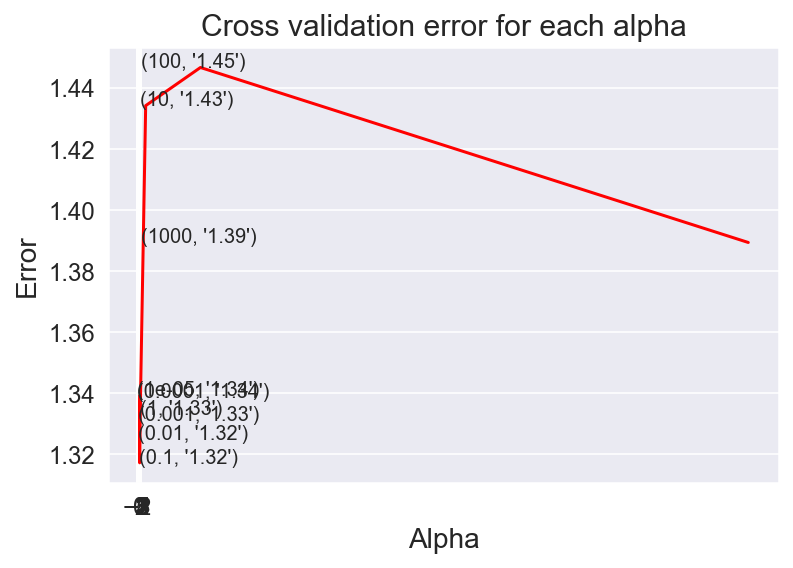

0
[ Best alpha : 0.1 ]
[Train loss] (0.8857926413805784)
[CV loss] (1.3171435597355576)
[Test loss] (1.3371652169054147)
[Test Log loss] (1.3371652169054147)
Number of missclassified points : 0.41654135338345866


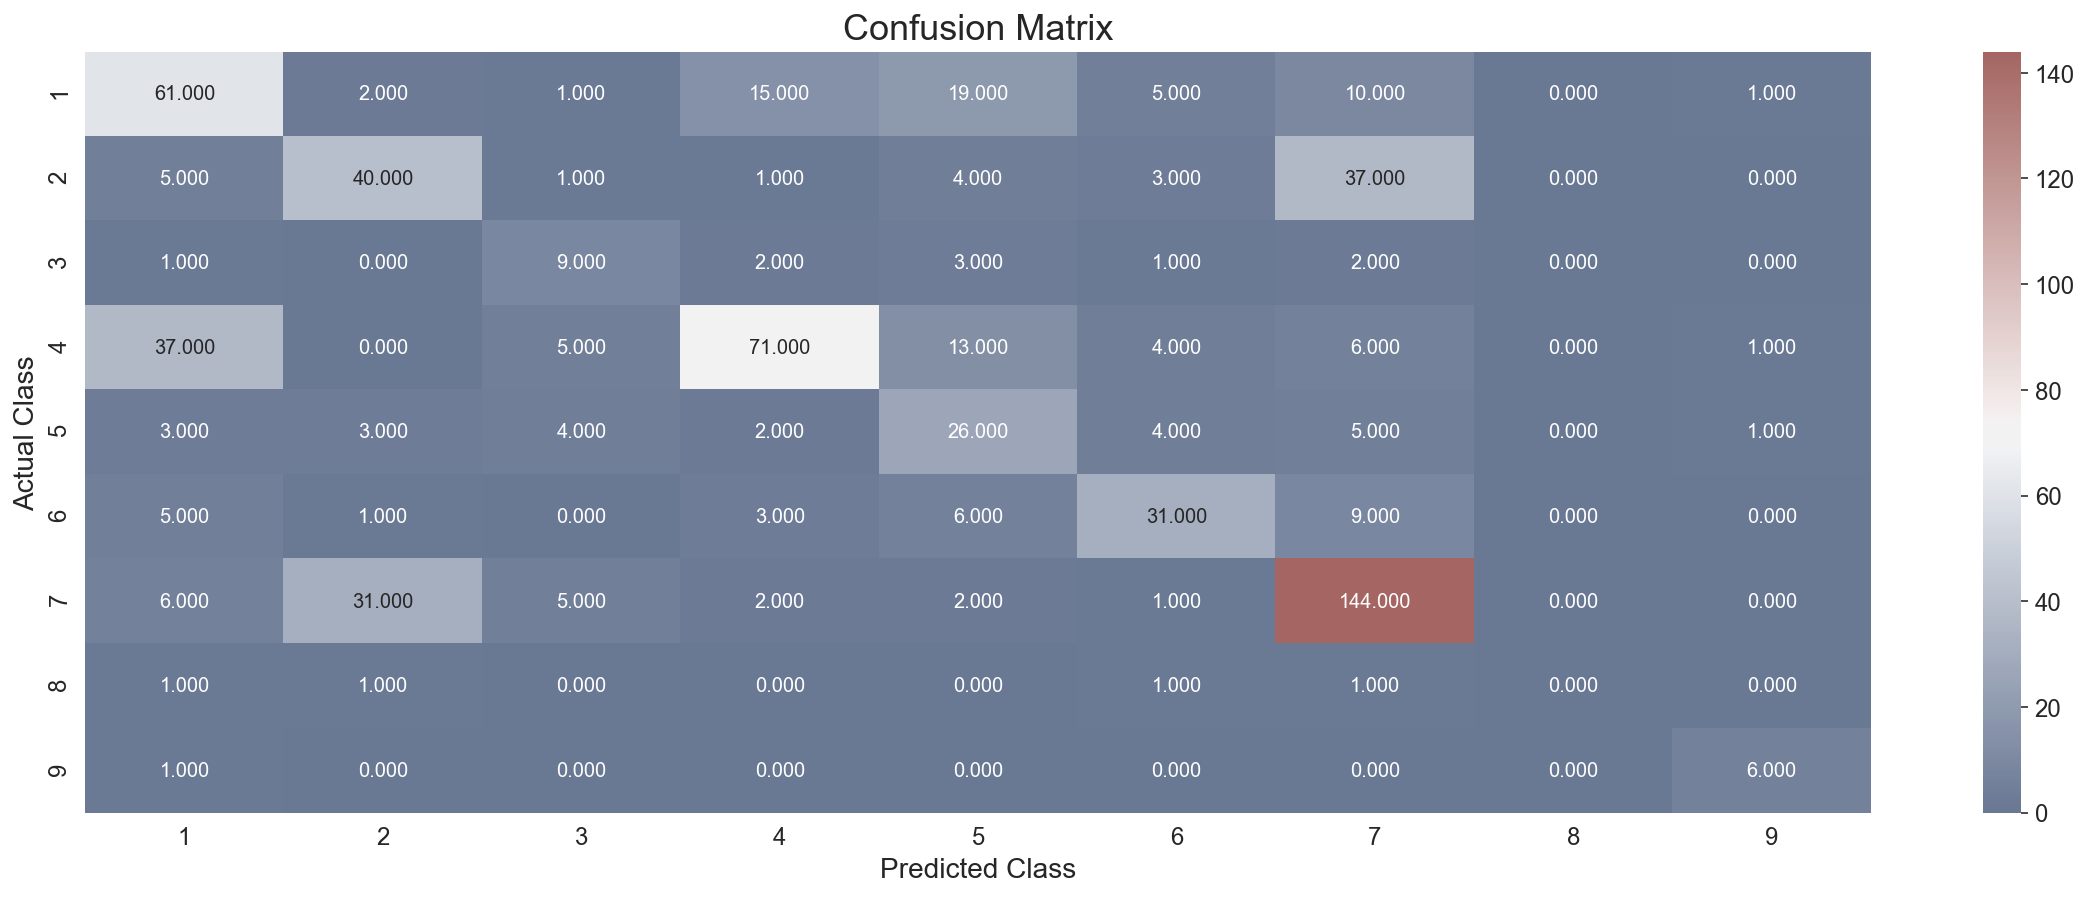

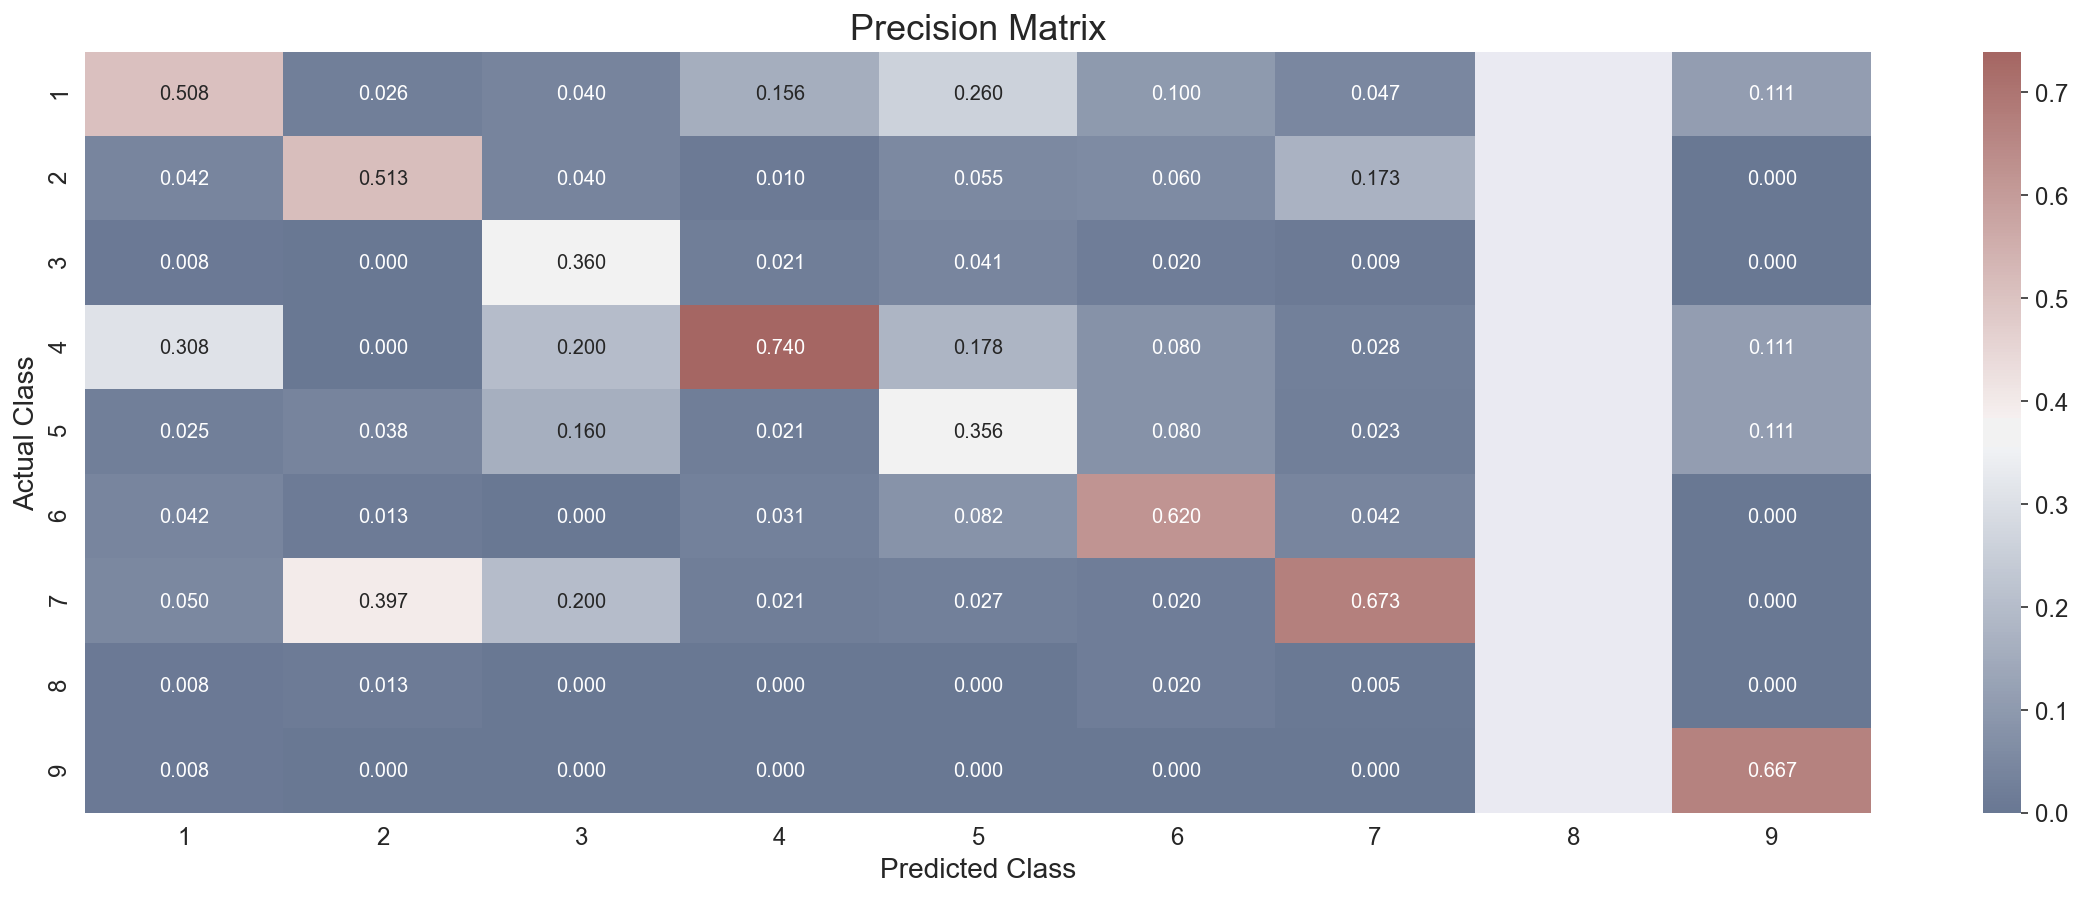

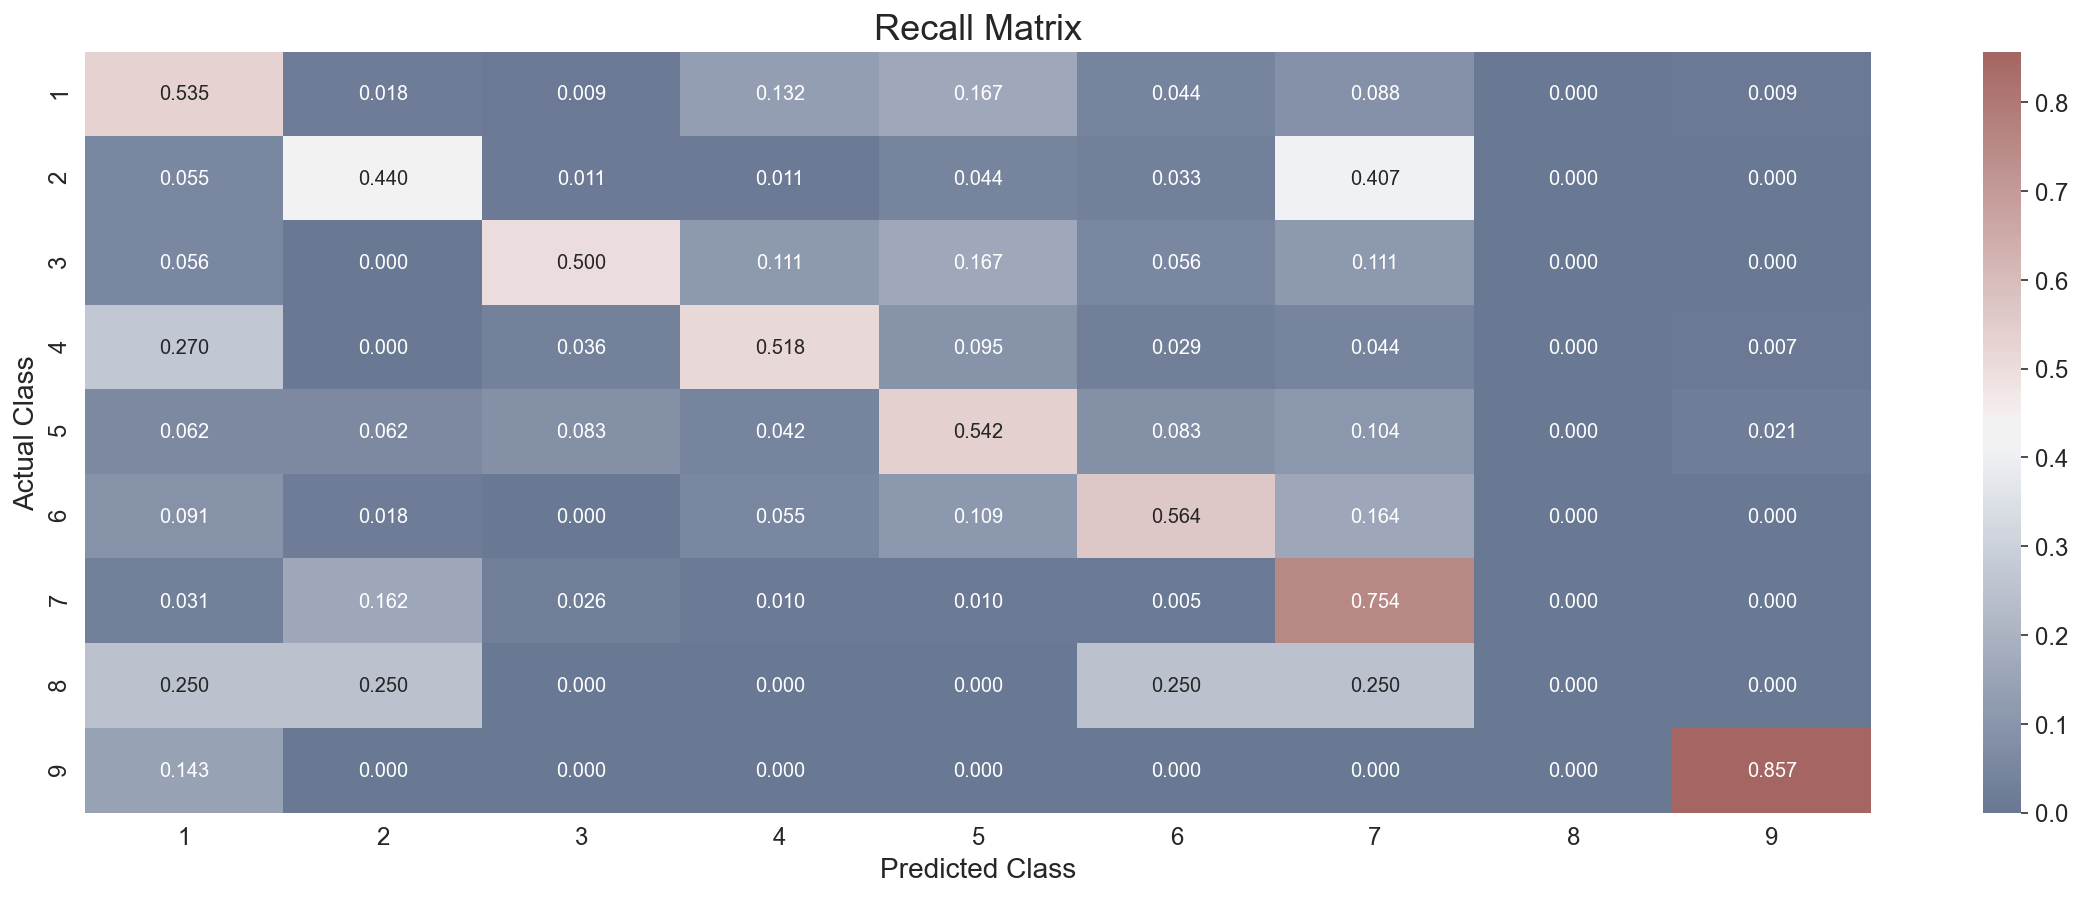

Gene : Response Coding
Variation : REsponse Coding
TEXT : Bi-gram
[log_loss] (1.3596297553622643) alpha [1e-05]
[log_loss] (1.354830634161526) alpha [0.0001]
[log_loss] (1.34204076607696) alpha [0.001]
[log_loss] (1.3323336876398786) alpha [0.01]
[log_loss] (1.3274841880742911) alpha [0.1]
[log_loss] (1.3291807859415787) alpha [1]
[log_loss] (1.3416714738669886) alpha [10]
[log_loss] (1.3203625737643514) alpha [100]
[log_loss] (1.2683381498656778) alpha [1000]


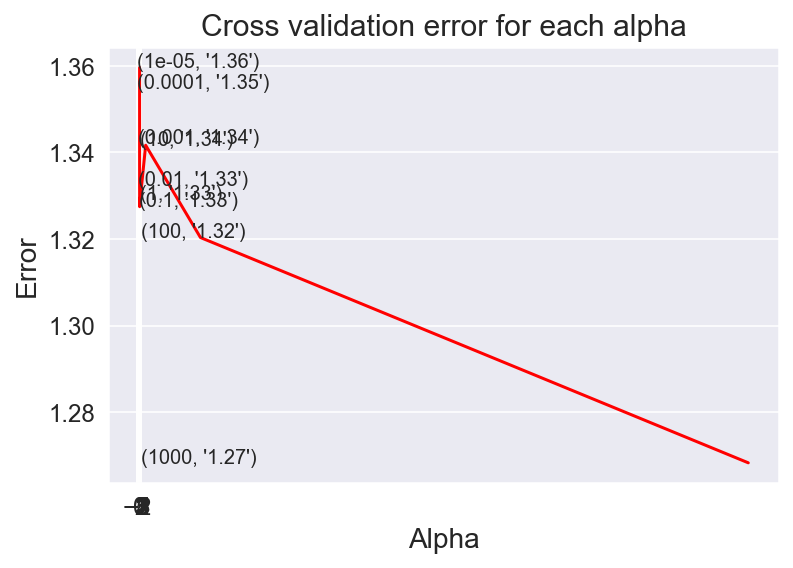

1
[ Best alpha : 1000 ]
[Train loss] (1.101270290763788)
[CV loss] (1.2683381498656778)
[Test loss] (1.2850656719264058)
[Test Log loss] (1.2850656719264058)
Number of missclassified points : 0.4330827067669173


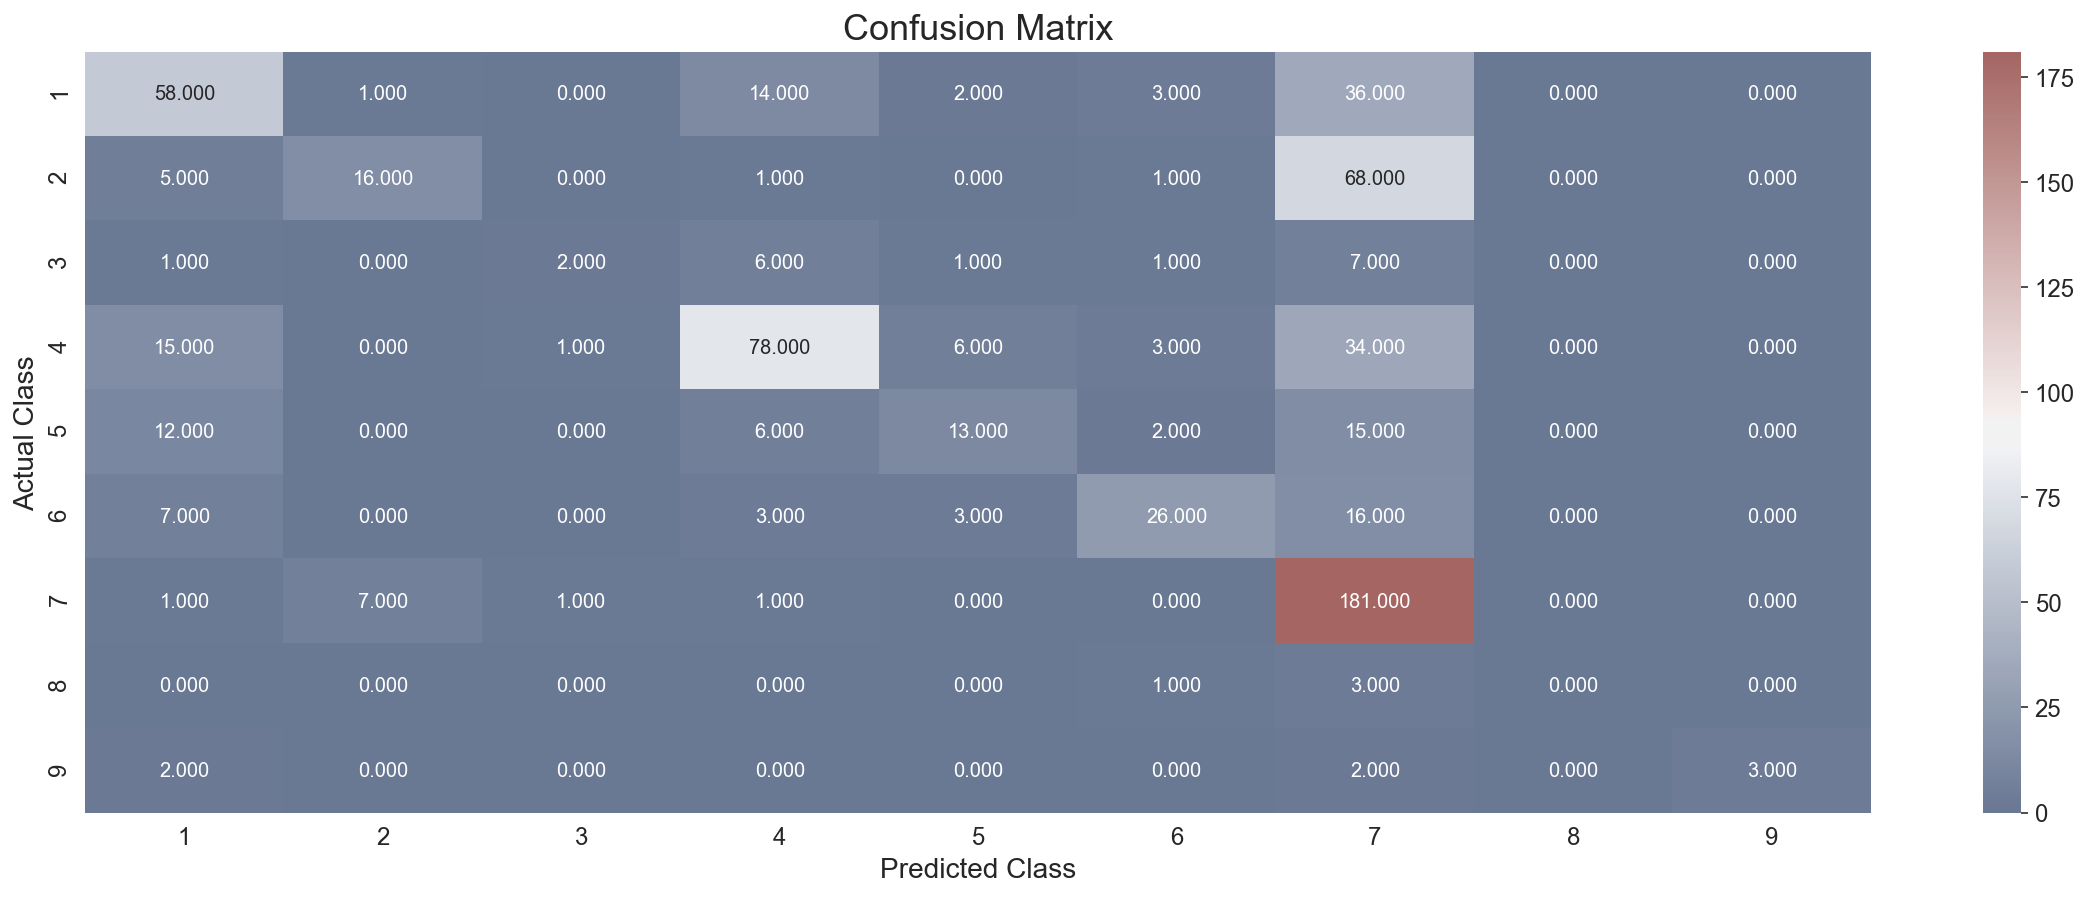

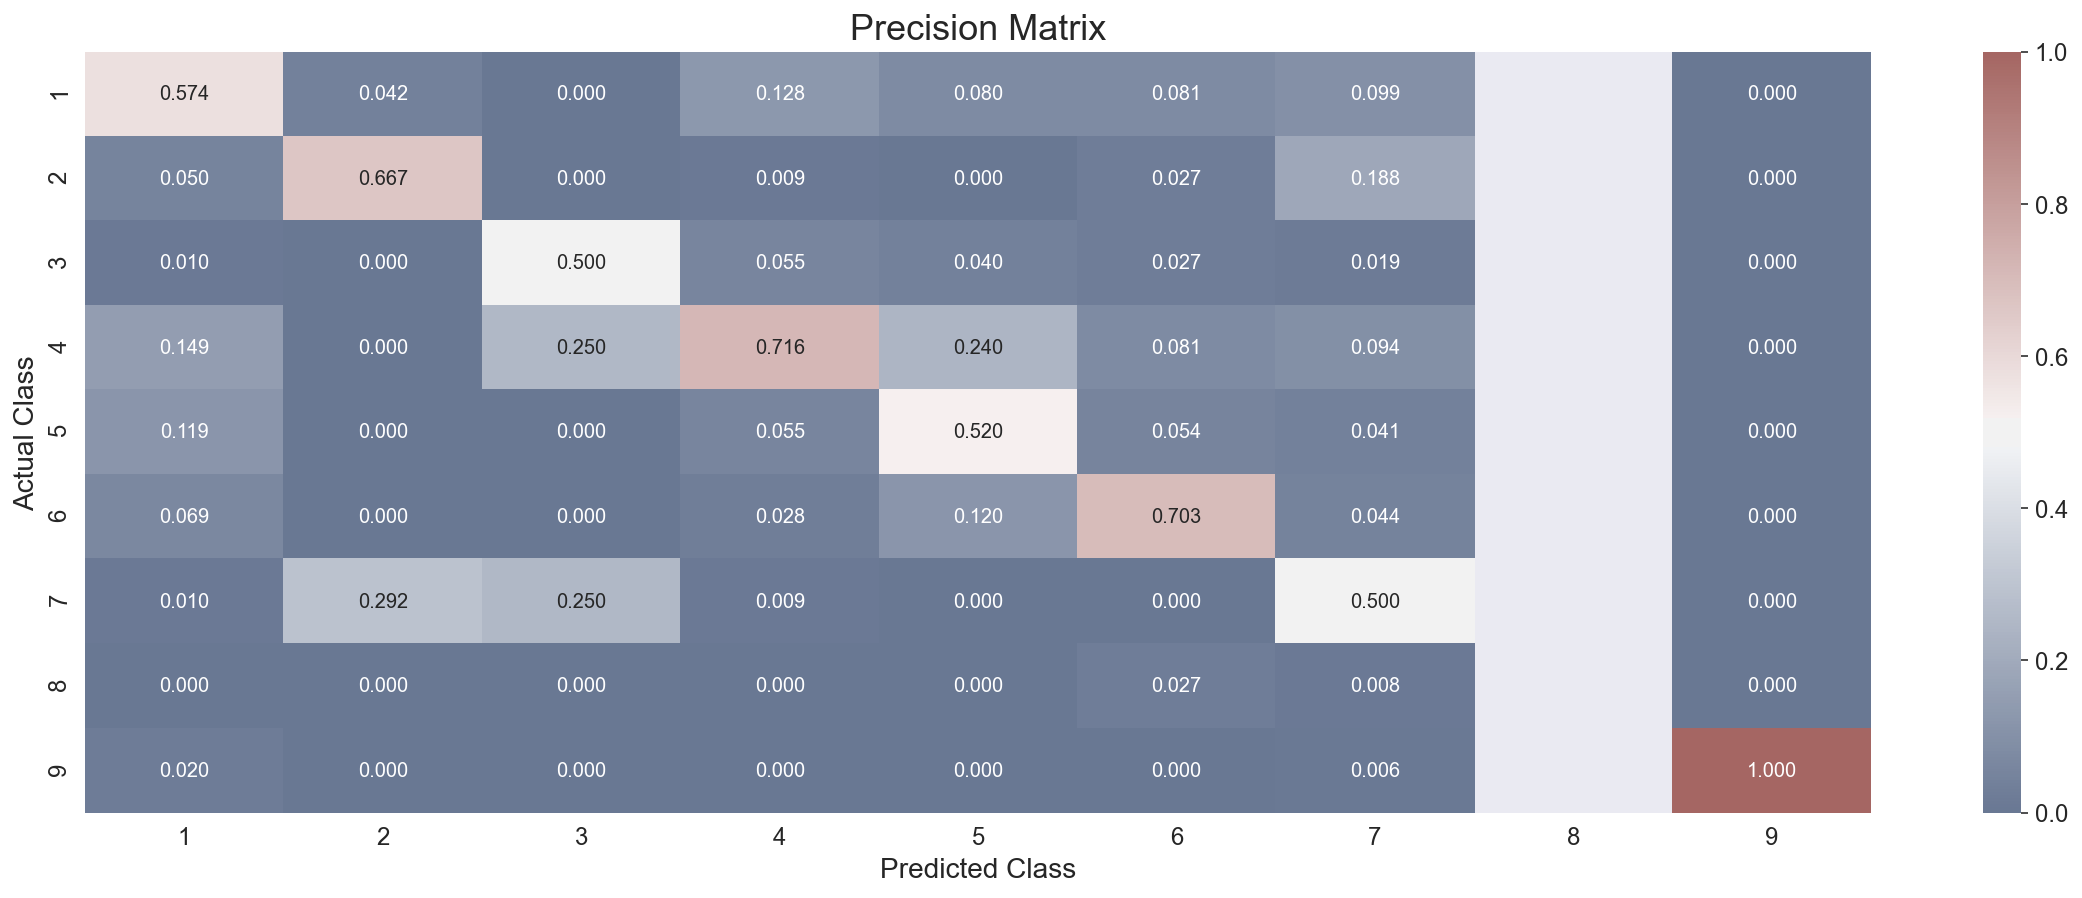

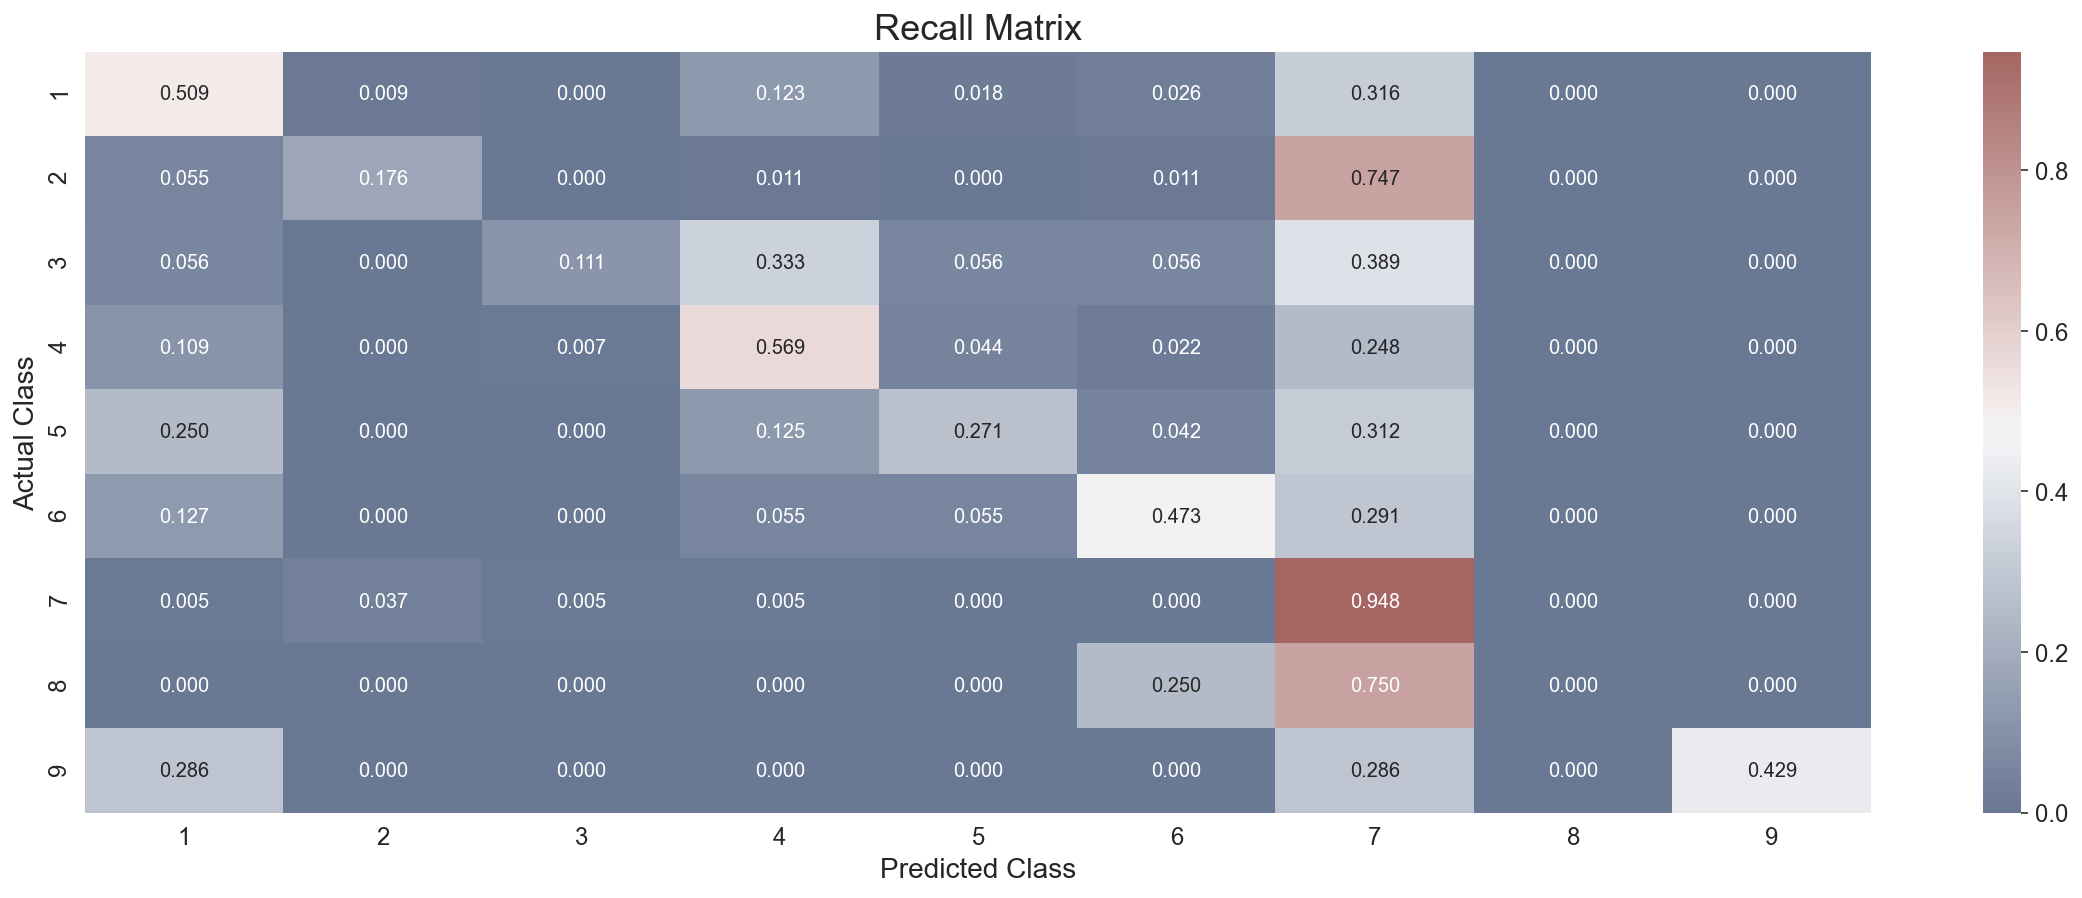

Gene : Response Coding
Variation : REsponse Coding
TEXT : Uni + bi gram
[log_loss] (1.3595227294925103) alpha [1e-05]
[log_loss] (1.3556158928094126) alpha [0.0001]
[log_loss] (1.3410483746792792) alpha [0.001]
[log_loss] (1.327841523451984) alpha [0.01]
[log_loss] (1.3262499422884044) alpha [0.1]
[log_loss] (1.332791244021219) alpha [1]
[log_loss] (1.3662092463190327) alpha [10]
[log_loss] (1.3475049108306654) alpha [100]
[log_loss] (1.2790642472242133) alpha [1000]


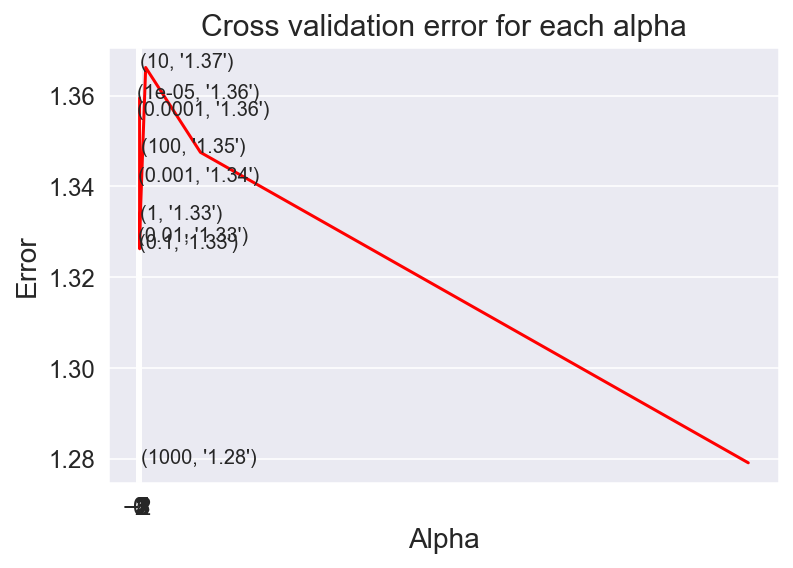

2
[ Best alpha : 1000 ]
[Train loss] (1.0968606616083707)
[CV loss] (1.2790642472242133)
[Test loss] (1.2886073324649536)
[Test Log loss] (1.2886073324649536)
Number of missclassified points : 0.43909774436090226


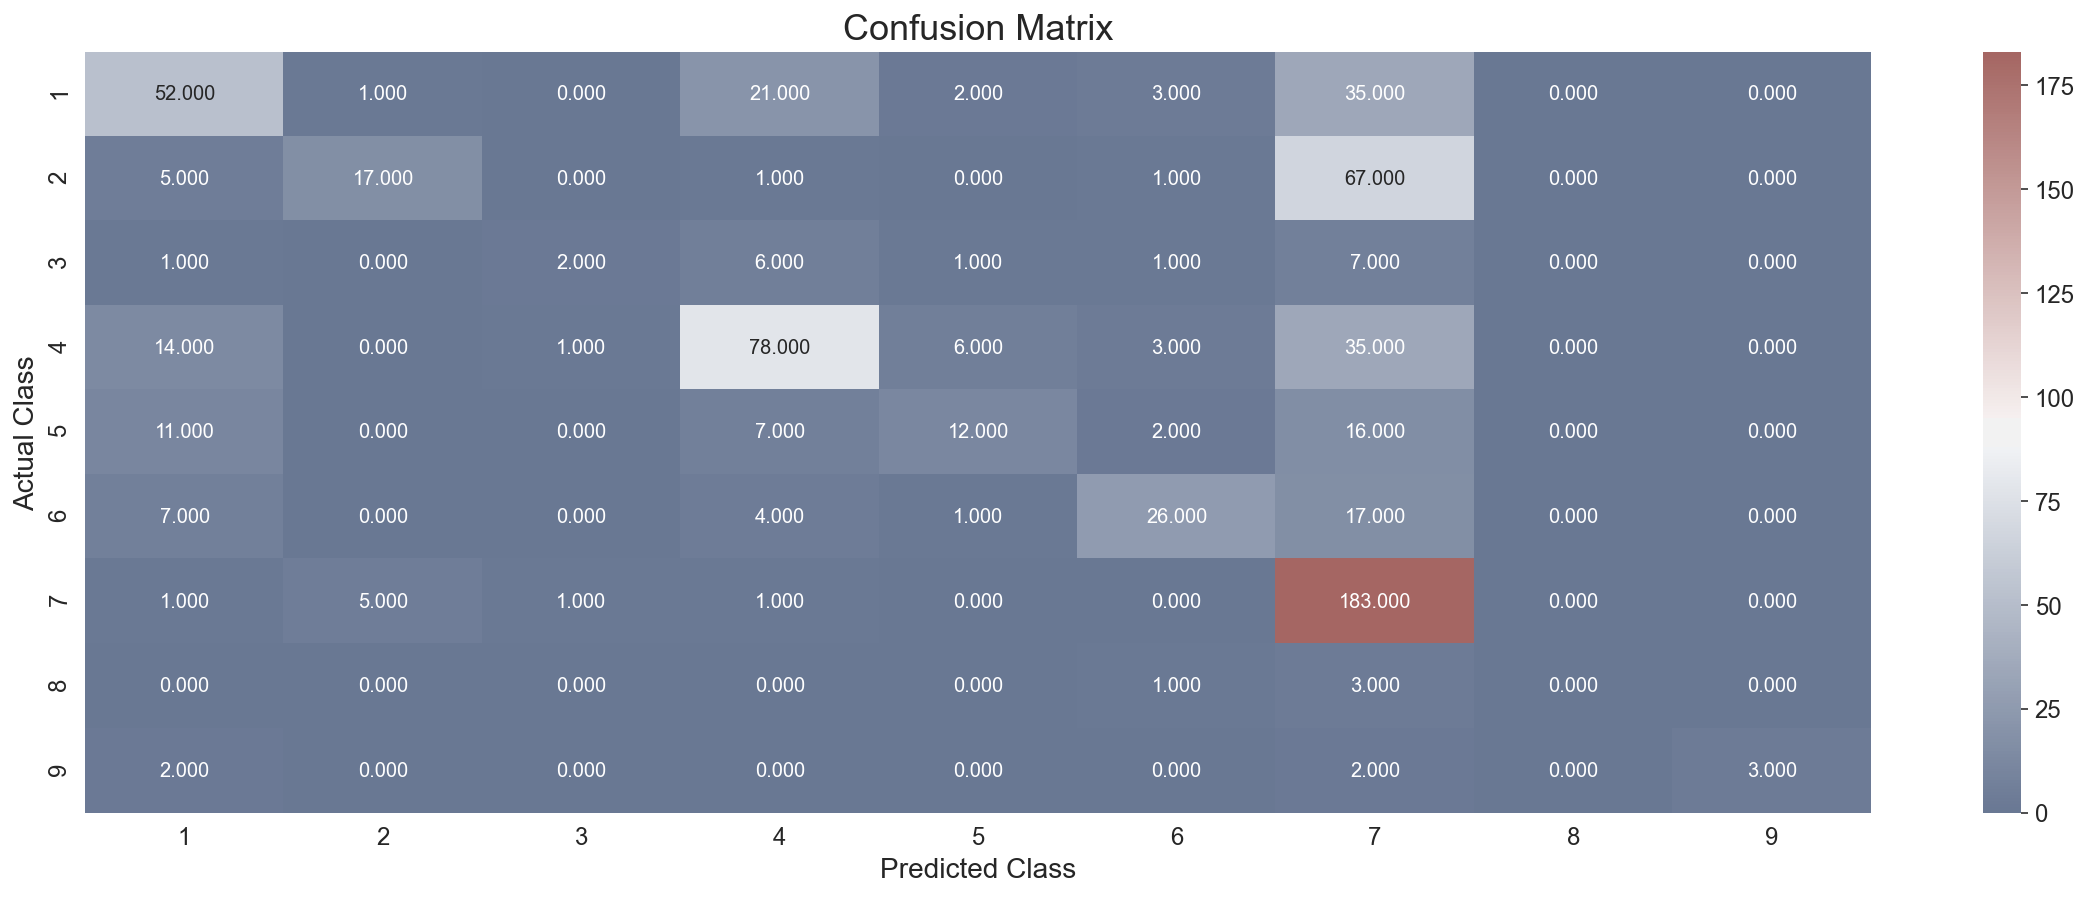

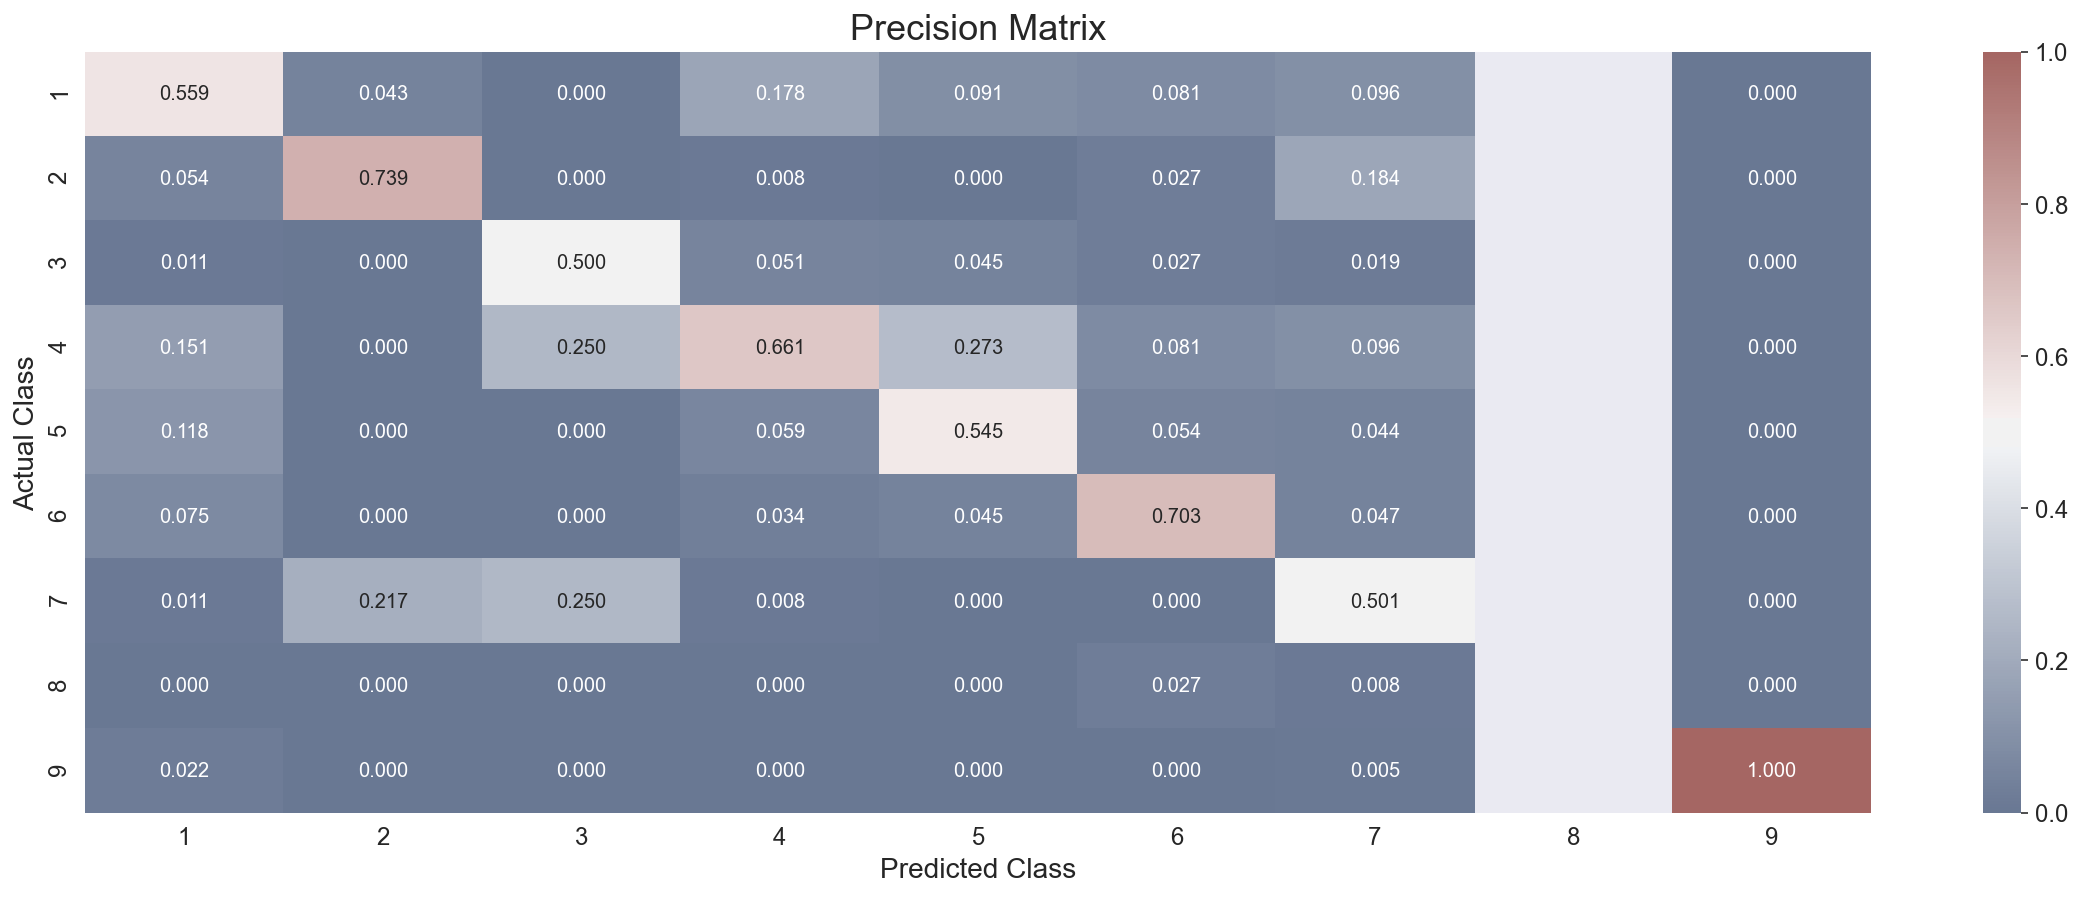

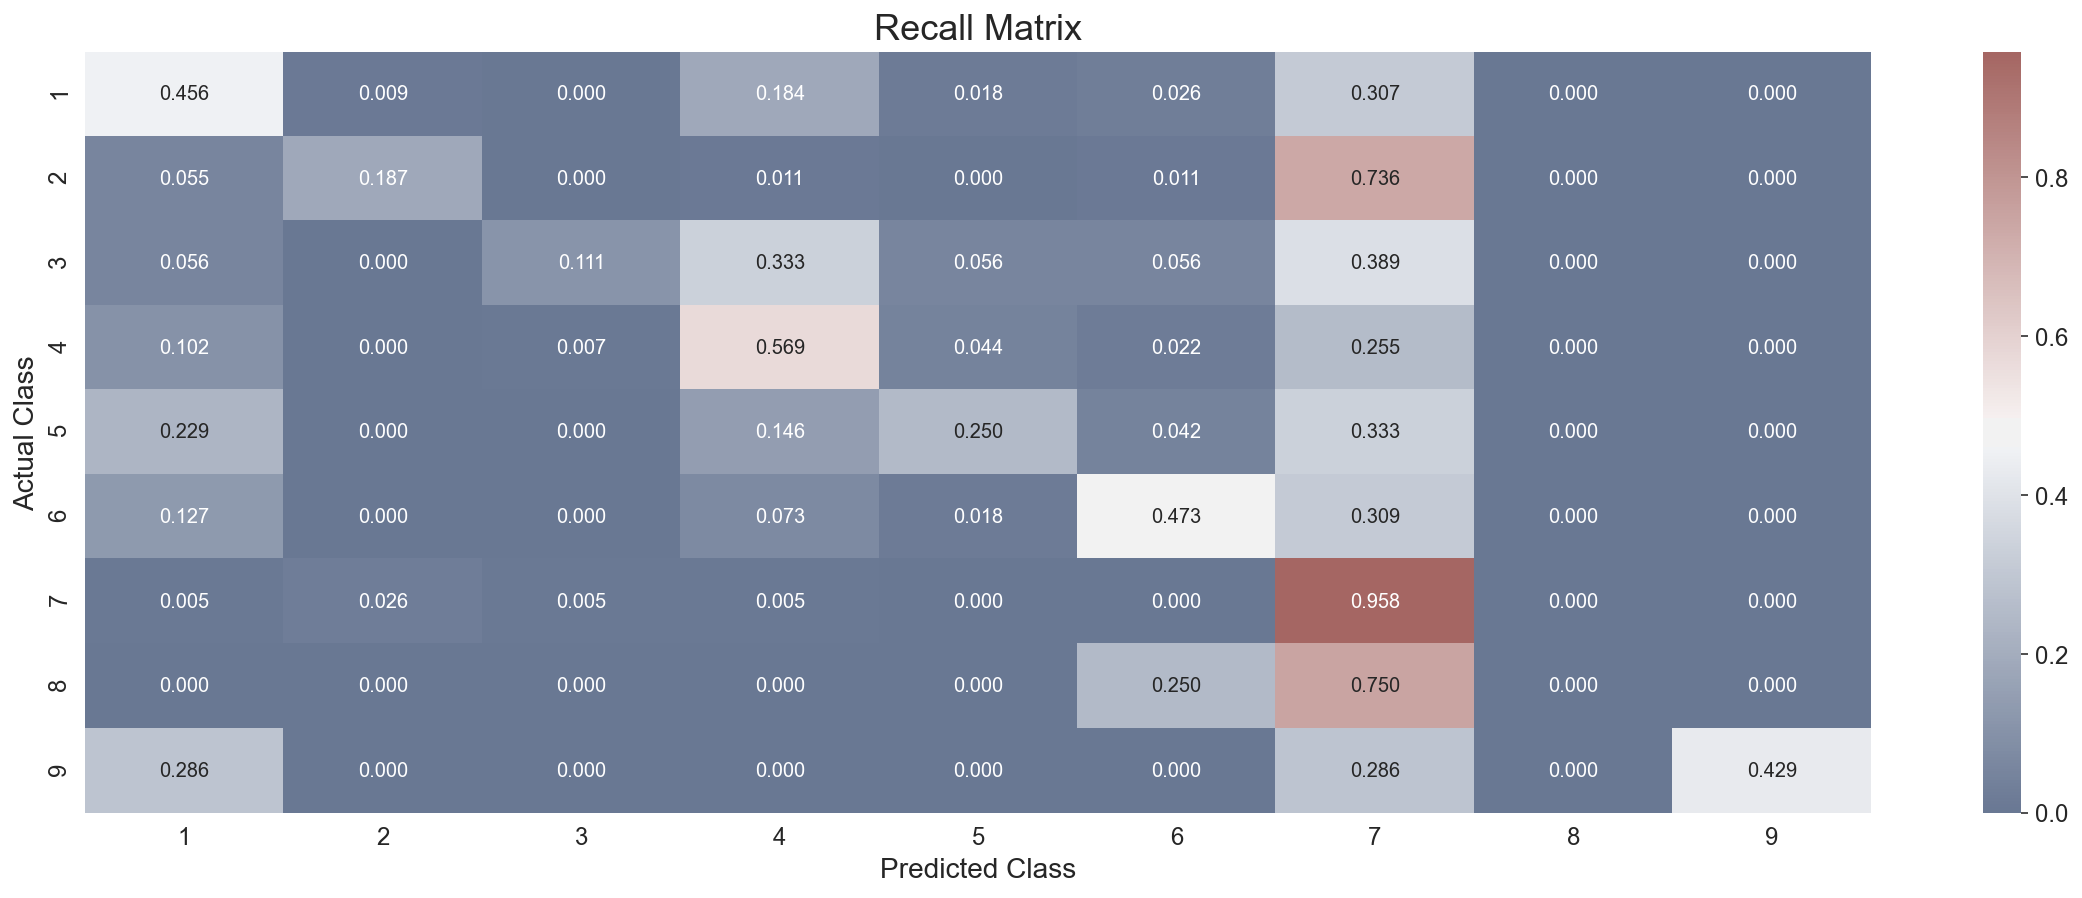

Gene : Response Coding
Variation : REsponse Coding
TEXT : Tf-idf
[log_loss] (1.3578019597012985) alpha [1e-05]
[log_loss] (1.3507964159955275) alpha [0.0001]
[log_loss] (1.349459808554973) alpha [0.001]
[log_loss] (1.3366316964812472) alpha [0.01]
[log_loss] (1.3397641754521379) alpha [0.1]
[log_loss] (1.3475261635269329) alpha [1]
[log_loss] (1.3424153396040532) alpha [10]
[log_loss] (1.3105988984269072) alpha [100]
[log_loss] (1.2539223933553245) alpha [1000]


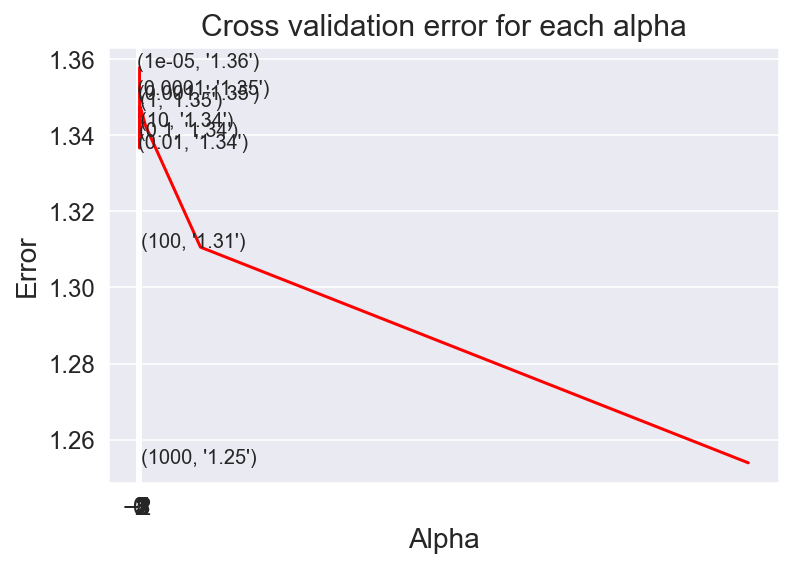

3
[ Best alpha : 1000 ]
[Train loss] (1.0941336766269996)
[CV loss] (1.2539223933553245)
[Test loss] (1.2595036686741512)
[Test Log loss] (1.2595036686741512)
Number of missclassified points : 0.42857142857142855


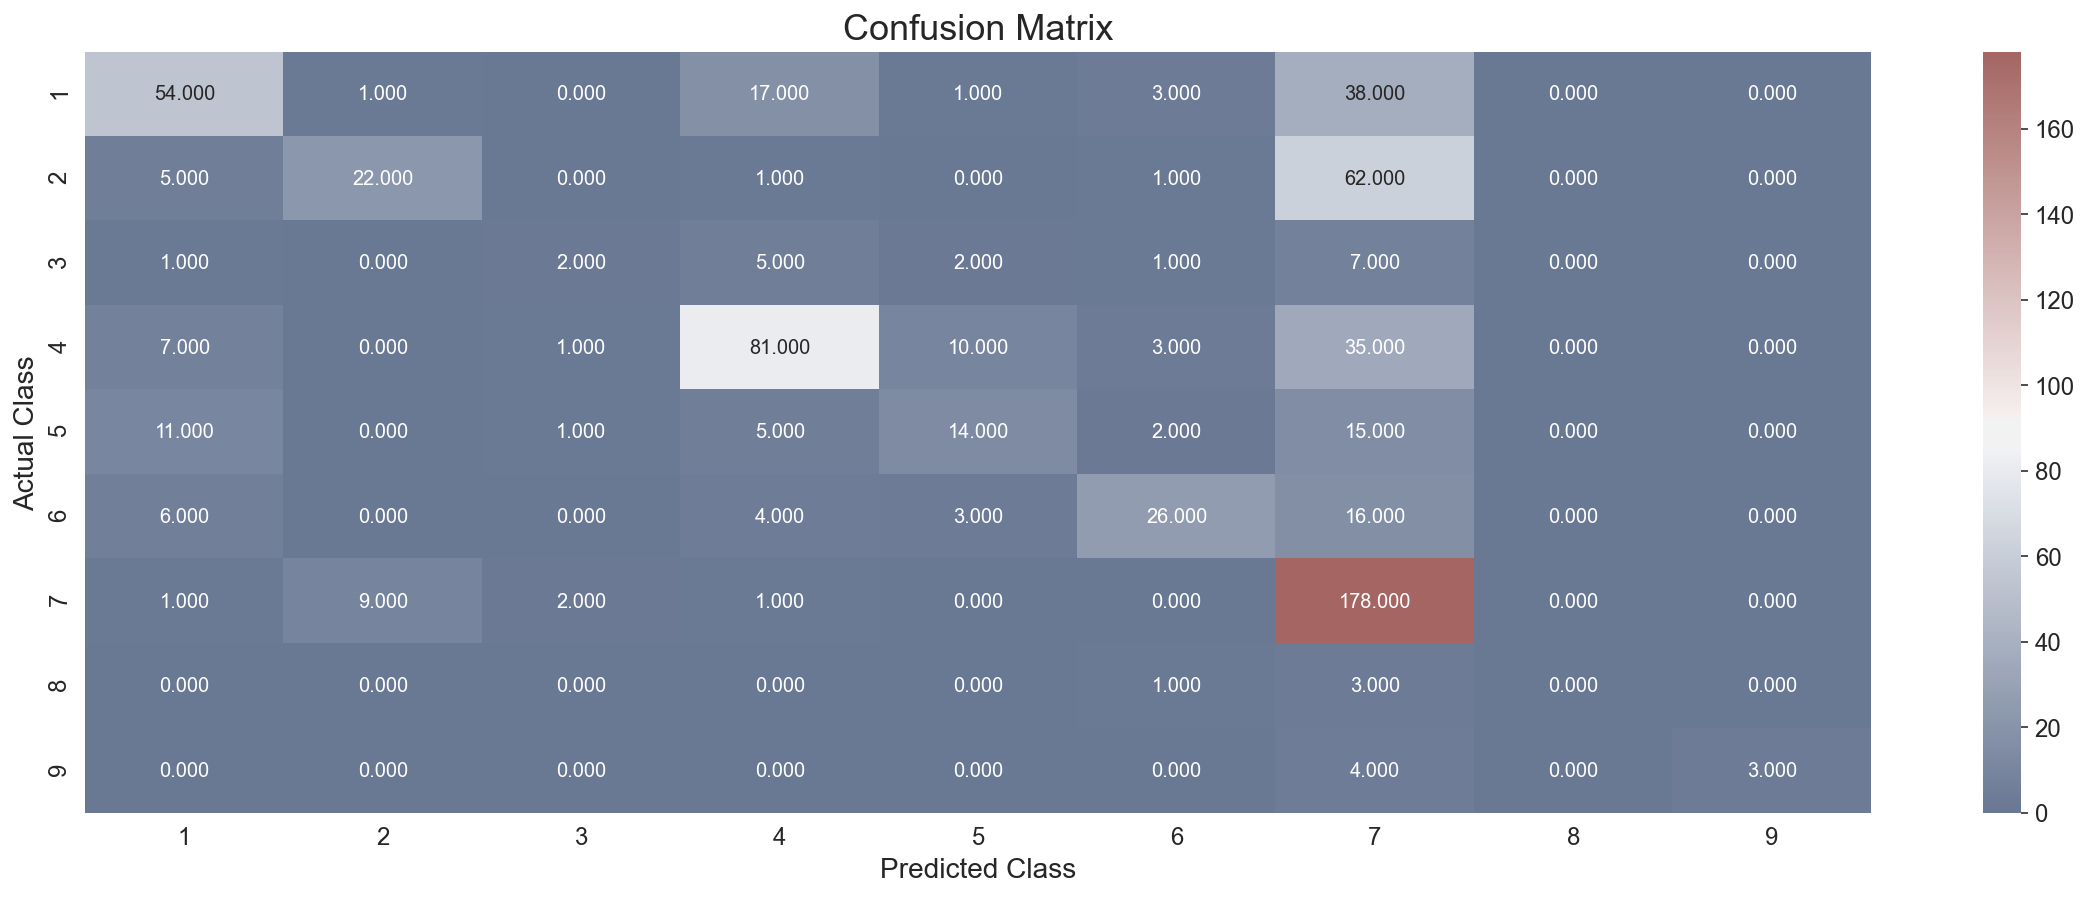

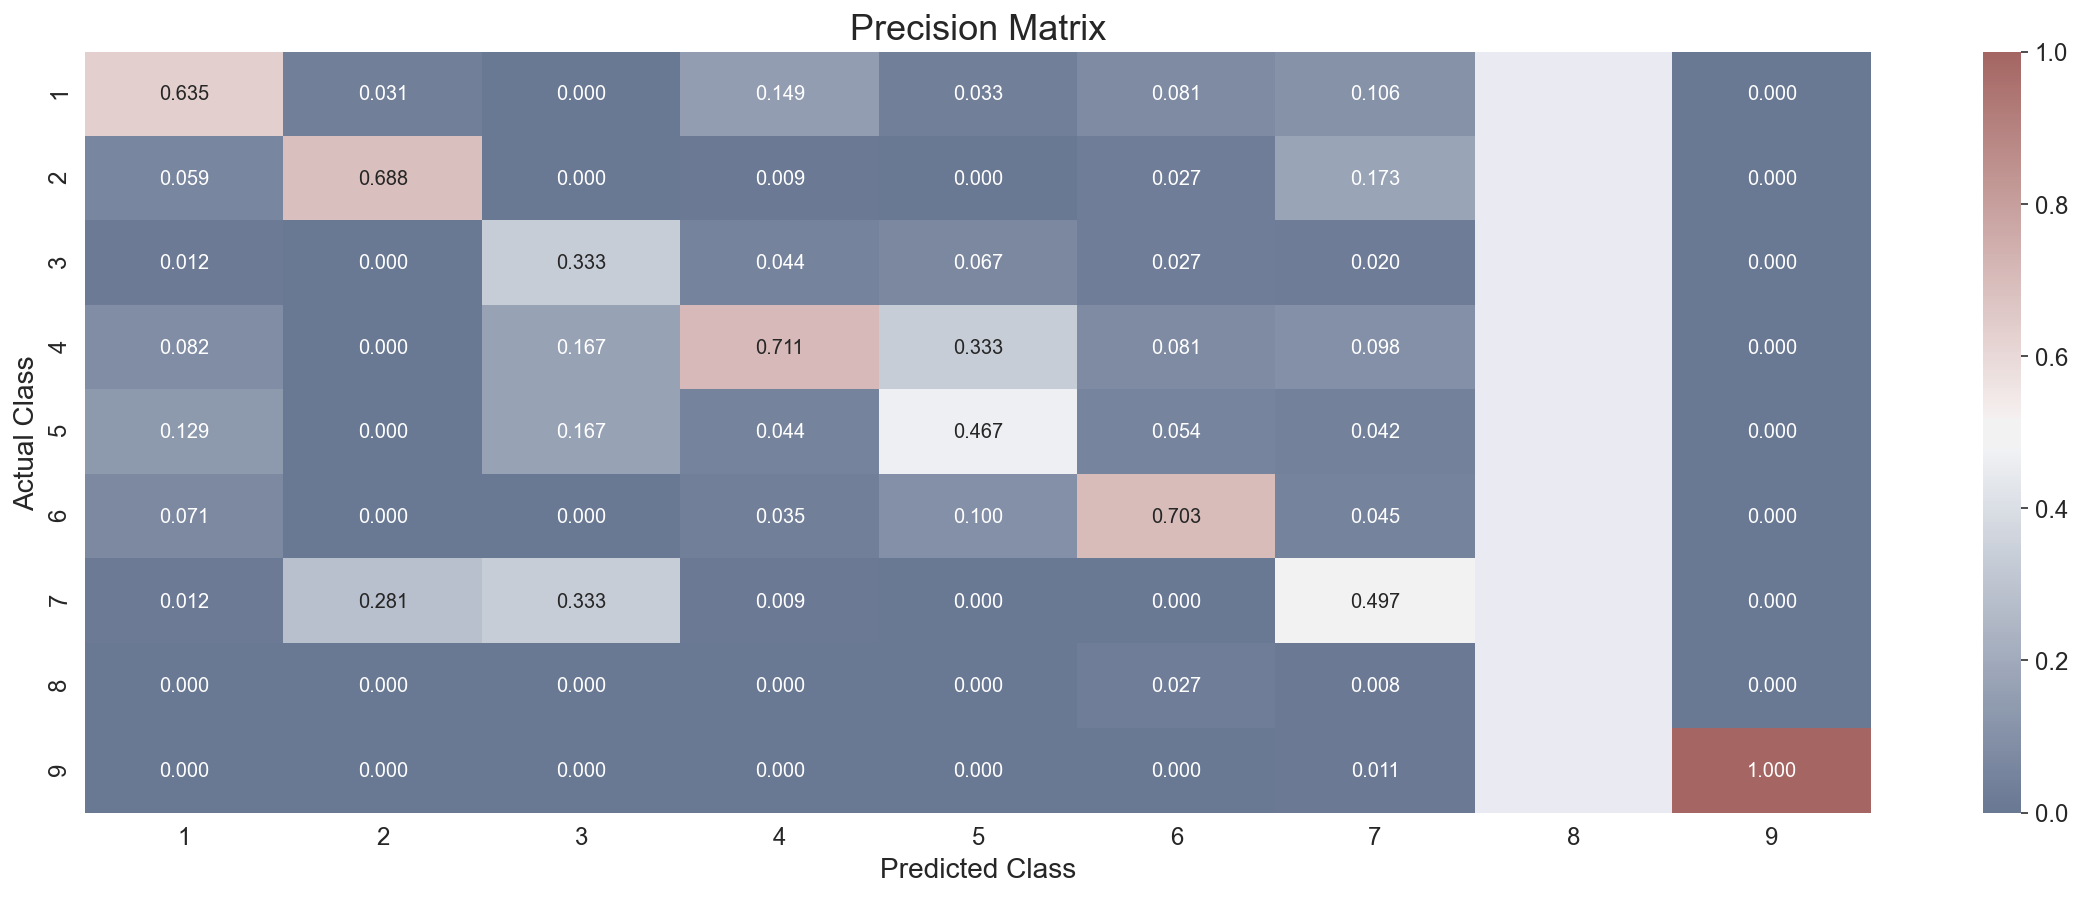

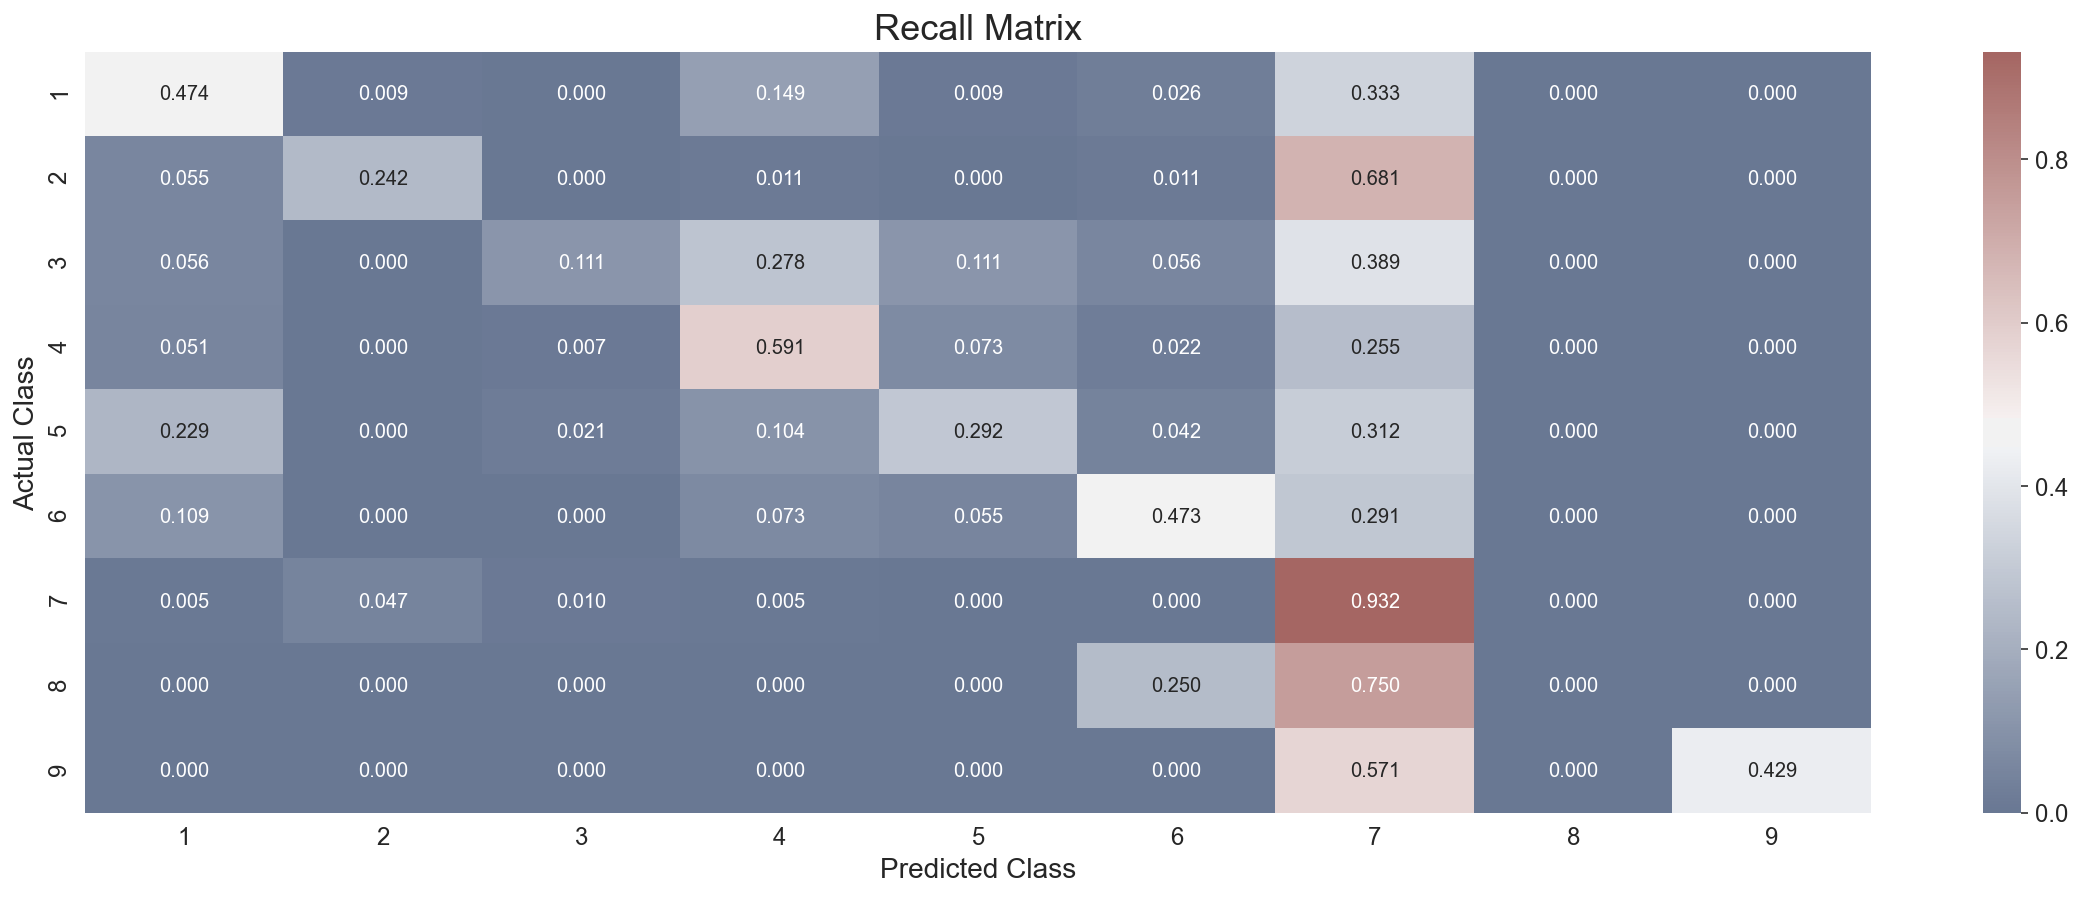

In [261]:
method_vect = ['BOW', 'Bi-gram', 'Uni + bi gram', 'Tf-idf']
kdd_data = [[X_train_kdd_bow, X_cv_kdd_bow, X_test_kdd_bow],
            [X_train_kdd_bi, X_cv_kdd_bi, X_test_kdd_bi],
            [X_train_kdd_uni_bi, X_cv_kdd_uni_bi, X_test_kdd_uni_bi],
            [X_train_kdd_tfidf, X_cv_kdd_tfidf, X_test_kdd_tfidf]]

for a, b in enumerate(method_vect):
    print("=======")
    print("Gene : KDD ohe")
    print("Variation : KDD ohe")
    print(f"TEXT : {b}")
    print("=======")
    alpha = [10**x for x in range(-5, 4)]
    cv_log_error = []
    for k in alpha:
        clf = MultinomialNB(alpha=k)
        clf.fit(kdd_data[a][0], y_train)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(kdd_data[a][0], y_train)
        y_pred = sig_clf.predict_proba(kdd_data[a][1])
        cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
        print(f"[log_loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{k}]")

    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error, c='r')
    for i, txt in enumerate(np.round(cv_log_error,2)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
    plt.xticks(np.log10(alpha))
    plt.title("Cross validation error for each alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Error")
    plt.show()

    print(a)

    best_alpha = np.argmin(cv_log_error)
    print("=====================")
    print(f"[ Best alpha : {alpha[best_alpha]} ]")
    print("=====================")
    clf = MultinomialNB(alpha=alpha[best_alpha])
    clf.fit(kdd_data[a][0], y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(kdd_data[a][0], y_train)
    y_pred = sig_clf.predict_proba(kdd_data[a][0])
    print(f"[Train loss] ({log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)})")
    y_pred = sig_clf.predict_proba(kdd_data[a][1])
    print(f"[CV loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)})")
    y_pred = sig_clf.predict_proba(kdd_data[a][2])
    print(f"[Test loss] ({log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)})")
    print("="*53)
    predict_and_plot_confusion_matrix(kdd_data[a][0], kdd_data[a][2], y_train, y_test, clf=MultinomialNB(alpha=alpha[best_alpha]))

    cv_log_error.clear()
    print("="*70)

In [ ]:
method_vect = ['BOW', 'Bi-gram', 'Uni + bi gram', 'Tf-idf']
mean_data = [[X_train_mean_bow, X_cv_mean_bow, X_test_mean_bow],
            [X_train_mean_bi, X_cv_mean_bi, X_test_mean_bi],
            [X_train_mean_uni_bi, X_cv_mean_uni_bi, X_test_mean_uni_bi],
            [X_train_mean_tfidf, X_cv_mean_tfidf, X_test_mean_tfidf]]

for a, b in enumerate(method_vect):
    print("=======")
    print("Gene : Response Coding")
    print("Variation : REsponse Coding")
    print(f"TEXT : {b}")
    print("=======")
    alpha = [10**x for x in range(-5, 4)]
    cv_log_error = []
    for k in alpha:
        clf = MultinomialNB(alpha=k)
        clf.fit(mean_data[a][0], y_train)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(mean_data[a][0], y_train)
        y_pred = sig_clf.predict_proba(mean_data[a][1])
        cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
        print(f"[log_loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{k}]")

    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error, c='r')
    for i, txt in enumerate(np.round(cv_log_error,2)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
    plt.xticks(np.log10(alpha))
    plt.title("Cross validation error for each alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Error")
    plt.show()

    print(a)

    best_alpha = np.argmin(cv_log_error)
    print("=====================")
    print(f"[ Best alpha : {alpha[best_alpha]} ]")
    print("=====================")
    clf = MultinomialNB(alpha=alpha[best_alpha])
    clf.fit(mean_data[a][0], y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(mean_data[a][0], y_train)
    y_pred = sig_clf.predict_proba(mean_data[a][0])
    print(f"[Train loss] ({log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)})")
    y_pred = sig_clf.predict_proba(mean_data[a][1])
    print(f"[CV loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)})")
    y_pred = sig_clf.predict_proba(mean_data[a][2])
    print(f"[Test loss] ({log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)})")
    print("="*53)
    predict_and_plot_confusion_matrix(mean_data[a][0], mean_data[a][2], y_train, y_test, clf=MultinomialNB(alpha=alpha[best_alpha]))

    cv_log_error.clear()
    print("="*70)

In [ ]:
method_vect = ['BOW', 'Bi-gram', 'Uni + bi gram', 'Tf-idf']
freq_data = [[X_train_freq_bow, X_cv_freq_bow, X_test_freq_bow],
            [X_train_freq_bi, X_cv_freq_bi, X_test_freq_bi],
            [X_train_freq_uni_bi, X_cv_freq_uni_bi, X_test_freq_uni_bi],
            [X_train_freq_tfidf, X_cv_freq_tfidf, X_test_freq_tfidf]]

for a, b in enumerate(method_vect):
    print("=======")
    print("Gene : Response Coding")
    print("Variation : REsponse Coding")
    print(f"TEXT : {b}")
    print("=======")
    alpha = [10**x for x in range(-5, 4)]
    cv_log_error = []
    for k in alpha:
        clf = MultinomialNB(alpha=k)
        clf.fit(freq_data[a][0], y_train)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(freq_data[a][0], y_train)
        y_pred = sig_clf.predict_proba(freq_data[a][1])
        cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
        print(f"[log_loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{k}]")

    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error, c='r')
    for i, txt in enumerate(np.round(cv_log_error,2)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
    plt.xticks(np.log10(alpha))
    plt.title("Cross validation error for each alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Error")
    plt.show()

    print(a)

    best_alpha = np.argmin(cv_log_error)
    print("=====================")
    print(f"[ Best alpha : {alpha[best_alpha]} ]")
    print("=====================")
    clf = MultinomialNB(alpha=alpha[best_alpha])
    clf.fit(freq_data[a][0], y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(freq_data[a][0], y_train)
    y_pred = sig_clf.predict_proba(freq_data[a][0])
    print(f"[Train loss] ({log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)})")
    y_pred = sig_clf.predict_proba(freq_data[a][1])
    print(f"[CV loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)})")
    y_pred = sig_clf.predict_proba(freq_data[a][2])
    print(f"[Test loss] ({log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)})")
    print("="*53)
    predict_and_plot_confusion_matrix(freq_data[a][0], freq_data[a][2], y_train, y_test, clf=MultinomialNB(alpha=alpha[best_alpha]))

    cv_log_error.clear()
    print("="*70)